  # Charity Analysis Select NTEE 
  # Motivation
  
  Analyze non-profit organization to predict number of volunteer. This project will be looking at only select NTEE since the previous model with all the codes did not perform well. The objective is to create a smaller set for the purpose of the new application.
  

In [1]:
import pandas as pd 
import sqlalchemy as sa
from pathlib import Path
from sqlalchemy import create_engine
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import seaborn as sns
from pylab import rcParams
from collections import Counter
%matplotlib inline

# Data Cleaning (Part 1)
## Prelimiary Cleaning

In [2]:
#%%
query=''' SELECT *
FROM Open990
'''
e = sa.create_engine(r'sqlite:///D:\Program_practices\Charity\open990database.db')
df= pd.read_sql_query(query, e)
irrelevant=['country', 'org_form.other_form_desc', 'grp_exempt_num', 'state_legaldomicile', 
           'grp_return', 'grp_subs_all_incl', 'exempt_status.501c3', 'exempt_status.501c_any',
           'exempt_status.501c_txt','income_tot_unrelated', 'income_net_unrelated', 
           'rev_giftsgrants_tot_prioryr', 'rev_prgmservice_prioryr', 'rev_investmt_prioryr',
           'rev_other_prioryr','fundraiseservfee_expense_tot_prioryr', 'grants_expense_tot_prioryr',
           'benefits_expense_tot_prioryr', 'salaries_expense_tot_prioryr', 'fundraise_expense_tot_curyr',
           'other_expense_tot_prioryr','rev_giftsgrants_tot_curyr', 'rev_prgmservice_curyr',
           'rev_investmt_curyr', 'rev_other_curyr', 'fundraiseservfee_expense_tot_curyr', 'grants_expense_tot_curyr',
           'benefits_expense_tot_curyr', 'salaries_expense_tot_curyr', 'fundraise_expense_tot_curyr',
           'other_expense_tot_curyr','operate_hospfacility', 'relationsamongemployees', 'delegate_management',
           'memb_or_stockholder', 'memb_elect_board','decisions_outside_board', 'govern_body_minutes',
           'committee_minutes', 'no_officer_address', 'policies_ref_chapt', '990_to_members', 'conflict_interest_policy',
           'conflict_disclosure','enforce_conflict_policy', 'whistleblower_policy', 'doc_retention_policy',
           'ceo_comp_review','officer_comp_review', 'in_joint_venture', 'joint_venture_policy', 
           'forms_ownwebsite', 'record_id', 'schema_version', 'irs_efile_id', 'random_string', 'tax_date_begin', 
            'tax_date_end', 'doing_business_as', 'phone', 'website', 'address', 'zip', 'liability_tot_endyr', 'comp_currkeypersons_tot',
       'cash_noninterest_endyr', 'savingtempcash_endyr', 'pledges_net_endyr',
       'accountreceivable_net_endyr', 'invest_publicsec_endyr',
       'invest_othersec_endyr', 'invest_prog_endyr', 'asset_intangible_endyr',
       'asset_unrestrictnet_endyr', 'asset_temprestrictnet_endyr',
       'asset_permrestrictnet_endyr', 'liability_tot_beginyr','rev_tot_prioryr', 
       'expense_tot_prioryr', 'asset_net_beginyr', 'rev_less_expense_prioryr', 
       'asset_tot_beginyr', 'material_diversion','discontinue_dispose25','voting_indepmemb_ct'
           ]
df=df.drop(columns=irrelevant)
w= sa.create_engine(r'sqlite:///D:\Program_practices\Charity\open990database.sqlite')
df.to_sql('Full_data', w, if_exists='replace', index=False)

In [3]:
df.columns

Index(['ein', 'name_org', 'tax_yr', 'city', 'state', 'org_form.association',
       'org_form.corp', 'org_form.other_form', 'org_form.trust',
       'formation_yr', 'gross_receipts', 'ntee_code_nccs',
       'ntee_description_nccs', 'voting_memb_ct', 'employee_tot_ct',
       'volunteer_tot_ct', 'rev_tot_curyr', 'expense_tot_curyr',
       'rev_less_expense_curyr', 'asset_tot_endyr', 'asset_net_endyr',
       'local_chapt'],
      dtype='object')

In [4]:
#Deleting rows with no volunteers after filling them in
df['volunteer_tot_ct']=df['volunteer_tot_ct'].fillna(0).astype(int)
df=df[df['volunteer_tot_ct'] !=0]


key=df[['ein', 'ntee_code_nccs', 'ntee_description_nccs']]
key=key.drop_duplicates().dropna().reset_index(drop=True)

# Only keeping the most recent tax year
df=df.groupby('ein', group_keys=False).apply(lambda x: x.loc[x['tax_yr'].idxmax()])
df.index.name=None
df=pd.merge(df,key, on='ein', how='left')

# The duplicates are due to changes in business ntee code; we will take the newest code
df = df.drop_duplicates(subset='ein', keep="last")
df['ntee_code_nccs_x']=df['ntee_code_nccs_x'].fillna(df['ntee_code_nccs_y'])

In [5]:
df.head()

ein                                           name_org  tax_yr  \
0  10018922      AMERICAN LEGION AUXILIARY DEPARTMENT OF MAINE    2015   
1  10018927             AMERICAN LEGION POST 5 BOURQUE-LANIGAN    2015   
2  10019705  Ancient Free and Accepted Masons of Maine Gran...    2017   
3  10022320                               AUGUSTA COUNTRY CLUB    2013   
4  10022415                Kennebec Valley Chamber of Commerce    2016   

         city state org_form.association org_form.corp org_form.other_form  \
0     OAKLAND    ME                 None          true                None   
1  WATERVILLE    ME                 None          true                None   
2      Holden    ME                 None          true                None   
3  MANCHESTER    ME                 None          true                None   
4     Augusta    ME                 None          true                None   

  org_form.trust formation_yr  ...  employee_tot_ct volunteer_tot_ct  \
0           None         1920  ...                2             8500   
1           None         1926  ...               10               15   
2           None         1820  ...                6                9   
3           None         1916  ...               75               32   
4           None         1932  ...                6              250   

  rev_tot_curyr  expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
0        261954             224737                   37217           230245   
1        149680             194188                  -44508           595704   
2        303609             328535                  -24926          1743560   
3       1457148            1452080                    5068           886328   
4        531901             538418                   -6517           550635   

   asset_net_endyr  local_chapt  ntee_code_nccs_y  \
0           230245           no               W30   
1           566086           no               W30   
2          1743560          yes               Y42   
3          -221984           no               N50   
4           196796           no               S41   

                  ntee_description_nccs_y  
0       Military, Veterans' Organizations  
1       Military, Veterans' Organizations  
2            Domestic Fraternal Societies  
3  Recreational, Pleasure, or Social Club  
4                   Promotion of Business  

[5 rows x 24 columns]

In [6]:
# data cleaning
df['org_form.association'] = df['org_form.association'].apply(lambda true: True if true else False)
df['org_form.corp'] = df['org_form.corp'].apply(lambda true: True if true else False)
df['org_form.other_form'] = df['org_form.other_form'].apply(lambda true: True if true else False)
df['org_form.trust'] = df['org_form.trust'].apply(lambda true: True if true else False)

# fill in formation yr with tax_yr if null of if more than 2018
df['formation_yr']=df['formation_yr'].fillna(value=df['tax_yr']).astype(int)
df['formation_yr']=df[['formation_yr','tax_yr']].apply(lambda x: x['tax_yr'] if x['formation_yr']>2018 else x['formation_yr'], axis=1).astype(int)

In [7]:
df=df.drop(columns=['ntee_code_nccs_x', 'ntee_description_nccs_x'])

In [8]:
df['local_chapt']=df['local_chapt'].apply(lambda md: 1 if md=='yes' else 0)

In [9]:
df.head()

ein                                           name_org  tax_yr  \
0  10018922      AMERICAN LEGION AUXILIARY DEPARTMENT OF MAINE    2015   
1  10018927             AMERICAN LEGION POST 5 BOURQUE-LANIGAN    2015   
2  10019705  Ancient Free and Accepted Masons of Maine Gran...    2017   
3  10022320                               AUGUSTA COUNTRY CLUB    2013   
4  10022415                Kennebec Valley Chamber of Commerce    2016   

         city state  org_form.association  org_form.corp  org_form.other_form  \
0     OAKLAND    ME                 False           True                False   
1  WATERVILLE    ME                 False           True                False   
2      Holden    ME                 False           True                False   
3  MANCHESTER    ME                 False           True                False   
4     Augusta    ME                 False           True                False   

   org_form.trust  formation_yr  ...  employee_tot_ct  volunteer_tot_ct  \
0           False          1920  ...                2              8500   
1           False          1926  ...               10                15   
2           False          1820  ...                6                 9   
3           False          1916  ...               75                32   
4           False          1932  ...                6               250   

   rev_tot_curyr  expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
0         261954             224737                   37217           230245   
1         149680             194188                  -44508           595704   
2         303609             328535                  -24926          1743560   
3        1457148            1452080                    5068           886328   
4         531901             538418                   -6517           550635   

   asset_net_endyr  local_chapt  ntee_code_nccs_y  \
0           230245            0               W30   
1           566086            0               W30   
2          1743560            1               Y42   
3          -221984            0               N50   
4           196796            0               S41   

                  ntee_description_nccs_y  
0       Military, Veterans' Organizations  
1       Military, Veterans' Organizations  
2            Domestic Fraternal Societies  
3  Recreational, Pleasure, or Social Club  
4                   Promotion of Business  

[5 rows x 22 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 22 columns):
ein                        192991 non-null int64
name_org                   192991 non-null object
tax_yr                     192991 non-null int64
city                       192988 non-null object
state                      192955 non-null object
org_form.association       192991 non-null bool
org_form.corp              192991 non-null bool
org_form.other_form        192991 non-null bool
org_form.trust             192991 non-null bool
formation_yr               192991 non-null int32
gross_receipts             192991 non-null int64
voting_memb_ct             192991 non-null int64
employee_tot_ct            192991 non-null int64
volunteer_tot_ct           192991 non-null int64
rev_tot_curyr              192991 non-null int64
expense_tot_curyr          192991 non-null int64
rev_less_expense_curyr     192991 non-null int64
asset_tot_endyr            192991 non-null int64
asset_ne

In [11]:
ntee_encoded = pd.get_dummies(df['ntee_code_nccs_y'].str[0])
ntee_encoded.columns = ['code_' + col.upper() for col in ntee_encoded.columns]
df = pd.concat([df, ntee_encoded], axis=1)
df['code_Z']=df['ntee_code_nccs_y'].apply(lambda code: 1 if pd.isna(code)==True else 0)
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'Of' else x)
df = df.drop(columns=['ntee_code_nccs_y', 'ntee_description_nccs_y'])

In [12]:
len(df)-((df.iloc[:,-26:]==0).sum())

code_A    14127
code_B    22429
code_C     3808
code_D     3378
code_E    14128
code_F     3801
code_G     4178
code_H      925
code_I     2985
code_J     2557
code_K     2433
code_L     7920
code_M     4231
code_N    11926
code_O     3733
code_P    20190
code_Q     3109
code_R     1248
code_S    13462
code_T     5902
code_U     1013
code_V      345
code_W     6358
code_X     7053
code_Y     3066
code_Z    28507
dtype: int64

In [13]:
non_num=['ein', 'name_org', 'tax_yr', 'city', 'state']
bool_var=['org_form.association', 'org_form.corp', 'org_form.other_form', 'org_form.trust',
          'local_chapt','code_A', 'code_B', 'code_C', 'code_D',
       'code_E', 'code_F', 'code_G', 'code_H', 'code_I', 'code_J', 'code_K',
       'code_L', 'code_M', 'code_N', 'code_O', 'code_P', 'code_Q', 'code_R',
       'code_S', 'code_T', 'code_U', 'code_V', 'code_W', 'code_X', 'code_Y',
       'code_Z']

df=df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
temp=df.copy()
df[bool_var]=df[bool_var].astype(bool)

df=df.apply(lambda x: x.astype(float) if (x.dtype=='int64') else x)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 46 columns):
ein                       192991 non-null float64
name_org                  192991 non-null object
tax_yr                    192991 non-null float64
city                      192991 non-null object
state                     192991 non-null object
org_form.association      192991 non-null bool
org_form.corp             192991 non-null bool
org_form.other_form       192991 non-null bool
org_form.trust            192991 non-null bool
formation_yr              192991 non-null int32
gross_receipts            192991 non-null float64
voting_memb_ct            192991 non-null float64
employee_tot_ct           192991 non-null float64
volunteer_tot_ct          192991 non-null float64
rev_tot_curyr             192991 non-null float64
expense_tot_curyr         192991 non-null float64
rev_less_expense_curyr    192991 non-null float64
asset_tot_endyr           192991 non-null float64
asset_

## Reducing Based on Organization Format

Seems difficult based on the organization type

In [15]:
# plotting org type in seaborn
orgtype=df[['org_form.association', 'org_form.corp','org_form.other_form','org_form.trust']]
orgtype=orgtype.sum()
orgtype

org_form.association      6952
org_form.corp           178891
org_form.other_form       3479
org_form.trust            2244
dtype: int64

In [16]:
df[df['org_form.association']==1]

ein                                           name_org  \
18       10095414.0  Independent Order of Odd Fellows Grand Lodge o...   
20       10100593.0                               KENNEBUNK RIVER CLUB   
33       10133442.0                 OXFORD COUNTY AGRICULTURAL SOCIETY   
46       10155360.0                          Maine Bankers Association   
50       10165110.0                          MAINE TOURISM ASSOCIATION   
...             ...                                                ...   
202112  990293085.0              The Korean American Foundation Hawaii   
202184  990323091.0                HAWAII ASSOCIATION OF MORTGAGE BROK   
202214  990335776.0                      HAWAII STATE JUNIOR GOLF ASSN   
202243  990346683.0      LEILEHUA HIGH SCHOOL BAND BOOSTER ASSOCIATION   
202298  996006863.0                          HAWAII ACADEMY OF SCIENCE   

        tax_yr           city state  org_form.association  org_form.corp  \
18      2017.0         Auburn    ME                  True          False   
20      2016.0  KENNEBUNKPORT    ME                  True          False   
33      2013.0         NORWAY    ME                  True          False   
46      2016.0      Westbrook    ME                  True          False   
50      2017.0      HALLOWELL    ME                  True          False   
...        ...            ...   ...                   ...            ...   
202112  2016.0       Honolulu    HI                  True          False   
202184  2016.0       HONOLULU    HI                  True          False   
202214  2012.0          LIHUE    HI                  True          False   
202243  2016.0        WAHIAWA    HI                  True          False   
202298  2017.0       HONOLULU    HI                  True          False   

        org_form.other_form  org_form.trust  formation_yr  ...  code_Q  \
18                    False           False          1844  ...   False   
20                    False           False          2016  ...   False   
33                    False           False          1842  ...   False   
46                    False           False          1893  ...   False   
50                    False           False          1937  ...   False   
...                     ...             ...           ...  ...     ...   
202112                False           False          1992  ...   False   
202184                False           False          1995  ...   False   
202214                False           False          1999  ...   False   
202243                False           False          1999  ...   False   
202298                False           False          1925  ...   False   

        code_R  code_S  code_T  code_U  code_V  code_W  code_X  code_Y  code_Z  
18       False   False   False   False   False   False   False    True   False  
20       False   False   False   False   False   False   False   False   False  
33       False   False   False   False   False   False   False   False   False  
46       False    True   False   False   False   False   False   False   False  
50       False    True   False   False   False   False   False   False   False  
...        ...     ...     ...     ...     ...     ...     ...     ...     ...  
202112   False   False   False   False   False   False   False   False   False  
202184   False    True   False   False   False   False   False   False   False  
202214   False   False   False   False   False   False   False   False   False  
202243   False   False   False   False   False   False   False   False   False  
202298   False   False   False   False   False   False   False   False   False  

[6952 rows x 46 columns]

In [17]:
df[df['org_form.trust']==1]

ein                                           name_org  \
249      10275159.0                    JUNIOR ACHIEVEMENT OF MAINE INC   
366      10352474.0                SCARBOROUGH LAND CONSERVATION TRUST   
383      10357213.0                        FREEPORT CONSERVATION TRUST   
394      10359948.0                             HIRUNDO WILDLIFE TRUST   
505      10390443.0                            Davis Family Foundation   
...             ...                                                ...   
202152  990308924.0                           HINDU HERITAGE ENDOWMENT   
202308  996010618.0  THE PUBLIC HEALTH FUND OF THE CHAMBER OF COMME...   
202310  996011303.0                                    HANA MAUI TRUST   
202311  996011524.0     Charles R Kendall Scholarship & Education Fund   
202318  996035847.0                       ARCADIA MEMORIAL IRREV TRUST   

        tax_yr         city state  org_form.association  org_form.corp  \
249     2017.0     PORTLAND    ME                 False          False   
366     2017.0  SCARBOROUGH    ME                 False          False   
383     2016.0     FREEPORT    ME                 False          False   
394     2017.0        ORONO    ME                 False          False   
505     2016.0     Yarmouth    ME                 False          False   
...        ...          ...   ...                   ...            ...   
202152  2016.0        KAPAA    HI                 False          False   
202308  2014.0     HONOLULU    HI                 False          False   
202310  2014.0         HANA    HI                 False          False   
202311  2017.0     Honolulu    HI                 False          False   
202318  2016.0     HONOLULU    HI                 False          False   

        org_form.other_form  org_form.trust  formation_yr  ...  code_Q  \
249                   False            True          1965  ...   False   
366                   False            True          1977  ...   False   
383                   False            True          1977  ...   False   
394                   False            True          1965  ...   False   
505                   False            True          1983  ...   False   
...                     ...             ...           ...  ...     ...   
202152                False            True          1993  ...   False   
202308                False            True          1901  ...   False   
202310                False            True          2014  ...   False   
202311                False            True          2001  ...   False   
202318                False            True          1977  ...   False   

        code_R  code_S  code_T  code_U  code_V  code_W  code_X  code_Y  code_Z  
249      False   False   False   False   False   False   False   False   False  
366      False   False   False   False   False   False   False   False   False  
383      False   False   False   False   False   False   False   False   False  
394      False   False   False   False   False   False   False   False   False  
505      False   False    True   False   False   False   False   False   False  
...        ...     ...     ...     ...     ...     ...     ...     ...     ...  
202152   False   False   False   False   False   False   False   False   False  
202308   False    True   False   False   False   False   False   False   False  
202310   False   False    True   False   False   False   False   False   False  
202311   False   False   False   False   False   False   False   False   False  
202318   False   False   False   False   False   False   False   False   False  

[2244 rows x 46 columns]

In [18]:
df[df['org_form.other_form']==1]

ein                                           name_org  \
15       10063057.0                      Fraternal Order of Eagles 804   
52       10170013.0                             SHRINERS INTERNATIONAL   
213      10261000.0                     SABATTUS REGIONAL CREDIT UNION   
217      10263198.0                       Down East Community Hospital   
234      10269301.0                      MAINE ASSOCIATION OF REALTORS   
...             ...                                                ...   
202126  990298721.0              KAUAI HOUSING DEVELOPMENT CORPORATION   
202154  990309332.0                                  BULLS SOCCER CLUB   
202210  990332316.0  INTERNATIONAL CHRISTIAN SCHOOLS KONA HAWAII CA...   
202221  990337979.0               PACIFIC AVIATION MUSEUM PEARL HARBOR   
202290  996001152.0                                      ASSETS SCHOOL   

        tax_yr         city state  org_form.association  org_form.corp  \
15      2017.0    Biddeford    ME                 False          False   
52      2016.0       BANGOR    ME                 False          False   
213     2012.0     Sabattus    ME                 False          False   
217     2016.0      Machias    ME                 False          False   
234     2017.0      AUGUSTA    ME                 False          False   
...        ...          ...   ...                   ...            ...   
202126  2017.0        LIHUE    HI                 False          False   
202154  2013.0     HONOLULU    HI                 False          False   
202210  2018.0  KAILUA KONA    HI                 False          False   
202221  2016.0     HONOLULU    HI                 False          False   
202290  2017.0     HONOLULU    HI                 False          False   

        org_form.other_form  org_form.trust  formation_yr  ...  code_Q  \
15                     True           False          1975  ...   False   
52                     True           False          1921  ...   False   
213                    True           False          1957  ...   False   
217                    True           False          1963  ...   False   
234                    True           False          1936  ...   False   
...                     ...             ...           ...  ...     ...   
202126                 True           False          1992  ...   False   
202154                 True           False          1975  ...   False   
202210                 True           False          1982  ...   False   
202221                 True           False          2004  ...   False   
202290                 True           False          1955  ...   False   

        code_R  code_S  code_T  code_U  code_V  code_W  code_X  code_Y  code_Z  
15       False   False   False   False   False   False   False    True   False  
52       False   False   False   False   False   False   False    True   False  
213      False   False   False   False   False    True   False   False   False  
217      False   False   False   False   False   False   False   False   False  
234      False    True   False   False   False   False   False   False   False  
...        ...     ...     ...     ...     ...     ...     ...     ...     ...  
202126   False   False   False   False   False   False   False   False    True  
202154   False   False   False   False   False   False   False   False   False  
202210   False   False   False   False   False   False   False   False    True  
202221   False   False   False   False   False   False   False   False   False  
202290   False   False   False   False   False   False   False   False   False  

[3479 rows x 46 columns]

In [20]:
df[df['org_form.other_form']==1]

ein                                           name_org  \
15       10063057.0                      Fraternal Order Of Eagles 804   
52       10170013.0                             Shriners International   
213      10261000.0                     Sabattus Regional Credit Union   
217      10263198.0                       Down East Community Hospital   
234      10269301.0                      Maine Association Of Realtors   
...             ...                                                ...   
202126  990298721.0              Kauai Housing Development Corporation   
202154  990309332.0                                  Bulls Soccer Club   
202210  990332316.0  International Christian Schools Kona Hawaii Ca...   
202221  990337979.0               Pacific Aviation Museum Pearl Harbor   
202290  996001152.0                                      Assets School   

        tax_yr         city state  org_form.association  org_form.corp  \
15      2017.0    Biddeford    ME                 False          False   
52      2016.0       BANGOR    ME                 False          False   
213     2012.0     Sabattus    ME                 False          False   
217     2016.0      Machias    ME                 False          False   
234     2017.0      AUGUSTA    ME                 False          False   
...        ...          ...   ...                   ...            ...   
202126  2017.0        LIHUE    HI                 False          False   
202154  2013.0     HONOLULU    HI                 False          False   
202210  2018.0  KAILUA KONA    HI                 False          False   
202221  2016.0     HONOLULU    HI                 False          False   
202290  2017.0     HONOLULU    HI                 False          False   

        org_form.other_form  org_form.trust  formation_yr  ...  code_Q  \
15                     True           False          1975  ...   False   
52                     True           False          1921  ...   False   
213                    True           False          1957  ...   False   
217                    True           False          1963  ...   False   
234                    True           False          1936  ...   False   
...                     ...             ...           ...  ...     ...   
202126                 True           False          1992  ...   False   
202154                 True           False          1975  ...   False   
202210                 True           False          1982  ...   False   
202221                 True           False          2004  ...   False   
202290                 True           False          1955  ...   False   

        code_R  code_S  code_T  code_U  code_V  code_W  code_X  code_Y  code_Z  
15       False   False   False   False   False   False   False    True   False  
52       False   False   False   False   False   False   False    True   False  
213      False   False   False   False   False    True   False   False   False  
217      False   False   False   False   False   False   False   False   False  
234      False    True   False   False   False   False   False   False   False  
...        ...     ...     ...     ...     ...     ...     ...     ...     ...  
202126   False   False   False   False   False   False   False   False    True  
202154   False   False   False   False   False   False   False   False   False  
202210   False   False   False   False   False   False   False   False    True  
202221   False   False   False   False   False   False   False   False   False  
202290   False   False   False   False   False   False   False   False   False  

[3479 rows x 46 columns]

## Reducing Based on Name of Organization

In [21]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')
stops = nltk.corpus.stopwords.words('english')
#stops.extend(['co', 'https', 'http'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_words(row):
    review = row['name_org'].lower()
    tokens = word_tokenize(review)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if w.lower() not in stops]
    joined_words = ( " ".join(meaningful_words))
    return joined_words 

def lemmatize_doc(doc):
    doc = nlp(doc)
    doc = ' '.join([word.lemma_ for word in doc])
    return doc

df['processed_name']= df.apply(clean_words, axis=1)
df['processed_name'] = df.apply(lambda x: lemmatize_doc(x['processed_name']), axis=1)

In [49]:
common_name=Counter(' '.join((df['processed_name'])).split())
all_num=pd.DataFrame.from_dict(common_name, orient='index').reset_index().rename(
    columns={'index': 'words',0: 'freq'}).sort_values(by=['freq'], ascending=False).reset_index(drop=True)
pd.set_option('display.max_rows', 200)
all_num

words   freq
0              inc  81809
1       foundation  21769
2      association  16609
3           center  12980
4        community   9747
...            ...    ...
44160         aprl      1
44161       weviva      1
44162        chump      1
44163          tze      1
44164          wai      1

[44165 rows x 2 columns]

In [54]:
all_num.nsmallest(200, 'freq')

words  freq
19015              erise     1
19016     inlandboatmens     1
19017              kader     1
19018             mccolm     1
19019            rideout     1
19020              tafsc     1
19021              falbo     1
19022         engerineer     1
19023            kuldell     1
19024            lackaff     1
19025             mikado     1
19026               pull     1
19027         recordings     1
19028               cani     1
19029              selco     1
19030              pumas     1
19031             matsui     1
19032          idlewilde     1
19033             abrego     1
19034             kstate     1
19035             mequon     1
19036  rooferswaterproof     1
19037         quassapaug     1
19038         youthfront     1
19039            restful     1
19040           berkwood     1
19041               asea     1
19042            telemed     1
19043              aleut     1
19044          eastsouth     1
19045            tatnall     1
19046           kentmere     1
19047             mcgann     1
19048          millsboro     1
19049               kvie     1
19050      glasssblowers     1
19051            lawakua     1
19052        realtorsinc     1
19053              awaic     1
19054         silverside     1
19055        talleyville     1
19056               dfrc     1
19057            ohlhoff     1
19058              eniit     1
19059           marrulut     1
19060           unalayee     1
19061           cheswold     1
19062           yokosuka     1
19063        viswasanthi     1
19064    lakshmanacharya     1
19065              kindi     1
19066            elsmere     1
19067        futureready     1
19068            juyoung     1
19069            gumboro     1
19070          centraide     1
19071        eleutherian     1
19072         winterthur     1
19073              nplex     1
19074               pont     1
19075         biobuilder     1
19076            bradken     1
19077            skyward     1
19078            artisha     1
19079             ikluat     1
19080            coexist     1
19081              wickr     1
19082             hawker     1
19083               aihs     1
19084         beechcraft     1
19085          eaglebank     1
19086             kehler     1
19087              dietz     1
19088             jusoor     1
19089          interests     1
19090               none     1
19091            foraker     1
19092            behappy     1
19093        cosmosphere     1
19094           evolving     1
19095            gossett     1
19096           stormont     1
19097              ccare     1
19098                yoo     1
19099            tangier     1
19100       missionshare     1
19101    treeslouisville     1
19102         blindsight     1
19103          bayhealth     1
19104     medfordjackson     1
19105          mittleman     1
19106           etherton     1
19107               occk     1
19108             epsten     1
19109          wildscape     1
19110                zip     1
19111             aniyei     1
19112           teachorg     1
19113               kqed     1
19114      quadriplegics     1
19115              pando     1
19116             polsky     1
19117         stampeders     1
19118            malheur     1
19119         childpeace     1
19120               nwea     1
19121             dolski     1
19122          fathering     1
19123          dovelewis     1
19124        wilsonville     1
19125        reenactment     1
19126         timberhill     1
19127        projecthood     1
19128          dbamental     1
19129             garten     1
19130              maohr     1
19131        atchisoninc     1
19132        oaklandeast     1
19133       communtities     1
19134             corrib     1
19135              alina     1
19136               fung     1
19137              volpe     1
19138         retiresafe     1
19139            hopenet     1
19140             helium     1
19141               dees     1
19142         womenspace     1
19143           word

In [55]:
all_num.head(200)

words   freq
0              inc  81809
1       foundation  21769
2      association  16609
3           center  12980
4        community   9747
5           county   9412
6           school   7496
7             club   7313
8          society   5377
9           health   5174
10        american   4595
11     corporation   4037
12            fire   3847
13         council   3791
14   international   3510
15     development   3455
16             new   3434
17            fund   3330
18       education   3277
19        services   3258
20            care   3132
21         housing   3129
22          family   3037
23         academy   2973
24           union   2924
25       volunteer   2817
26       christian   2783
27           youth   2707
28            area   2662
29          valley   2659
30         service   2609
31       institute   2607
32              st   2606
33        national   2602
34        hospital   2592
35            home   2537
36          united   2433
37           child   2318
38          credit   2304
39         chamber   2301
40           house   2295
41         medical   2249
42        commerce   2021
43           north   2009
44           great   1998
45         college   1956
46         company   1948
47      university   1936
48        alliance   1914
49           trust   1874
50      ministries   1784
51          league   1769
52            city   1764
53          museum   1742
54            post   1736
55           state   1706
56         central   1704
57         america   1683
58        children   1620
59         chapter   1572
60      department   1552
61         project   1549
62          public   1523
63           order   1512
64          senior   1490
65        memorial   1489
66            arts   1461
67           south   1452
68           assoc   1444
69          rescue   1434
70            hope   1431
71             art   1428
72            corp   1417
73              co   1408
74             san   1402
75             dba   1393
76         network   1388
77            high   1383
78         library   1377
79         charter   1352
80          legion   1318
81        research   1266
82         florida   1258
83           lodge   1255
84            west   1251
85      historical   1246
86      california   1209
87           texas   1205
88            park   1189
89            life   1187
90            lake   1181
91          soccer   1158
92           group   1158
93        ministry   1144
94            york   1138
95       coalition   1122
96           river   1077
97          action   1077
98        resource   1065
99          friend   1064
100       regional   1051
101    educational   1039
102        theatre   1031
103        friends   1026
104        country   1022
105            way   1015
106       humanity    986
107        program    981
108        habitat    977
109     washington    974
110            boy    964
111        mission    951
112         church    949
113        booster    940
114       district    938
115           east    935
116   organization    921
117          young    914
118         jewish    912
119         animal    884
120        veteran    871
121           ohio    870
122         rotary    862
123        village    858
124       michigan    848
125    incorporate    844
126          girls    831
127    partnership    811
128          first    795
129         humane    791
130       athletic    785
131           food    782
132       virginia    780
133            usa    771
134       southern    764
135            bay    758
136         little    752
137     management    751
138        foreign    749
139            day    746
140           camp    738
141       economic    736
142        support    735
143       carolina    721
144     healthcare    719
145         bureau    714
146         cancer    712
147     benevolent    711
148          music    703
149          local    699
150          woman    696
151       business    690
152         island    686
153      

In [ ]:
least_name=Counter(' '.join((df['processed_name'])).split()).nsmallest(200, 'Common')
all_num=pd.DataFrame(least_name, columns=['Least_common','Freq'])
pd.set_option('display.max_rows', 200)
all_num

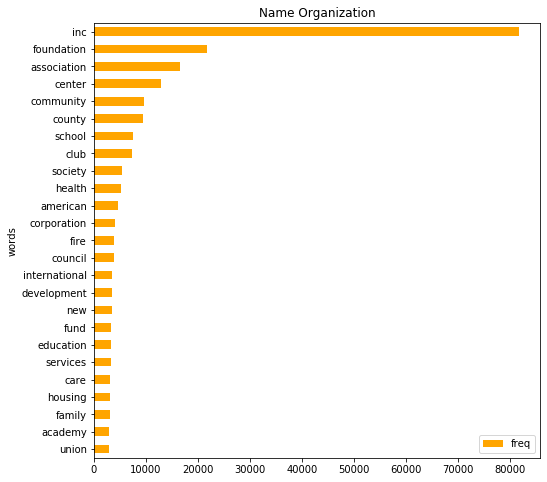

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
all_num.head(25).sort_values(by='freq').plot.barh(x='words', y='freq', ax=ax, color="orange")

ax.set_title('Name Organization')
plt.show()

Deleting by names seem to be difficult at the first sight. I will come back to the above in a bit. 

## Reducing Based on NTEE Code
From prelimiary and previous work, I am looking for organizations that are clearly not of interest such as credit union. Let's delete these rows.

In [63]:
pd.set_option('display.max_columns', 50)
df[df['name_org'].str.contains('Credit Union')]

ein                                           name_org  \
17       10079380.0                                 Cport Credit Union   
63       10196194.0                           Maine State Credit Union   
133      10213357.0                             Down East Credit Union   
142      10216328.0                             Evergreen Credit Union   
206      10248224.0                          Maine Credit Union League   
...             ...                                                ...   
201229  956064840.0                    El Monte Community Credit Union   
201327  956097220.0                   Printing Industries Credit Union   
201385  956111723.0                 Evangelical Christian Credit Union   
201459  956151756.0  California Center Credit Union C/O Credit Unio...   
201686  990039971.0                         Hawaii Credit Union League   

        tax_yr           city state  org_form.association  org_form.corp  \
17      2016.0       PORTLAND    ME                 False           True   
63      2016.0        AUGUSTA    ME                 False           True   
133     2016.0    BAILEYVILLE    ME                 False           True   
142     2017.0       PORTLAND    ME                 False           True   
206     2017.0       PORTLAND    ME                 False           True   
...        ...            ...   ...                   ...            ...   
201229  2016.0       El Monte    CA                 False           True   
201327  2016.0    Los Angeles    CA                 False           True   
201385  2017.0           Brea    CA                 False           True   
201459  2014.0  ANAHEIM HILLS    CA                 False          False   
201686  2017.0       HONOLULU    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
17                    False           False          1931       9472036.0   
63                    False           False          1935      16740223.0   
133                   False           False          2006      10506262.0   
142                   False           False          1951      11687004.0   
206                   False           False          1938       2359264.0   
...                     ...             ...           ...             ...   
201229                False           False          1956        994821.0   
201327                False           False          1957       1744353.0   
201385                False           False          1984      37066903.0   
201459                 True           False          1967        675673.0   
201686                False           False          1956       1186046.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
17                 9.0             81.0               8.0      9472036.0   
63                 7.0             85.0               7.0     16740223.0   
133                5.0             90.0               7.0     10506262.0   
142                9.0             83.0               9.0     11687004.0   
206               12.0              8.0              12.0      2359264.0   
...                ...              ...               ...            ...   
201229            10.0              7.0              10.0       994821.0   
201327             7.0              9.0               9.0      1744353.0   
201385            10.0            167.0              16.0     37066903.0   
201459             7.0              4.0              11.0       675673.0   
201686             7.0              7.0              31.0      1186046.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
17              8209737.0               1262299.0      188534687.0   
63             14406570.0               2333653.0      383246140.0   
133             9069893.0               1436369.0      165292140.0   
142            10072667.0               1614337.0      269528838.0   
206             2198218.0 

Looks like code W, Public & Societal Benefit, contains most of the credit union. We will remove code W and organizations that contain credit union.

In [72]:
df_backup=df.copy()
df=df[(~df['code_W']==1)]
df=df[(~df['name_org'].str.contains('Credit Union'))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186389 entries, 2 to 202319
Data columns (total 47 columns):
ein                       186389 non-null float64
name_org                  186389 non-null object
tax_yr                    186389 non-null float64
city                      186389 non-null object
state                     186389 non-null object
org_form.association      186389 non-null bool
org_form.corp             186389 non-null bool
org_form.other_form       186389 non-null bool
org_form.trust            186389 non-null bool
formation_yr              186389 non-null int32
gross_receipts            186389 non-null float64
voting_memb_ct            186389 non-null float64
employee_tot_ct           186389 non-null float64
volunteer_tot_ct          186389 non-null float64
rev_tot_curyr             186389 non-null float64
expense_tot_curyr         186389 non-null float64
rev_less_expense_curyr    186389 non-null float64
asset_tot_endyr           186389 non-null float64
asset_

In [73]:
df['name_org'].str.contains('Credit Union').sum()

0

In [74]:
(df['code_W']==1).sum()

0

In [75]:
df=df.drop(columns=['code_W'])

## Revisiting Name of Organization

In [76]:
df[df['name_org'].str.contains('Fund')]

ein                                           name_org  \
405      10361574.0                                      The Cleo Fund   
559      10430261.0                                 Maine Women'S Fund   
615      10461436.0                                   The Genesis Fund   
636      10473137.0                    Edward H Daveis Benevolent Fund   
723      10500910.0       Rotary Club Of Belfast Maine Charitable Fund   
...             ...                                                ...   
201901  990185994.0                          Tile Promotion Trust Fund   
202039  990257598.0                      Iron Workers Scholarship Fund   
202308  996010618.0  The Public Health Fund Of The Chamber Of Comme...   
202311  996011524.0     Charles R Kendall Scholarship & Education Fund   
202316  996014851.0   Hawaiian Civic Club Of Honolulu Scholarship Fund   

        tax_yr            city state  org_form.association  org_form.corp  \
405     2016.0  WEST KENNEBUNK    ME                 False           True   
559     2016.0        FALMOUTH    ME                 False           True   
615     2015.0       Brunswick    ME                 False           True   
636     2016.0       Ellsworth    ME                 False          False   
723     2017.0         BELFAST    ME                  True          False   
...        ...             ...   ...                   ...            ...   
201901  2016.0        MILILANI    HI                 False          False   
202039  2011.0         WAIPAHU    HI                 False           True   
202308  2014.0        HONOLULU    HI                 False          False   
202311  2017.0        Honolulu    HI                 False          False   
202316  2016.0        HONOLULU    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
405                   False           False          1978       1324864.0   
559                   False           False          1988       1002326.0   
615                   False           False          1991        686737.0   
636                   False            True          1946         73579.0   
723                   False           False          2005        240148.0   
...                     ...             ...           ...             ...   
201901                False            True          1969        161555.0   
202039                False           False          1989         38844.0   
202308                False            True          1901        460415.0   
202311                False            True          2001        735523.0   
202316                False           False          1955         73434.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
405                6.0              3.0             225.0      1305749.0   
559               13.0              4.0              42.0       523016.0   
615               11.0              6.0              12.0       686737.0   
636                3.0              0.0               3.0        73579.0   
723               12.0              0.0             400.0       208749.0   
...                ...              ...               ...            ...   
201901             3.0              0.0               3.0       118339.0   
202039            23.0              0.0              30.0        38844.0   
202308            38.0              0.0              38.0       119814.0   
202311             7.0              0.0              50.0       181463.0   
202316             3.0              0.0              30.0        43228.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
405              309722.0                996027.0        1605517.0   
559              493724.0                 29292.0        2694688.0   
615              782511.0                -95774.0       13901148.0   
636              119714.0                -46135.0        1998316.0   
723           

In [81]:
len(df[df['name_org'].str.contains('Trust Fund')])

218

In [82]:
df=df[(~df['name_org'].str.contains('Trust Fund'))]

In [83]:
len(df[df['name_org'].str.contains('Credit')])

60

In [84]:
df=df[(~df['name_org'].str.contains('Credit'))]

In [86]:
all_num.head(200)

words   freq
0              inc  81809
1       foundation  21769
2      association  16609
3           center  12980
4        community   9747
5           county   9412
6           school   7496
7             club   7313
8          society   5377
9           health   5174
10        american   4595
11     corporation   4037
12            fire   3847
13         council   3791
14   international   3510
15     development   3455
16             new   3434
17            fund   3330
18       education   3277
19        services   3258
20            care   3132
21         housing   3129
22          family   3037
23         academy   2973
24           union   2924
25       volunteer   2817
26       christian   2783
27           youth   2707
28            area   2662
29          valley   2659
30         service   2609
31       institute   2607
32              st   2606
33        national   2602
34        hospital   2592
35            home   2537
36          united   2433
37           child   2318
38          credit   2304
39         chamber   2301
40           house   2295
41         medical   2249
42        commerce   2021
43           north   2009
44           great   1998
45         college   1956
46         company   1948
47      university   1936
48        alliance   1914
49           trust   1874
50      ministries   1784
51          league   1769
52            city   1764
53          museum   1742
54            post   1736
55           state   1706
56         central   1704
57         america   1683
58        children   1620
59         chapter   1572
60      department   1552
61         project   1549
62          public   1523
63           order   1512
64          senior   1490
65        memorial   1489
66            arts   1461
67           south   1452
68           assoc   1444
69          rescue   1434
70            hope   1431
71             art   1428
72            corp   1417
73              co   1408
74             san   1402
75             dba   1393
76         network   1388
77            high   1383
78         library   1377
79         charter   1352
80          legion   1318
81        research   1266
82         florida   1258
83           lodge   1255
84            west   1251
85      historical   1246
86      california   1209
87           texas   1205
88            park   1189
89            life   1187
90            lake   1181
91          soccer   1158
92           group   1158
93        ministry   1144
94            york   1138
95       coalition   1122
96           river   1077
97          action   1077
98        resource   1065
99          friend   1064
100       regional   1051
101    educational   1039
102        theatre   1031
103        friends   1026
104        country   1022
105            way   1015
106       humanity    986
107        program    981
108        habitat    977
109     washington    974
110            boy    964
111        mission    951
112         church    949
113        booster    940
114       district    938
115           east    935
116   organization    921
117          young    914
118         jewish    912
119         animal    884
120        veteran    871
121           ohio    870
122         rotary    862
123        village    858
124       michigan    848
125    incorporate    844
126          girls    831
127    partnership    811
128          first    795
129         humane    791
130       athletic    785
131           food    782
132       virginia    780
133            usa    771
134       southern    764
135            bay    758
136         little    752
137     management    751
138        foreign    749
139            day    746
140           camp    738
141       economic    736
142        support    735
143       carolina    721
144     healthcare    719
145         bureau    714
146         cancer    712
147     benevolent    711
148          music    703
149          local    699
150          woman    696
151       business    690
152         island    686
153      

In [87]:
df[df['name_org'].str.contains('Order')]

ein                                           name_org  \
8        10027748.0   Benevolent & Protective Order Of Elks Lodge #188   
14       10061310.0                          Fraternal Order Of Eagles   
15       10063057.0                      Fraternal Order Of Eagles 804   
18       10095414.0  Independent Order Of Odd Fellows Grand Lodge O...   
27       10129660.0   Benevolent & Protective Order Of Elks Lodge #934   
...             ...                                                ...   
201682  990034655.0  Benevolent And Protective Order Of Elks Honolu...   
201712  990071357.0                   Independent Order Of Odd Fellows   
201766  990084961.0        Order Of The Eastern Star Harmony Chapter 4   
201793  990106373.0         Benevolent & Protective Order Of Elks 2230   
201930  990206893.0  Benevolent & Protective Order Of The Elks Of T...   

        tax_yr        city state  org_form.association  org_form.corp  \
8       2015.0    PORTLAND    ME                 False           True   
14      2014.0    PORTLAND    ME                 False           True   
15      2017.0   Biddeford    ME                 False          False   
18      2017.0      Auburn    ME                  True          False   
27      2017.0        BATH    ME                 False           True   
...        ...         ...   ...                   ...            ...   
201682  2017.0    HONOLULU    HI                  True          False   
201712  2013.0    HONOLULU    HI                 False           True   
201766  2017.0   EWA BEACH    HI                  True          False   
201793  2018.0      KAILUA    HI                  True          False   
201930  2018.0  KAILUAKONA    HI                 False          False   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
8                     False           False          1889        621787.0   
14                    False           False          2014       3139510.0   
15                     True           False          1975        561250.0   
18                    False           False          1844        683728.0   
27                    False           False          1908        543317.0   
...                     ...             ...           ...             ...   
201682                False           False          1901       4912552.0   
201712                False           False          1846       1732808.0   
201766                False           False          1911        371896.0   
201793                False           False          1961        249450.0   
201930                False           False          2018        291579.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
8                  5.0             10.0             100.0       154392.0   
14                 7.0             14.0              20.0      3131129.0   
15                11.0              5.0              15.0       561250.0   
18                 6.0              4.0              30.0       176879.0   
27                 9.0              8.0              40.0       360157.0   
...                ...              ...               ...            ...   
201682             9.0             86.0             225.0      2774140.0   
201712             5.0              0.0             203.0      1732808.0   
201766           226.0              0.0              25.0       249313.0   
201793            15.0             12.0             534.0       181595.0   
201930            11.0              0.0             205.0       100813.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
8                246321.0                -91929.0         316382.0   
14              3162333.0                -31204.0         910320.0   
15               434007.0                127243.0         809381.0   
18               222735.0                -45856.0        4403272.0   
27               301779.0                 58378.0         2495

In [91]:
all_num.iloc[200:400]

words  freq
200       committee   552
201          parent   546
202          jersey   543
203       fraternal   542
204            fair   540
205          sports   539
206      montessori   535
207          global   534
208      leadership   533
209         arizona   529
210        catholic   524
211             elk   524
212       auxiliary   520
213       ambulance   520
214        lutheran   518
215           women   515
216        employee   514
217           homes   513
218     scholarship   513
219            golf   512
220           santa   510
221           eagle   506
222           heart   503
223             phi   500
224    conservation   498
225       charities   496
226        cemetery   496
227      fraternity   496
228       emergency   493
229      assistance   490
230            help   489
231    neighborhood   486
232        columbus   481
233         science   481
234        citizens   475
235          kansas   474
236            good   472
237          oregon   471
238        cultural   468
239          agency   466
240           creek   462
241        building   455
242       southwest   453
243             los   452
244        festival   450
245          mental   449
246            band   447
247            kids   445
248             man   444
249           squad   443
250            live   442
251         shelter   442
252          social   442
253      initiative   442
254            fort   442
255        training   440
256            bank   438
257            iowa   437
258         chicago   437
259          states   436
260              la   435
261            girl   435
262            john   433
263           kappa   431
264             ltd   431
265      elementary   430
266       pregnancy   427
267         charity   425
268       childrens   422
269           human   421
270        veterans   417
271            ymca   416
272    professional   414
273           legal   414
274           hills   413
275           coast   412
276      technology   412
277        symphony   411
278          alumni   408
279           manor   408
280           grand   405
281            plan   404
282             aid   404
283        missouri   403
284         centers   401
285         baptist   401
286            beta   398
287            paul   396
288          region   396
289        industry   395
290         houston   391
291         eastern   391
292           green   391
293           mercy   389
294    preservation   385
295         justice   384
296           diego   383
297         special   380
298        township   380
299           urban   380
300             law   377
301            mary   376
302      counseling   376
303           saint   374
304      recreation   371
305       northeast   369
306      retirement   368
307     conservancy   366
308         capital   365
309        advocacy   362
310          people   361
311           sigma   359
312       tennessee   355
313          crisis   355
314      conference   354
315       orchestra   353
316        downtown   353
317        recovery   353
318        maryland   352
319          joseph   352
320             one   351
321        congress   350
322         alabama   350
323  rehabilitation   347
324          sister   347
325            casa   346
326              ii   344
327         angeles   343
328           rural   341
329            team   340
330       resources   339
331             arc   333
332         pacific   333
333         welfare   330
334         perform   328
335        football   327
336           abuse   327
337         student   327
338       louisiana   326
339     connecticut   324
340         nursing   323
341           yacht   323
342        delaware   322
343           gamma   322
344            hall   321
345        oklahoma   321
346          christ   319
347           point   316
348           ranch   315
349            blue   314
350         teacher   313
351        partners   312
352            star   312
353       

Benevolent & Protective Order of The Elks is an interesting group... They seem to offer volunteering nationally, so I will leave it in for now.

In [116]:
df[df['name_org'].str.contains('Bank')]

ein                                         name_org  tax_yr  \
46       10155360.0                        Maine Bankers Association  2016.0   
859      10545734.0                                Augusta Food Bank  2016.0   
1088     10656156.0        American College Of Bankruptcy Foundation  2016.0   
1801     20235648.0                New Hampshire Bankers Association  2017.0   
1833     20260158.0                           Strawbery Banke Museum  2017.0   
...             ...                                              ...     ...   
200355  954279479.0                      California Bankruptcy Forum  2018.0   
201271  956089611.0                               San Diego Eye Bank  2017.0   
201713  990073479.0                             Blood Bank Of Hawaii  2017.0   
202169  990315110.0                               Maui Food Bank Inc  2015.0   
202177  990317431.0  Kauai Food Bank Inc Kauai Independent Food Bank  2015.0   

                 city state  org_form.association  org_form.corp  \
46          Westbrook    ME                  True          False   
859           Augusta    ME                 False           True   
1088    STANARDSVILLE    VA                 False           True   
1801          CONCORD    NH                 False          False   
1833       PORTSMOUTH    NH                 False           True   
...               ...   ...                   ...            ...   
200355   Laguna Beach    CA                 False           True   
201271      SAN DIEGO    CA                 False           True   
201713       HONOLULU    HI                 False           True   
202169        WAILUKU    HI                 False           True   
202177          LIHUE    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
46                    False           False          1893       3174080.0   
859                   False           False          2001        531851.0   
1088                  False           False          2002        551898.0   
1801                   True           False          1892       1309454.0   
1833                  False           False          1967       3282384.0   
...                     ...             ...           ...             ...   
200355                False           False          1990        490191.0   
201271                False           False          1960       8850458.0   
201713                False           False          1941      21335206.0   
202169                False           False          1994       5678152.0   
202177                False           False          1994        770295.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
46                35.0             14.0              35.0      3174080.0   
859               19.0              4.0              30.0       526282.0   
1088              24.0              0.0              50.0       551898.0   
1801               9.0              5.0               9.0      1309454.0   
1833              26.0            106.0             260.0      3070964.0   
...                ...              ...               ...            ...   
200355            29.0              0.0             125.0       490191.0   
201271            15.0             92.0              34.0      6809416.0   
201713            23.0            174.0             164.0     18093874.0   
202169             9.0             14.0             964.0      5666247.0   
202177            10.0             10.0             325.0       761359.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
46              2981858.0                192222.0        1543015.0   
859              159140.0                367142.0         515890.0   
1088             507642.0                 44256.0        1445688.0   
1801            1207873.0                101581.0        2094048.0   
1833            3204942.0               -133978.0 

I look through all the NTEE codes and and names, and it seems like this is all I can really remove to have a large dataset. I will save this dataset, and I will further reduce based on the immediate needs of the app.

In [112]:
w= sa.create_engine(r'sqlite:///D:\Program_practices\Charity\open990database.sqlite')
df.to_sql('Large_clean', w, if_exists='replace', index=False)

In [120]:
df[df['code_K']==1]

ein                                         name_org  tax_yr  \
150      10217277.0                    Maine Farm Bureau Association  2017.0   
459      10375969.0                    Maine Aquaculture Association  2017.0   
623      10467869.0              Maine Aquaculture Innovation Center  2017.0   
666      10484793.0                                  Table Of Plenty  2016.0   
800      10528014.0                             Maine Farmland Trust  2017.0   
...             ...                                              ...     ...   
202003  990242181.0                                  Ka'Ala Farm Inc  2016.0   
202169  990315110.0                               Maui Food Bank Inc  2015.0   
202177  990317431.0  Kauai Food Bank Inc Kauai Independent Food Bank  2015.0   
202236  990344209.0                                    Aloha Harvest  2017.0   
202302  996009110.0                       Hawaii Cattlemen'S Council  2016.0   

             city state  org_form.association  org_form.corp  \
150       Augusta    ME                 False           True   
459     HALLOWELL    ME                  True          False   
623       WALPOLE    ME                 False           True   
666       BERWICK    ME                 False          False   
800       BELFAST    ME                 False           True   
...           ...   ...                   ...            ...   
202003    WAIANAE    HI                 False           True   
202169    WAILUKU    HI                 False           True   
202177      LIHUE    HI                 False           True   
202236   HONOLULU    HI                 False           True   
202302    KAMUELA    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
150                   False           False          1951        220375.0   
459                   False           False          1976        471010.0   
623                   False           False          1988        472985.0   
666                    True           False          1994         32207.0   
800                   False           False          1999       5785444.0   
...                     ...             ...           ...             ...   
202003                False           False          1983        162674.0   
202169                False           False          1994       5678152.0   
202177                False           False          1994        770295.0   
202236                False           False          1999       7315112.0   
202302                False           False          1959        410061.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
150             1138.0              3.0             125.0       220375.0   
459                9.0              3.0               9.0       439466.0   
623               12.0              1.0              12.0       394024.0   
666                9.0              0.0             250.0        32207.0   
800               15.0             41.0             196.0      3544167.0   
...                ...              ...               ...            ...   
202003             5.0             11.0              20.0       162674.0   
202169             9.0             14.0             964.0      5666247.0   
202177            10.0             10.0             325.0       761359.0   
202236            10.0              8.0             132.0      7274664.0   
202302            22.0              2.0              40.0       401063.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
150              215213.0                  5162.0        1531149.0   
459              266136.0                173330.0         444803.0   
623              279801.0                114223.0        1024741.0   
666               34140.0                 -1933.0          41589.0   
800             5592201.0              -2048034.0       28246734.0   
...                   ...   

# Data Cleaning (Part 2)
## Keeping Key Organizations
I will be taking the key organizations that are needed for the app, and I will go through the rest of the data to decide what organizations to include based on name, NTEE code, size of the organizations, and revenue/asset/expense.

In [122]:
''' Codes corresponds to
        'Arts, Culture & Humanities', 'Education', 'Environment', 'Animal-related',
          'Healthcare','Mental Health & Crisis Intervention', 'Voluntary Health Asso. & Med. Disciplines', 'Food, Agriculture & Nutrition',
           'Housing & Shelter', 'Public Safety, Disaster Preparedness & Relief','Recreation & Sports', 'Youth Development',
           'Community Improvement & Capacity Building', 'Religion-Related'
'''
s_df=df[(df['code_A']==1) | (df['code_B']==1) | (df['code_C']==1) | (df['code_D']==1) | 
        (df['code_E']==1) | (df['code_F']==1) | (df['code_G']==1) | (df['code_K']==1) |
        (df['code_L']==1) | (df['code_M']==1) | (df['code_N']==1) | (df['code_O']==1) | 
        (df['code_S']==1) | (df['code_X']==1) 
        ]
s_df


ein                                           name_org  \
3        10022320.0                               Augusta Country Club   
4        10022415.0                Kennebec Valley Chamber Of Commerce   
5        10024245.0                  Bangor Region Chamber Of Commerce   
6        10024645.0                          Bangor Symphony Orchestra   
8        10027748.0   Benevolent & Protective Order Of Elks Lodge #188   
...             ...                                                ...   
202308  996010618.0  The Public Health Fund Of The Chamber Of Comme...   
202311  996011524.0     Charles R Kendall Scholarship & Education Fund   
202313  996012377.0                       Planned Parenthood Of Hawaii   
202314  996012378.0                                         Hui No'Eau   
202316  996014851.0   Hawaiian Civic Club Of Honolulu Scholarship Fund   

        tax_yr        city state  org_form.association  org_form.corp  \
3       2013.0  MANCHESTER    ME                 False           True   
4       2016.0     Augusta    ME                 False           True   
5       2016.0      BANGOR    ME                 False           True   
6       2017.0      BANGOR    ME                 False           True   
8       2015.0    PORTLAND    ME                 False           True   
...        ...         ...   ...                   ...            ...   
202308  2014.0    HONOLULU    HI                 False          False   
202311  2017.0    Honolulu    HI                 False          False   
202313  2015.0     Seattle    WA                 False           True   
202314  2017.0     MAKAWAO    HI                 False           True   
202316  2016.0    HONOLULU    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
3                     False           False          1916       1695260.0   
4                     False           False          1932        549207.0   
5                     False           False          1911        679874.0   
6                     False           False          1896       1725601.0   
8                     False           False          1889        621787.0   
...                     ...             ...           ...             ...   
202308                False            True          1901        460415.0   
202311                False            True          2001        735523.0   
202313                False           False          1966        141666.0   
202314                False           False          1964       1823824.0   
202316                False           False          1955         73434.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
3                 12.0             75.0              32.0      1457148.0   
4                 23.0              6.0             250.0       531901.0   
5                 20.0              8.0             100.0       666852.0   
6                 17.0              6.0              50.0       935915.0   
8                  5.0             10.0             100.0       154392.0   
...                ...              ...               ...            ...   
202308            38.0              0.0              38.0       119814.0   
202311             7.0              0.0              50.0       181463.0   
202313            15.0              0.0              18.0       141666.0   
202314            17.0             37.0             100.0      1507955.0   
202316             3.0              0.0              30.0        43228.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
3               1452080.0                  5068.0         886328.0   
4                538418.0                 -6517.0         550635.0   
5                669202.0                 -2350.0         202601.0   
6                810315.0                125600.0        2139034.0   
8                246321.0                -91929.0         3163

## Deleting based on Key Words
Let's look at codes that are not included to make sure we are not missing crucial data

In [130]:
l_df=df[(df['code_H']==1) | (df['code_I']==1) | (df['code_J']==1) | (df['code_P']==1) | 
        (df['code_Q']==1) | (df['code_R']==1) | (df['code_T']==1) | (df['code_U']==1) |
        (df['code_V']==1) | (df['code_Y']==1) | (df['code_Z']==1)
        ]
l_df

ein                                           name_org  \
2        10019705.0  Ancient Free And Accepted Masons Of Maine Gran...   
14       10061310.0                          Fraternal Order Of Eagles   
15       10063057.0                      Fraternal Order Of Eagles 804   
18       10095414.0  Independent Order Of Odd Fellows Grand Lodge O...   
24       10124841.0                   Mt Pleasant Cemetery Corporation   
...             ...                                                ...   
202312  996012257.0                       Hawaii Island United Way Inc   
202315  996014447.0                            The Contemporary Museum   
202317  996015708.0                          Mililani Town Association   
202318  996035847.0                       Arcadia Memorial Irrev Trust   
202319  996057064.0                                 Wai Lan Yoga Trust   

        tax_yr            city state  org_form.association  org_form.corp  \
2       2017.0          Holden    ME                 False           True   
14      2014.0        PORTLAND    ME                 False           True   
15      2017.0       Biddeford    ME                 False          False   
18      2017.0          Auburn    ME                  True          False   
24      2016.0  SOUTH PORTLAND    ME                 False           True   
...        ...             ...   ...                   ...            ...   
202312  2017.0            HILO    HI                 False           True   
202315  2011.0        HONOLULU    HI                 False           True   
202317  2017.0        MILILANI    HI                 False           True   
202318  2016.0        HONOLULU    HI                 False          False   
202319  2016.0          KAILUA    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
2                     False           False          1820        581268.0   
14                    False           False          2014       3139510.0   
15                     True           False          1975        561250.0   
18                    False           False          1844        683728.0   
24                    False           False          1734         49251.0   
...                     ...             ...           ...             ...   
202312                False           False          1967       1264052.0   
202315                False           False          1967       1567360.0   
202317                False           False          1968      12084959.0   
202318                False            True          1977         85046.0   
202319                False           False          1989         48980.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
2                 11.0              6.0               9.0       303609.0   
14                 7.0             14.0              20.0      3131129.0   
15                11.0              5.0              15.0       561250.0   
18                 6.0              4.0              30.0       176879.0   
24                13.0              1.0              12.0        49251.0   
...                ...              ...               ...            ...   
202312            20.0              8.0              51.0      1111114.0   
202315            24.0             44.0             400.0      1079552.0   
202317             9.0            245.0              20.0      8234106.0   
202318             6.0              0.0               5.0        73428.0   
202319             3.0              0.0               3.0          106.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
2                328535.0                -24926.0        1743560.0   
14              3162333.0                -31204.0         910320.0   
15               434007.0                127243.0         809381.0   
18               222735.0                -45856.0        4403272.0   
24            

In [128]:
excl_name=Counter(' '.join((l_df['processed_name'])).split())
excl=pd.DataFrame.from_dict(excl_name, orient='index').reset_index().rename(
    columns={'index': 'words',0: 'freq'}).sort_values(by=['freq'], ascending=False).reset_index(drop=True)
pd.set_option('display.max_rows', 400)
excl.head(400)

words   freq
0               inc  30703
1        foundation   8844
2            center   5851
3       association   5254
4         community   4156
5            county   3830
6            family   2020
7          services   1757
8     international   1734
9              care   1592
10            child   1552
11           united   1493
12             fund   1493
13             club   1452
14          council   1435
15          service   1419
16           school   1363
17         american   1350
18          society   1337
19              new   1254
20      corporation   1143
21        christian   1140
22            order   1121
23             home   1093
24        institute   1063
25           health   1010
26        education   1008
27      development    999
28           senior    982
29              way    951
30            house    930
31             area    920
32         children    904
33            youth    897
34            lodge    855
35               st    849
36          housing    841
37         national    835
38           valley    833
39          project    724
40            great    721
41         research    718
42            trust    704
43            young    696
44             hope    688
45            north    681
46          academy    664
47         alliance    652
48             fire    637
49       ministries    632
50             life    607
51          central    606
52          hospice    586
53             city    585
54           action    585
55        volunteer    575
56          network    563
57        fraternal    533
58          america    531
59         resource    529
60            south    509
61           jewish    495
62              san    490
63          program    484
64            local    473
65           league    473
66              dba    472
67            state    472
68         cemetery    465
69             corp    461
70           police    455
71         ministry    450
72          chapter    439
73          mission    433
74          florida    423
75            union    421
76          medical    420
77            texas    415
78          company    414
79            woman    414
80             york    414
81            assoc    412
82             ymca    407
83            group    402
84        coalition    400
85       charitable    393
86       california    392
87            eagle    392
88       benevolent    390
89        pregnancy    386
90              day    385
91          support    383
92          village    378
93            legal    376
94          friends    376
95              man    370
96             west    365
97           friend    354
98         outreach    353
99         memorial    351
100             usa    350
101     independent    348
102              co    345
103          rescue    345
104    organization    344
105            free    339
106          living    338
107         chamber    335
108        citizens    333
109              de    329
110          global    323
111         justice    321
112             arc    321
113            post    318
114           women    315
115      protective    314
116          agency    312
117      washington    311
118            east    310
119           river    310
120          public    308
121     incorporate    305
122      federation    303
123            high    302
124            park    301
125       charities    300
126            help    296
127        columbus    294
128            ohio    293
129           world    293
130      department    290
131        advocacy    288
132            lake    286
133      university    283
134      assistance    281
135             bar    280
136        commerce    279
137          social    278
138        district    277
139          relief    271
140          accept    271
141        training    269
142           human    269
143     partnership    267
144         knights    266
145        carolina    266
146             elk    264
147            cas

In [135]:
(l_df['name_org'].str.contains('Order')).sum()

1121

In [137]:
l_df=l_df[(~l_df['name_org'].str.contains('Order'))]

In [139]:
(l_df['name_org'].str.contains('Elks')).sum()

148

In [141]:
l_df[(l_df['name_org'].str.contains('Elks'))]

ein                                           name_org  \
1007     10613056.0                  West St Lucie Elks Lodge 2823 Inc   
1663     20108531.0                 Concord Epsom Lodge Of Elks - 1210   
1673     20127315.0                          Dover Lodge Of Elks # 184   
1776     20225958.0                  Bpo Of Elks Of Usa 1831 Littleton   
2907     30104560.0                       Montpelier Lodge Of Elks 924   
2910     30104575.0                  St Albans Bpoe 1566 Elks Club Inc   
3055     30215644.0                            Newport Elks Lodge 2155   
3937     41079620.0            Hudson-Concord Lodge Of Elks No 959 Inc   
3978     41185560.0                         Bpoe Usa 1306 Clinton Elks   
4134     41917401.0       Wakefield Lodge Of Elks Bpoe Of Usa Inc 1276   
4687     42127422.0       Winchester Lodge Of Elks # 1445 Incorporated   
6813     43244615.0                Massachusetts Elks Charitable Trust   
8490     50251156.0                 West Warwick Lodge #1697 Bpoe Elks   
9228     60258938.0                          Putnam Lodge Of Elks #574   
9251     60333010.0                    New London Lodge Of Elks No 360   
9709     60758959.0                          Groton Lodge Of Elks 2163   
11363    66044436.0                   Middletown Elks Home Corporation   
13844   131548228.0          Elks National Veterans Service Commission   
14131   131739842.0                      Haverstraw Lodge 877 Bpo Elks   
18063   140573462.0                   Cohoes-Waterford Elks Lodge 1317   
18507   141582352.0                              Ellenville Elks Lodge   
19483   150243080.0                          Malone Lodge Of Elks 1303   
19507   150336814.0                        Herkimer Elks Lodge No 1439   
19912   160348421.0                               Bpo Elks Lockport Ny   
20834   161169948.0             Canajoharie Fort Plain Elks Lodge 2621   
22417   200023859.0              Elkader Childcare And Learning Center   
23741   200840435.0               Christian Outreach Program - Elkhorn   
30733   205597991.0                        Lake Oconee Elks Lodge 2849   
30836   205671437.0            New York Deer & Elk Farmers Association   
32695   210495594.0                      Bpo Elks Lakewood Lodge #1432   
32958   220764230.0                    Lambertville Elks Lodge No 1070   
33288   221667371.0         Benevolent Protective Elks Woodbridge 2116   
38030   230400860.0                                       Bpo Elks 134   
42774   237005557.0                  The Elks Club Of St Augustine Inc   
43795   237071154.0                                  Elk Hill Farm Inc   
45064   237130202.0                            Liberty Elks Lodge 2019   
45071   237130340.0                          Swanton Elks Lodge # 2642   
45252   237137942.0                           Riverhead Bpoe Elks 2044   
45495   237153243.0                    Alameda Elks Lodge No 1015 Bpoe   
46048   237184153.0             Elk Grove Adult Community Training Inc   
49991   237583777.0   Woburn Ma Lodge #908 Ben & Prot Ord Elks Usa Inc   
50097   240523810.0                              B P O Elks Lodge #200   
50101   240523870.0                        Renovo Bpo Elks Lodge # 334   
50115   240571126.0       Elks Club & Lodge Of State College 1600 Bpoe   
50422   250351050.0                              Apollo Elks Lodge 386   
50434   250351455.0                               Bpo Elks #223 Warren   
58579   263718342.0                       Elks National Foundation Inc   
65583   273802868.0                          Las Vegas Elks Helldorado   
67368   300160677.0                       Darke Elks Benevolence Group   
70287   311255886.0         Community Foundation Of Elkhart County Inc   
75614   340093770.0                                    Canton Elks #68   
78710   350173269.0          Bpoe Lodge No 1307 Rushville Indiana Elks   
78712   350173280.0                                       Bpo Elks 796   
78717   350173370.0 

In [142]:
l_df=l_df[(~l_df['name_org'].str.contains('Elks'))]

In [143]:
l_df=l_df[(~l_df['name_org'].str.contains('Trust'))]

In [144]:
l_df=l_df[(~l_df['name_org'].str.contains('Civil'))]

In [145]:
l_df=l_df[(~l_df['name_org'].str.contains('Bank'))]

In [148]:
l_df=l_df[(~l_df['processed_name'].str.contains('masonic'))]

In [150]:
(l_df['name_org'].str.contains('Fund')).sum()

1520

In [151]:
l_df=l_df[(~l_df['name_org'].str.contains('Fund'))]

In [152]:
l_df[(l_df['name_org'].str.contains('Aerie'))]

ein                                           name_org  \
3260     30318724.0                Fraternal Ord Of Eagles #4218 Aerie   
23117   200428876.0                      Asbury Eagles Club Aerie 4458   
26948   202966170.0                     Umatilla Eagles Aerie 4491 Inc   
81298   352336774.0  Laporte Auxiliary 2753 To Bayshore Aerie 2753 Foe   
86961   370152465.0                                  Eagles Aerie 0254   
176932  820120060.0                               Eagles Cda Aerie 486   
187171  911312683.0                Fraternal Oder Of Eagles 4122 Aerie   

        tax_yr          city state  org_form.association  org_form.corp  \
3260    2016.0        MILTON    VT                 False           True   
23117   2012.0        ASBURY    IA                 False           True   
26948   2017.0      UMATILLA    FL                 False           True   
81298   2017.0      LA PORTE    TX                 False           True   
86961   2015.0         ALTON    IL                 False           True   
176932  2017.0  COEUR DALENE    ID                 False           True   
187171  2015.0     SHORELINE    WA                  True          False   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
3260                  False           False          2000       1367946.0   
23117                 False           False          2007        233792.0   
26948                 False           False          2005        224000.0   
81298                 False           False          2008         12294.0   
86961                 False           False          1952        364547.0   
176932                False           False          1903        726941.0   
187171                False           False          1985        293009.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
3260               5.0             20.0              85.0       275707.0   
23117            400.0              0.0             400.0       135348.0   
26948            185.0              9.0              20.0       224000.0   
81298              4.0              0.0               5.0        12294.0   
86961             11.0              2.0              25.0       176755.0   
176932            15.0             28.0              23.0       256693.0   
187171            13.0              0.0              16.0       180829.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
3260             275431.0                   276.0         699569.0   
23117            104900.0                 30448.0         236915.0   
26948            200199.0                 23801.0         530010.0   
81298              9211.0                  3083.0           8065.0   
86961            231584.0                -54829.0        1208116.0   
176932           262803.0                 -6110.0        1107289.0   
187171           197990.0                -17161.0           3689.0   

        asset_net_endyr  local_chapt  code_A  code_B  code_C  code_D  code_E  \
3260           662156.0        False   False   False   False   False   False   
23117          231750.0        False   False   False   False   False   False   
26948          121115.0        False   False   False   False   False   False   
81298            8065.0        False   False   False   False   False   False   
86961         1092367.0         True   False   False   False   False   False   
176932        1106693.0        False   False   False   False   False   False   
187171           3689.0        False   False   False   False   False   False   

        code_F  code_G  code_H  code_I  code_J  code_K  code_L  code_M  \
3260     False   False   False   False   False   False   False   False   
23117    False   False   False   False   False   False   False   False   
26948    False   False   False   False   False   False   False   False   
81298    False   False   False   False   False   False   False   False   
86961    False   False  

In [153]:
l_df=l_df[(~l_df['name_org'].str.contains('Aerie'))]

In [156]:
(l_df['name_org'].str.contains('Lodge')).sum()

394

In [157]:
l_df=l_df[(~l_df['name_org'].str.contains('Lodge'))]

In [158]:
(l_df['name_org'].str.contains('Manor')).sum()

126

In [159]:
l_df=l_df[(~l_df['name_org'].str.contains('Manor'))]

In [160]:
l_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65033 entries, 24 to 202317
Data columns (total 46 columns):
ein                       65033 non-null float64
name_org                  65033 non-null object
tax_yr                    65033 non-null float64
city                      65033 non-null object
state                     65033 non-null object
org_form.association      65033 non-null bool
org_form.corp             65033 non-null bool
org_form.other_form       65033 non-null bool
org_form.trust            65033 non-null bool
formation_yr              65033 non-null int32
gross_receipts            65033 non-null float64
voting_memb_ct            65033 non-null float64
employee_tot_ct           65033 non-null float64
volunteer_tot_ct          65033 non-null float64
rev_tot_curyr             65033 non-null float64
expense_tot_curyr         65033 non-null float64
rev_less_expense_curyr    65033 non-null float64
asset_tot_endyr           65033 non-null float64
asset_net_endyr         

In [168]:
frames = [s_df, l_df]
df=pd.concat(frames)
df

ein                                          name_org  tax_yr  \
3        10022320.0                              Augusta Country Club  2013.0   
4        10022415.0               Kennebec Valley Chamber Of Commerce  2016.0   
5        10024245.0                 Bangor Region Chamber Of Commerce  2016.0   
6        10024645.0                         Bangor Symphony Orchestra  2017.0   
8        10027748.0  Benevolent & Protective Order Of Elks Lodge #188  2015.0   
...             ...                                               ...     ...   
202305  996010090.0              Hawaii Council On Economic Education  2017.0   
202309  996011281.0                             Napili Kai Foundation  2016.0   
202312  996012257.0                      Hawaii Island United Way Inc  2017.0   
202315  996014447.0                           The Contemporary Museum  2011.0   
202317  996015708.0                         Mililani Town Association  2017.0   

              city state  org_form.association  org_form.corp  \
3       MANCHESTER    ME                 False           True   
4          Augusta    ME                 False           True   
5           BANGOR    ME                 False           True   
6           BANGOR    ME                 False           True   
8         PORTLAND    ME                 False           True   
...            ...   ...                   ...            ...   
202305    HONOLULU    HI                 False           True   
202309     LAHAINA    HI                 False           True   
202312        HILO    HI                 False           True   
202315    HONOLULU    HI                 False           True   
202317    MILILANI    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
3                     False           False          1916       1695260.0   
4                     False           False          1932        549207.0   
5                     False           False          1911        679874.0   
6                     False           False          1896       1725601.0   
8                     False           False          1889        621787.0   
...                     ...             ...           ...             ...   
202305                False           False          2000        254071.0   
202309                False           False          1966        230363.0   
202312                False           False          1967       1264052.0   
202315                False           False          1967       1567360.0   
202317                False           False          1968      12084959.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
3                 12.0             75.0              32.0      1457148.0   
4                 23.0              6.0             250.0       531901.0   
5                 20.0              8.0             100.0       666852.0   
6                 17.0              6.0              50.0       935915.0   
8                  5.0             10.0             100.0       154392.0   
...                ...              ...               ...            ...   
202305            21.0              4.0              75.0       171384.0   
202309            10.0              0.0              30.0       229173.0   
202312            20.0              8.0              51.0      1111114.0   
202315            24.0             44.0             400.0      1079552.0   
202317             9.0            245.0              20.0      8234106.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
3               1452080.0                  5068.0         886328.0   
4                538418.0                 -6517.0         550635.0   
5                669202.0                 -2350.0         202601.0   
6                810315.0                125600.0        2139034.0   
8                246321.0                -91929.0         316382.0   
... 

In [169]:
df=df[(~df['name_org'].str.contains('Lodge'))]
df=df[(~df['name_org'].str.contains('Manor'))]
df=df[(~df['processed_name'].str.contains('masonic'))]
df=df[(~df['name_org'].str.contains('Aerie'))]
df

ein                                           name_org  \
3        10022320.0                               Augusta Country Club   
4        10022415.0                Kennebec Valley Chamber Of Commerce   
5        10024245.0                  Bangor Region Chamber Of Commerce   
6        10024645.0                          Bangor Symphony Orchestra   
9        10029480.0  Biddeford And Saco Chamber Of Commerce And Ind...   
...             ...                                                ...   
202305  996010090.0               Hawaii Council On Economic Education   
202309  996011281.0                              Napili Kai Foundation   
202312  996012257.0                       Hawaii Island United Way Inc   
202315  996014447.0                            The Contemporary Museum   
202317  996015708.0                          Mililani Town Association   

        tax_yr        city state  org_form.association  org_form.corp  \
3       2013.0  MANCHESTER    ME                 False           True   
4       2016.0     Augusta    ME                 False           True   
5       2016.0      BANGOR    ME                 False           True   
6       2017.0      BANGOR    ME                 False           True   
9       2017.0   Biddeford    ME                 False           True   
...        ...         ...   ...                   ...            ...   
202305  2017.0    HONOLULU    HI                 False           True   
202309  2016.0     LAHAINA    HI                 False           True   
202312  2017.0        HILO    HI                 False           True   
202315  2011.0    HONOLULU    HI                 False           True   
202317  2017.0    MILILANI    HI                 False           True   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
3                     False           False          1916       1695260.0   
4                     False           False          1932        549207.0   
5                     False           False          1911        679874.0   
6                     False           False          1896       1725601.0   
9                     False           False          1927        183721.0   
...                     ...             ...           ...             ...   
202305                False           False          2000        254071.0   
202309                False           False          1966        230363.0   
202312                False           False          1967       1264052.0   
202315                False           False          1967       1567360.0   
202317                False           False          1968      12084959.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
3                 12.0             75.0              32.0      1457148.0   
4                 23.0              6.0             250.0       531901.0   
5                 20.0              8.0             100.0       666852.0   
6                 17.0              6.0              50.0       935915.0   
9                 19.0              3.0               4.0       183721.0   
...                ...              ...               ...            ...   
202305            21.0              4.0              75.0       171384.0   
202309            10.0              0.0              30.0       229173.0   
202312            20.0              8.0              51.0      1111114.0   
202315            24.0             44.0             400.0      1079552.0   
202317             9.0            245.0              20.0      8234106.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
3               1452080.0                  5068.0         886328.0   
4                538418.0                 -6517.0         550635.0   
5                669202.0                 -2350.0         202601.0   
6                810315.0                125600.0        2139034.0   
9                208615.0                -24894.0          173

In [171]:
df.to_sql('temp', w, if_exists='replace', index=False)

In [363]:
query=''' SELECT *
FROM temp'''

df= pd.read_sql_query(query, w)

## Deleting Based on Size and Revenue

In [173]:
df.columns

Index(['ein', 'name_org', 'tax_yr', 'city', 'state', 'org_form.association',
       'org_form.corp', 'org_form.other_form', 'org_form.trust',
       'formation_yr', 'gross_receipts', 'voting_memb_ct', 'employee_tot_ct',
       'volunteer_tot_ct', 'rev_tot_curyr', 'expense_tot_curyr',
       'rev_less_expense_curyr', 'asset_tot_endyr', 'asset_net_endyr',
       'local_chapt', 'code_A', 'code_B', 'code_C', 'code_D', 'code_E',
       'code_F', 'code_G', 'code_H', 'code_I', 'code_J', 'code_K', 'code_L',
       'code_M', 'code_N', 'code_O', 'code_P', 'code_Q', 'code_R', 'code_S',
       'code_T', 'code_U', 'code_V', 'code_X', 'code_Y', 'code_Z',
       'processed_name'],
      dtype='object')

In [197]:
df=df.drop(columns=['asset_tot_endyr','expense_tot_curyr'])

In [198]:
df['volunteer_tot_ct'].describe()

count    1.807950e+05
mean     1.235018e+03
std      2.077084e+05
min      1.000000e+00
25%      1.000000e+01
50%      3.000000e+01
75%      1.000000e+02
max      8.000000e+07
Name: volunteer_tot_ct, dtype: float64

In [364]:
df=df.loc[df['volunteer_tot_ct'].quantile(0.99)>df['volunteer_tot_ct']]
df=df.loc[(df['rev_less_expense_curyr'].quantile(0.95)> df['rev_less_expense_curyr']) & (df['rev_less_expense_curyr'].quantile(.05)< df['rev_less_expense_curyr'])]
df=df.loc[(df['asset_net_endyr'].quantile(.95)> df['asset_net_endyr']) & (df['asset_net_endyr'].quantile(.05)< df['asset_net_endyr'])]
df=df.loc[df['rev_tot_curyr'].quantile(.95)> df['rev_tot_curyr']]
df=df.loc[df['gross_receipts'].quantile(.95)> df['gross_receipts']]
df=df.loc[df['voting_memb_ct'].quantile(.95)> df['voting_memb_ct']]
df=df.loc[df['employee_tot_ct'].quantile(.95)> df['employee_tot_ct']]

In [365]:
df.describe()

ein         tax_yr  org_form.association  org_form.corp  \
count  1.175340e+05  117534.000000         117534.000000  117534.000000   
mean   4.545110e+08    2015.742134              0.042132       0.925298   
std    2.506583e+08       1.839799              0.200892       0.262911   
min    1.002242e+07    2010.000000              0.000000       0.000000   
25%    2.517929e+08    2015.000000              0.000000       1.000000   
50%    4.211010e+08    2016.000000              0.000000       1.000000   
75%    6.113777e+08    2017.000000              0.000000       1.000000   
max    9.960149e+08    2018.000000              1.000000       1.000000   

       org_form.other_form  org_form.trust   formation_yr  gross_receipts  \
count        117534.000000   117534.000000  117534.000000    1.175340e+05   
mean              0.015706        0.007436    1988.962836    5.443900e+05   
std               0.124336        0.085912      25.561650    5.760849e+05   
min               0.000000        0.000000    1195.000000    0.000000e+00   
25%               0.000000        0.000000    1979.000000    1.836368e+05   
50%               0.000000        0.000000    1996.000000    3.304165e+05   
75%               0.000000        0.000000    2007.000000    6.946710e+05   
max               1.000000        1.000000    2018.000000    3.123904e+06   

       voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
count   117534.000000    117534.000000     117534.000000   1.175340e+05   
mean         9.633723         6.149693         98.658244   4.833456e+05   
std          5.132101         9.687184        259.517529   5.324680e+05   
min          0.000000         0.000000          1.000000  -3.956470e+05   
25%          6.000000         0.000000         10.000000   1.447982e+05   
50%          9.000000         2.000000         25.000000   2.896005e+05   
75%         13.000000         8.000000         80.000000   6.125855e+05   
max         25.000000        46.000000       3879.000000   3.123423e+06   

       expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
count       1.175340e+05            1.175340e+05     1.175340e+05   
mean        4.487528e+05            3.459281e+04     8.781903e+05   
std         5.042734e+05            1.452990e+05     2.450658e+06   
min        -2.665840e+05           -4.337570e+05    -1.635610e+05   
25%         1.276552e+05           -1.549400e+04     1.096122e+05   
50%         2.683560e+05            8.133500e+03     3.595100e+05   
75%         5.672732e+05            5.345475e+04     9.593972e+05   
max         3.457038e+06            1.323291e+06     5.788502e+08   

       asset_net_endyr    local_chapt         code_A         code_B  \
count     1.175340e+05  117534.000000  117534.000000  117534.000000   
mean      6.922091e+05       0.034407       0.085686       0.108147   
std       1.083689e+06       0.182273       0.279901       0.310568   
min      -1.223800e+04       0.000000       0.000000       0.000000   
25%       8.553050e+04       0.000000       0.000000       0.000000   
50%       2.869360e+05       0.000000       0.000000       0.000000   
75%       7.912245e+05       0.000000       0.000000       0.000000   
max       7.851442e+06       1.000000       1.000000       1.000000   

              code_C         code_D         code_E         code_F  \
count  117534.000000  117534.000000  117534.000000  117534.000000   
mean        0.023449       0.022504       0.046786       0.017033   
std         0.151324       0.148317       0.211182       0.129396   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              code_G         code_H         code_I         code_J  \
count  117534.000

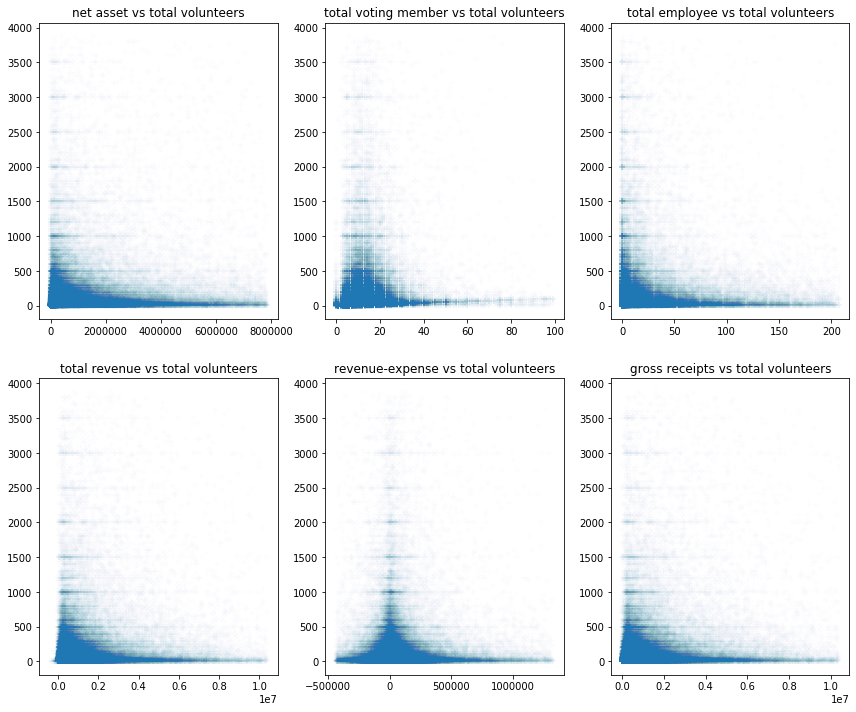

In [205]:
level=0.01
plt.subplot(331)
plt.scatter( df['asset_net_endyr'],df['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('net asset vs total volunteers')

plt.subplot(332)
plt.scatter( df['voting_memb_ct'], df['volunteer_tot_ct'],  marker='+', alpha=level)
plt.title('total voting member vs total volunteers')

plt.subplot(333)
plt.scatter(df['employee_tot_ct'], df['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('total employee vs total volunteers')

plt.subplot(334)
plt.scatter(df['rev_tot_curyr'], df['volunteer_tot_ct'],  marker='+', alpha=level)
plt.title('total revenue vs total volunteers')

plt.subplot(335)
plt.scatter(df['rev_less_expense_curyr'], df['volunteer_tot_ct'],marker='+', alpha=level)
plt.title('revenue-expense vs total volunteers')

plt.subplot(336)
plt.scatter(df['gross_receipts'], df['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('gross receipts vs total volunteers')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [207]:
sdf=df.loc[100>df['volunteer_tot_ct']]

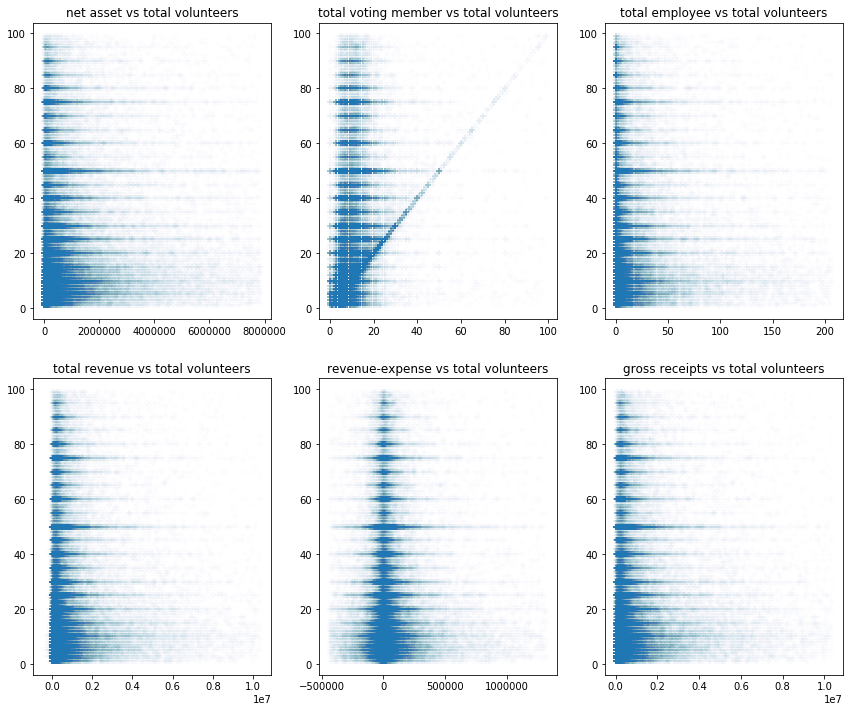

In [209]:
level=0.01
plt.subplot(331)
plt.scatter(sdf['asset_net_endyr'],sdf['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('net asset vs total volunteers')

plt.subplot(332)
plt.scatter(sdf['voting_memb_ct'], sdf['volunteer_tot_ct'],  marker='+', alpha=level)
plt.title('total voting member vs total volunteers')

plt.subplot(333)
plt.scatter(sdf['employee_tot_ct'], sdf['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('total employee vs total volunteers')

plt.subplot(334)
plt.scatter(sdf['rev_tot_curyr'], sdf['volunteer_tot_ct'],  marker='+', alpha=level)
plt.title('total revenue vs total volunteers')

plt.subplot(335)
plt.scatter(sdf['rev_less_expense_curyr'], sdf['volunteer_tot_ct'],marker='+', alpha=level)
plt.title('revenue-expense vs total volunteers')

plt.subplot(336)
plt.scatter(sdf['gross_receipts'], sdf['volunteer_tot_ct'], marker='+', alpha=level)
plt.title('gross receipts vs total volunteers')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [217]:
bodf=df[(df['code_B']==1) | (df['code_O']==1)]
bodf=bodf.loc[100>=df['volunteer_tot_ct']]

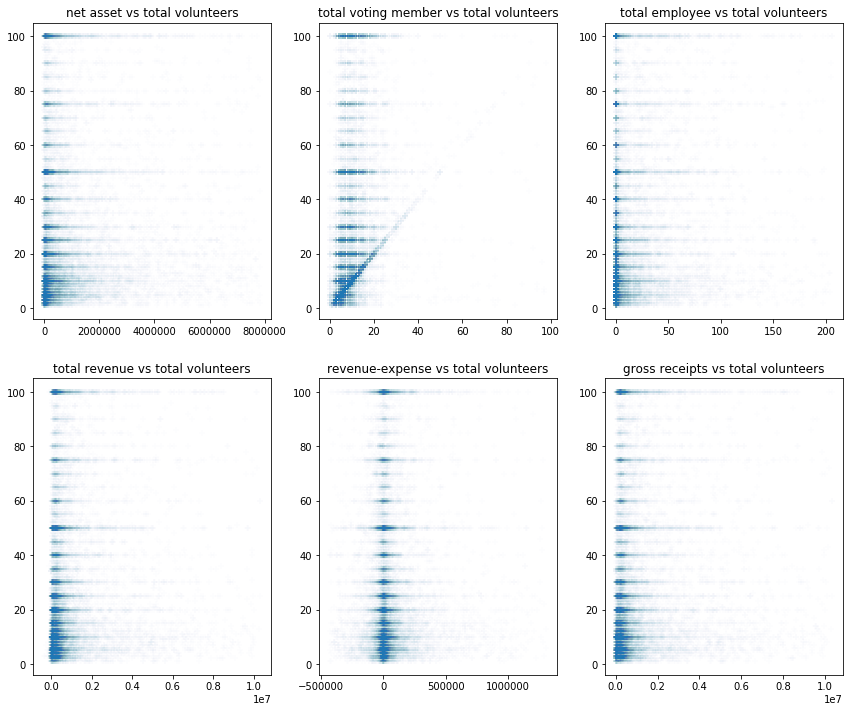

In [218]:
y=bodf['volunteer_tot_ct']
x=bodf
level=0.01
plt.subplot(331)
plt.scatter(x['asset_net_endyr'],y, marker='+', alpha=level)
plt.title('net asset vs total volunteers')

plt.subplot(332)
plt.scatter(x['voting_memb_ct'], y,  marker='+', alpha=level)
plt.title('total voting member vs total volunteers')

plt.subplot(333)
plt.scatter(x['employee_tot_ct'], y, marker='+', alpha=level)
plt.title('total employee vs total volunteers')

plt.subplot(334)
plt.scatter(x['rev_tot_curyr'], y,  marker='+', alpha=level)
plt.title('total revenue vs total volunteers')

plt.subplot(335)
plt.scatter(x['rev_less_expense_curyr'], y,marker='+', alpha=level)
plt.title('revenue-expense vs total volunteers')

plt.subplot(336)
plt.scatter(x['gross_receipts'], y, marker='+', alpha=level)
plt.title('gross receipts vs total volunteers')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

## Picking out the keywords

In [366]:
excl_name=Counter(' '.join((df['processed_name'])).split())
excl=pd.DataFrame.from_dict(excl_name, orient='index').reset_index().rename(
    columns={'index': 'words',0: 'freq'}).sort_values(by=['freq'], ascending=False).reset_index(drop=True)
pd.set_option('display.max_rows', 400)
excl.head(400)

words   freq
0              inc  50719
1       foundation  14340
2      association  11097
3           center   7758
4           county   6510
5             club   5153
6        community   5141
7          society   3838
8           school   3793
9             fire   3046
10   international   2497
11       volunteer   2283
12         council   2267
13     corporation   2157
14       education   2138
15     development   2039
16           youth   2036
17             new   2027
18        american   2012
19          health   1868
20            area   1822
21         chamber   1761
22         housing   1652
23          family   1652
24          valley   1605
25           house   1569
26        commerce   1544
27            care   1526
28      ministries   1489
29       institute   1451
30        services   1367
31           child   1359
32          league   1357
33        national   1355
34       christian   1340
35          united   1323
36         service   1307
37         academy   1276
38         company   1269
39        alliance   1260
40              st   1256
41           north   1242
42      department   1190
43          rescue   1190
44         chapter   1170
45         project   1169
46         library   1130
47            hope   1126
48           great   1101
49           assoc   1088
50          museum   1088
51      historical   1083
52            city   1077
53            fund   1073
54            arts   1021
55          soccer   1015
56            home   1014
57              co    997
58            high    987
59        ministry    962
60          public    941
61         network    938
62             art    932
63         medical    926
64         central    925
65          senior    917
66            corp    889
67           south    875
68          friend    869
69        children    853
70       coalition    840
71         america    840
72         booster    836
73         friends    828
74            life    828
75           state    825
76             dba    818
77             san    804
78            lake    801
79        humanity    797
80          rotary    795
81         habitat    789
82            park    787
83        resource    779
84            west    758
85          animal    719
86        research    712
87         college    708
88        memorial    708
89           texas    706
90           river    704
91        hospital    701
92      california    697
93    organization    694
94        district    683
95         theatre    681
96         florida    667
97         mission    666
98             way    641
99         program    638
100    educational    634
101          group    626
102       athletic    621
103         church    620
104         humane    606
105           york    601
106          trust    585
107         little    580
108     washington    566
109           east    562
110       outreach    557
111         hockey    537
112       baseball    522
113    incorporate    521
114          music    521
115     university    512
116          alpha    512
117          delta    511
118         bureau    508
119          first    508
120           farm    507
121            big    505
122       regional    504
123         relief    502
124         cancer    490
125        support    489
126            pta    488
127           ohio    488
128         action    483
129    partnership    476
130       michigan    471
131            usa    471
132           assn    470
133            bay    463
134           food    462
135       business    459
136       virginia    456
137         parent    454
138       economic    453
139           camp    449
140          woman    447
141         island    446
142        village    445
143       mountain    442
144         junior    437
145       southern    430
146     management    429
147       heritage    426
148       cemetery    424
149             de    424
150            day    422
151      ambulance    420
152         clinic    420
153      

Original set
kdf= df[(df['processed_name'].str.contains('school')) | (df['processed_name'].str.contains('community')) |
   (df['processed_name'].str.contains('services')) | (df['processed_name'].str.contains('service')) |
   (df['processed_name'].str.contains('christian')) | (df['processed_name'].str.contains('senior')) |
   (df['processed_name'].str.contains('house')) | (df['processed_name'].str.contains('volunteer')) |
   (df['processed_name'].str.contains('ministry')) | (df['processed_name'].str.contains('jewish')) |
   (df['processed_name'].str.contains('outreach')) | (df['processed_name'].str.contains('rescue')) |
  (df['processed_name'].str.contains('catholic')) | (df['processed_name'].str.contains('charity')) |
   (df['processed_name'].str.contains('crisis')) | (df['processed_name'].str.contains('educational')) |
   (df['processed_name'].str.contains('shelter')) | (df['processed_name'].str.contains('animal')) |
   (df['processed_name'].str.contains('lutheran')) | (df['processed_name'].str.contains('alpha')) |
   (df['processed_name'].str.contains('delta')) | (df['processed_name'].str.contains('thrift')) |
   (df['processed_name'].str.contains('schools')) | (df['processed_name'].str.contains('baptist')) |
   (df['processed_name'].str.contains('charities')) | (df['processed_name'].str.contains('charitable')) |
    (df['processed_name'].str.contains('fraternity')) | (df['processed_name'].str.contains('methodist')) |
   (df['processed_name'].str.contains('presbyterian')) | (df['processed_name'].str.contains('christ'))]
kdf

In [367]:
kdf= df[(df['processed_name'].str.contains('school')) | (df['processed_name'].str.contains('community')) |
   (df['processed_name'].str.contains('christian')) | (df['processed_name'].str.contains('senior')) |
   (df['processed_name'].str.contains('house')) | (df['processed_name'].str.contains('volunteer')) |
   (df['processed_name'].str.contains('ministry')) | (df['processed_name'].str.contains('jewish')) |
   (df['processed_name'].str.contains('outreach')) | (df['processed_name'].str.contains('rescue')) |
  (df['processed_name'].str.contains('catholic')) | (df['processed_name'].str.contains('charity')) |
   (df['processed_name'].str.contains('crisis')) | (df['processed_name'].str.contains('educational')) |
   (df['processed_name'].str.contains('shelter')) | (df['processed_name'].str.contains('animal')) |
   (df['processed_name'].str.contains('lutheran')) | 
   (df['processed_name'].str.contains('thrift')) |
   (df['processed_name'].str.contains('schools')) | (df['processed_name'].str.contains('baptist')) |
   (df['processed_name'].str.contains('charities')) | 
    (df['processed_name'].str.contains('fraternity')) | (df['processed_name'].str.contains('methodist')) |
   (df['processed_name'].str.contains('presbyterian')) | (df['processed_name'].str.contains('christ'))]
kdf

ein                                           name_org  \
24       10153128.0                   Greater Rumford Community Center   
77       10212545.0  Maine State Society For The Protection Of Animals   
123      10245341.0  Cornelia Warren Community Association C/O Tom ...   
125      10246546.0                          The Ruggles House Society   
156      10272150.0              Harbor House Community Service Center   
...             ...                                                ...   
180767  990339218.0          Joey'S Feline Friends A Rescue Foundation   
180775  990347476.0  Friends Of The Volcano School Or Arts And Scie...   
180777  990350803.0       Waianae Community Re-Development Corporation   
180780  990352548.0  Catholic Charities Housing Development Corpora...   
180782  990353649.0  Waipahu Community Adult Day Health And Youth D...   

        tax_yr              city state  org_form.association  org_form.corp  \
24      2017.0           RUMFORD    ME                     0              1   
77      2013.0     SOUTH WINDHAM    ME                     0              1   
123     2015.0          FALMOUTH    ME                     0              1   
125     2015.0    COLUMBIA FALLS    ME                     1              0   
156     2017.0  Southwest Harbor    ME                     0              1   
...        ...               ...   ...                   ...            ...   
180767  2014.0           KANEOHE    HI                     0              1   
180775  2013.0           VOLCANO    HI                     0              1   
180777  2014.0           WAIANAE    HI                     0              1   
180780  2017.0          HONOLULU    HI                     0              1   
180782  2016.0           WAIPAHU    HI                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
24                        0               0          1911        235375.0   
77                        0               0          1975        755029.0   
123                       0               0          1945        213630.0   
125                       0               0          1980        275156.0   
156                       0               0          1965       1041420.0   
...                     ...             ...           ...             ...   
180767                    0               0          1999        214271.0   
180775                    0               0          2000        104669.0   
180777                    0               0          2000       2763201.0   
180780                    0               0          1999        323380.0   
180782                    0               0          2001        172211.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
24                 5.0              4.0              75.0       209268.0   
77                12.0             16.0             179.0       755029.0   
123               12.0              0.0              12.0       103949.0   
125               23.0              3.0               6.0        58788.0   
156                9.0             36.0             200.0       976831.0   
...                ...              ...               ...            ...   
180767             4.0              0.0              12.0       214271.0   
180775             4.0              0.0               4.0       104669.0   
180777            11.0             26.0            1700.0      2167355.0   
180780             8.0              0.0               6.0       323380.0   
180782             6.0              0.0               6.0       172211.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
24               163068.0                 46200.0          47880.0   
77               962073.0               -207044.0        5562900.0   
123               47916.0                 56033.0        3483427.0   
125               49872.0                  8916.0        122

In [368]:
kdf['volunteer_tot_ct'].describe()

count    21305.000000
mean        89.597278
std        239.726251
min          1.000000
25%         10.000000
50%         25.000000
75%         75.000000
max       3800.000000
Name: volunteer_tot_ct, dtype: float64

In [372]:
kdf=kdf[kdf['volunteer_tot_ct'].quantile(0.99)>kdf['volunteer_tot_ct']]
kdf

ein                                           name_org  \
24       10153128.0                   Greater Rumford Community Center   
77       10212545.0  Maine State Society For The Protection Of Animals   
123      10245341.0  Cornelia Warren Community Association C/O Tom ...   
125      10246546.0                          The Ruggles House Society   
156      10272150.0              Harbor House Community Service Center   
...             ...                                                ...   
180762  990332316.0  International Christian Schools Kona Hawaii Ca...   
180767  990339218.0          Joey'S Feline Friends A Rescue Foundation   
180775  990347476.0  Friends Of The Volcano School Or Arts And Scie...   
180780  990352548.0  Catholic Charities Housing Development Corpora...   
180782  990353649.0  Waipahu Community Adult Day Health And Youth D...   

        tax_yr              city state  org_form.association  org_form.corp  \
24      2017.0           RUMFORD    ME                     0              1   
77      2013.0     SOUTH WINDHAM    ME                     0              1   
123     2015.0          FALMOUTH    ME                     0              1   
125     2015.0    COLUMBIA FALLS    ME                     1              0   
156     2017.0  Southwest Harbor    ME                     0              1   
...        ...               ...   ...                   ...            ...   
180762  2018.0       KAILUA KONA    HI                     0              0   
180767  2014.0           KANEOHE    HI                     0              1   
180775  2013.0           VOLCANO    HI                     0              1   
180780  2017.0          HONOLULU    HI                     0              1   
180782  2016.0           WAIPAHU    HI                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
24                        0               0          1911        235375.0   
77                        0               0          1975        755029.0   
123                       0               0          1945        213630.0   
125                       0               0          1980        275156.0   
156                       0               0          1965       1041420.0   
...                     ...             ...           ...             ...   
180762                    1               0          1982        449368.0   
180767                    0               0          1999        214271.0   
180775                    0               0          2000        104669.0   
180780                    0               0          1999        323380.0   
180782                    0               0          2001        172211.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
24                 5.0              4.0              75.0       209268.0   
77                12.0             16.0             179.0       755029.0   
123               12.0              0.0              12.0       103949.0   
125               23.0              3.0               6.0        58788.0   
156                9.0             36.0             200.0       976831.0   
...                ...              ...               ...            ...   
180762             9.0             10.0              14.0       431907.0   
180767             4.0              0.0              12.0       214271.0   
180775             4.0              0.0               4.0       104669.0   
180780             8.0              0.0               6.0       323380.0   
180782             6.0              0.0               6.0       172211.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
24               163068.0                 46200.0          47880.0   
77               962073.0               -207044.0        5562900.0   
123               47916.0                 56033.0        3483427.0   
125               49872.0                  8916.0        122

In [374]:
kdf['volunteer_tot_ct'].describe()

count    21091.000000
mean        70.268076
std        126.153227
min          1.000000
25%         10.000000
50%         25.000000
75%         70.000000
max       1168.000000
Name: volunteer_tot_ct, dtype: float64

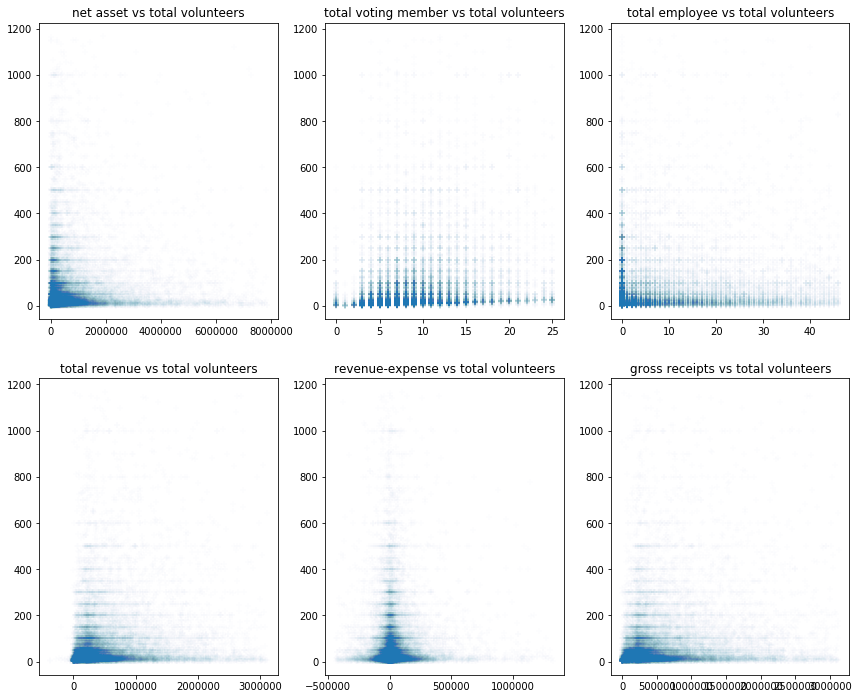

In [373]:
y=kdf['volunteer_tot_ct']
x=kdf
level=0.01
plt.subplot(331)
plt.scatter(x['asset_net_endyr'],y, marker='+', alpha=level)
plt.title('net asset vs total volunteers')

plt.subplot(332)
plt.scatter(x['voting_memb_ct'], y,  marker='+', alpha=level)
plt.title('total voting member vs total volunteers')

plt.subplot(333)
plt.scatter(x['employee_tot_ct'], y, marker='+', alpha=level)
plt.title('total employee vs total volunteers')

plt.subplot(334)
plt.scatter(x['rev_tot_curyr'], y,  marker='+', alpha=level)
plt.title('total revenue vs total volunteers')

plt.subplot(335)
plt.scatter(x['rev_less_expense_curyr'], y,marker='+', alpha=level)
plt.title('revenue-expense vs total volunteers')

plt.subplot(336)
plt.scatter(x['gross_receipts'], y, marker='+', alpha=level)
plt.title('gross receipts vs total volunteers')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [306]:
kdf.describe()

ein        tax_yr  org_form.association  org_form.corp  \
count  2.620800e+04  26208.000000          26208.000000   26208.000000   
mean   4.571001e+08   2015.872672              0.032280       0.935172   
std    2.492859e+08      1.779891              0.176747       0.246226   
min    1.015313e+07   2010.000000              0.000000       0.000000   
25%    2.516445e+08   2016.000000              0.000000       1.000000   
50%    4.309127e+08   2017.000000              0.000000       1.000000   
75%    6.117155e+08   2017.000000              0.000000       1.000000   
max    9.903699e+08   2018.000000              1.000000       1.000000   

       org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
count         26208.000000    26208.000000  26208.000000    2.620800e+04   
mean              0.018315        0.005533   1987.302885    1.069666e+06   
std               0.134091        0.074177     24.680279    1.602787e+06   
min               0.000000        0.000000   1780.000000    0.000000e+00   
25%               0.000000        0.000000   1976.000000    2.122745e+05   
50%               0.000000        0.000000   1994.000000    4.289225e+05   
75%               0.000000        0.000000   2005.000000    1.152902e+06   
max               1.000000        1.000000   2018.000000    1.036672e+07   

       voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
count    26208.000000     26208.000000      26208.000000   2.620800e+04   
mean        10.600313        18.502328        107.393544   9.887998e+05   
std          8.376720        32.982618        274.237979   1.546730e+06   
min          0.000000         0.000000          1.000000  -3.732770e+05   
25%          6.000000         0.000000         11.000000   1.824210e+05   
50%          9.000000         4.000000         30.000000   3.801560e+05   
75%         13.000000        21.000000         90.000000   1.022439e+06   
max         99.000000       206.000000       3800.000000   1.036672e+07   

       expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
count       2.620800e+04            2.620800e+04     2.620800e+04   
mean        9.383827e+05            5.041702e+04     1.470500e+06   
std         1.498192e+06            1.817717e+05     4.755417e+06   
min         0.000000e+00           -4.335820e+05    -6.761000e+03   
25%         1.592412e+05           -1.850325e+04     1.750288e+05   
50%         3.507200e+05            1.126450e+04     5.892600e+05   
75%         9.593482e+05            7.312950e+04     1.633448e+06   
max         1.052179e+07            1.321564e+06     5.788502e+08   

       asset_net_endyr   local_chapt        code_A        code_B  \
count     2.620800e+04  26208.000000  26208.000000  26208.000000   
mean      9.952300e+05      0.020337      0.033616      0.230960   
std       1.397499e+06      0.141154      0.180241      0.421455   
min      -1.223800e+04      0.000000      0.000000      0.000000   
25%       1.286270e+05      0.000000      0.000000      0.000000   
50%       4.448340e+05      0.000000      0.000000      0.000000   
75%       1.207800e+06      0.000000      0.000000      0.000000   
max       7.851809e+06      1.000000      1.000000      1.000000   

             code_C        code_D        code_E        code_F        code_G  \
count  26208.000000  26208.000000  26208.000000  26208.000000  26208.000000   
mean       0.003816      0.037737      0.049565      0.017361      0.006372   
std        0.061654      0.190562      0.217049      0.130615      0.079572   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             code_H        code_I        

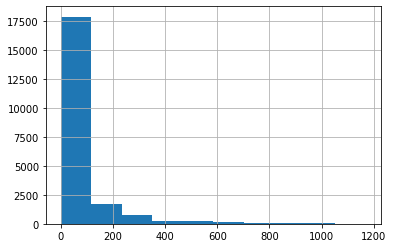

In [375]:
kdf['volunteer_tot_ct'].hist()

## Deleting based on Ntee code

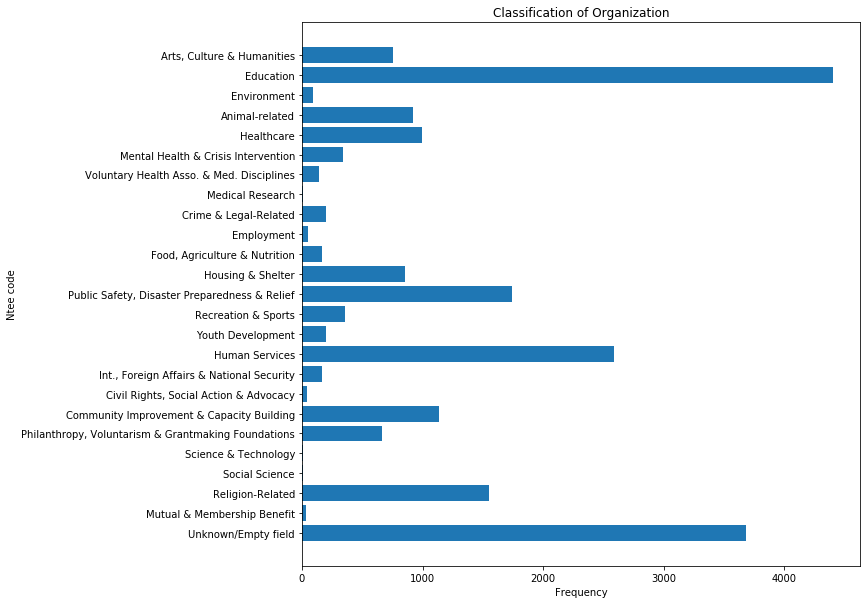

In [376]:
ntee_code=kdf[['code_A', 'code_B', 'code_C', 'code_D',
              'code_E', 'code_F', 'code_G', 'code_H', 
              'code_I', 'code_J', 'code_K','code_L', 
              'code_M', 'code_N', 'code_O', 'code_P', 
              'code_Q', 'code_R','code_S', 
              'code_T', 'code_U', 'code_V', 
              'code_X', 'code_Y', 'code_Z']]
ntee_code=ntee_code.sum()
objects = ('Arts, Culture & Humanities', 'Education', 'Environment', 'Animal-related',
          'Healthcare','Mental Health & Crisis Intervention', 'Voluntary Health Asso. & Med. Disciplines', 'Medical Research',
          'Crime & Legal-Related', 'Employment','Food, Agriculture & Nutrition','Housing & Shelter',
          'Public Safety, Disaster Preparedness & Relief','Recreation & Sports', 'Youth Development','Human Services',
          'Int., Foreign Affairs & National Security', 'Civil Rights, Social Action & Advocacy', 'Community Improvement & Capacity Building',
          'Philanthropy, Voluntarism & Grantmaking Foundations', 'Science & Technology','Social Science',
          'Religion-Related', 'Mutual & Membership Benefit', 'Unknown/Empty field')
y_pos = np.arange(len(objects))

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_pos, ntee_code, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()
plt.ylabel('Ntee code')
plt.xlabel('Frequency')
plt.title('Classification of Organization')
plt.show()

In [377]:
kdf[kdf['code_E']==1]

ein                                           name_org  \
305      10379686.0                Ronald Mcdonald House Of Bangor Inc   
384      10448263.0       Ronald Mcdonald House Charities Of Maine Inc   
599      10576945.0                Goodwin Community Health Center Inc   
671      10637920.0   The Medical Staff Of Parkview Community Hospital   
807      10759974.0      Thousand Islands Emergency Rescue Service Inc   
...             ...                                                ...   
114673  954451418.0  Wholistic Midwifery School Of Southern California   
114949  954791296.0                   Kids Community Clinic Of Burbank   
115011  954867562.0                   Institute For Community Pharmacy   
115136  956096710.0              Redlands Community Hospital Auxiliary   
115298  956533976.0  Auxiliary Of Hoag Memorial Hospital Presbyteri...   

        tax_yr           city state  org_form.association  org_form.corp  \
305     2014.0         Bangor    ME                     0              1   
384     2017.0       Portland    ME                     0              1   
599     2010.0      BRUNSWICK    GA                     0              1   
671     2014.0      RIVERSIDE    CA                     0              1   
807     2015.0        CLAYTON    NY                     0              1   
...        ...            ...   ...                   ...            ...   
114673  2016.0    Los Angeles    CA                     0              1   
114949  2014.0       VALENCIA    CA                     0              1   
115011  2011.0      LA CANADA    CA                     0              1   
115136  2017.0       REDLANDS    CA                     0              1   
115298  2017.0  NEWPORT BEACH    CA                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
305                       0               0          1983       1572232.0   
384                       0               0          1988       1303080.0   
599                       0               0          2002       1292142.0   
671                       0               0          1958        238141.0   
807                       0               0          2001        944040.0   
...                     ...             ...           ...             ...   
114673                    0               0          1993        129453.0   
114949                    0               0          2000        236585.0   
115011                    0               0          2001        295886.0   
115136                    0               0          1959        342617.0   
115298                    0               0          1952        406535.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
305               17.0              5.0              50.0       387332.0   
384               17.0             21.0             300.0      1126036.0   
599               12.0             27.0             200.0      1292142.0   
671               11.0              0.0              13.0       238141.0   
807                9.0             27.0              33.0       944040.0   
...                ...              ...               ...            ...   
114673             3.0              0.0               5.0       118914.0   
114949            14.0              7.0             100.0       225614.0   
115011             4.0              1.0               1.0       215337.0   
115136            15.0              2.0             300.0       173201.0   
115298            12.0              0.0             550.0       187766.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
305              350535.0                 36797.0        2758028.0   
384             1140609.0                -14573.0        6670150.0   
599             1197469.0                 94673.0         897912.0   
671              170430.0                 67711.0         323276.0   
807              662479.0 

In [378]:
# deleting all the medical related organizations
kdf=kdf[kdf['code_E']!=1]

In [379]:
kdf[kdf['code_G']==1]

ein                                           name_org  \
853      10803956.0                           Shepherds Heart Ministry   
4523     43582395.0                            Christopher'S Haven Inc   
4715     43745687.0                              Open Heart Ministries   
5414     50570918.0               Asian Community Health Coalition Inc   
6247     61328441.0                                    Tabor House Inc   
6767     66063109.0        Connecticut School Food Service Association   
7840    113533587.0  Mental Retardation Community Services Of Nassa...   
7952    113676998.0                             Christs Hope U S A Inc   
7985    113714508.0                            Night Vision Ministries   
10340   134341711.0                          Vision Educational Center   
12078   160929728.0                     Lions Blind & Charity Fund Inc   
13422   200120266.0        Chicago Center For Jewish Genetic Disorders   
13887   200598073.0                    Jefferson School Foundation Inc   
14219   200972381.0                  Grateful Heart Community Services   
14335   201099424.0                              From The Heart Rescue   
14845   201631325.0                       Catholic Medical Association   
15704   202656477.0  Mental Retardation Community Serv Of Nassau Ct...   
15887   202862970.0                Frank Town Open Hearts Ministry Inc   
16267   203272240.0                Sickle Cell Disease Community Advoc   
16830   203887117.0              Pediatrics Plus Community Connections   
17509   204786829.0                Restoring Hope Transplant House Inc   
17621   204922863.0                    Caring For The Heart Ministries   
17789   205101543.0                     Compassionate Heart Ministries   
17966   205286383.0      Heart Of Iowa School Tuition Organization Inc   
18040   205382653.0  Mental Retardation Communityservices Of Nassau...   
18169   205523963.0                                   Transplant House   
18291   205676673.0  The Foundation For Community Blood Center/Comm...   
18718   208139446.0  Jewish Genetic Diseases Center Of Greater Phoenix   
18731   208160744.0                        Charity Events Of Minnesota   
18924   208411286.0                 New Vision Ministries Of Conover I   
19273   208886288.0                         Hope Charity International   
19804   221969154.0  Challenged Children'S Charities Corp Aka Helen...   
20273   222447017.0  Fellowship House Foundation C/O Cazenovia Reco...   
20685   222570476.0               Community Health Charities Of Ny Inc   
21128   222833383.0  Community Prevention Resources Of Warren Count...   
21720   223208703.0                 Pace Community Housing Corporation   
23997   232274198.0           St Christopher'S Foundation For Children   
24471   232657403.0   Cancer Support Community Of Greater Philadelphia   
28370   237287592.0  The Society Of Practitioners Of The Columbia P...   
29479   237404031.0            Washington School Nutrition Association   
30137   240795973.0                       Community Services For Sight   
30775   251331260.0                       Community Choices Properties   
32353   260467053.0                       Community Cancer Network Inc   
33443   261769093.0            Pathways Academy School For Dyslexiainc   
34697   263331487.0           The Rare Project Fka The Project Charity   
34788   263438815.0                                Gamechanger Charity   
34898   263561174.0       Creative Living Community Of Connecticut Inc   
35600   264369895.0                    Kingdom Vision Christian Center   
36443   270533943.0                                   Dave'S House Inc   
36768   270884542.0                       1St Rate 2Nd Hand Thrift Inc   
36865   270998917.0      International Disability Ministry Association   
36999   271133339.0                            Wish Bone Canine Rescue   
38270   272834616.0                  Transplant House Of Cleveland Inc   
38676   273320741.0 

In [380]:
kdf[kdf['code_B']==1]

ein                                           name_org  \
184      10285528.0                                   Levey Day School   
188      10287775.0                               The School Around Us   
196      10316964.0                                   Riley School Inc   
200      10317540.0                   Swans Island Educational Society   
210      10323144.0                  Greater Portland Christian School   
...             ...                                                ...   
115706  990344930.0              Hawaii Public Charter Schools Network   
115710  990346683.0      Leilehua High School Band Booster Association   
115714  990348748.0                 Lahainaluna High School Foundation   
115733  990354795.0  Community Based Education Support Services-Fri...   
115739  990369928.0                  The Westminster School Foundation   

        tax_yr            city state  org_form.association  org_form.corp  \
184     2017.0        Portland    ME                     0              1   
188     2017.0         ARUNDEL    ME                     0              1   
196     2017.0        ROCKPORT    ME                     0              1   
200     2017.0    Swans Island    ME                     0              1   
210     2017.0  SOUTH PORTLAND    ME                     0              1   
...        ...             ...   ...                   ...            ...   
115706  2017.0        HONOLULU    HI                     0              1   
115710  2016.0         WAHIAWA    HI                     1              0   
115714  2016.0         LAHAINA    HI                     0              1   
115733  2017.0            HILO    HI                     0              1   
115739  2015.0        NEW YORK    NY                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
184                       0               0          1969        369147.0   
188                       0               0          1970        286062.0   
196                       0               0          1972        709712.0   
200                       0               0          1972         77135.0   
210                       0               0          1973        959020.0   
...                     ...             ...           ...             ...   
115706                    0               0          1998        206081.0   
115710                    0               0          1999         28711.0   
115714                    0               0          1998        336300.0   
115733                    0               0          2001        392031.0   
115739                    0               0          2011        310771.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
184                8.0              9.0              25.0       364179.0   
188                6.0              7.0              10.0       286062.0   
196                9.0             18.0              45.0       688398.0   
200               11.0              6.0              25.0        76324.0   
210                9.0             36.0              80.0       954923.0   
...                ...              ...               ...            ...   
115706             8.0              1.0               9.0       206081.0   
115710            12.0              0.0              10.0        20732.0   
115714            10.0              1.0              11.0       319773.0   
115733             6.0              0.0             300.0       385331.0   
115739             3.0              0.0               3.0       310771.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
184              333491.0                 30688.0         185235.0   
188              251368.0                 34694.0          92304.0   
196              756313.0                -67915.0         869522.0   
200              121435.0                -45111.0        1041487.0   
210           

In [381]:
kdf[kdf['code_P']==1]

ein                                           name_org  \
115826   10284906.0             York Community Service Association Inc   
115837   10332769.0                        Freeport Community Services   
115846   10352636.0                             Family Crisis Services   
115888   10385020.0               Hospice Volunteers Of Hancock County   
115919   10465864.0              Hospice Volunteers Of Somerset County   
...             ...                                                ...   
180685  990209179.0                              Small World Preschool   
180713  990248274.0                                     Sui Wah School   
180750  990305884.0                  The Filipino Community Center Inc   
180759  990326282.0    Na Hoaloha-Maui Interfaith Volunteer Caregivers   
180780  990352548.0  Catholic Charities Housing Development Corpora...   

        tax_yr       city state  org_form.association  org_form.corp  \
115826  2017.0       YORK    ME                     0              1   
115837  2017.0   FREEPORT    ME                     0              1   
115846  2016.0   PORTLAND    ME                     0              1   
115888  2016.0  ELLSWORTH    ME                     0              1   
115919  2017.0  Skowhegan    ME                     0              1   
...        ...        ...   ...                   ...            ...   
180685  2014.0    KAMUELA    HI                     0              1   
180713  2015.0   HONOLULU    HI                     0              1   
180750  2016.0    WAIPAHU    HI                     0              1   
180759  2017.0    WAILUKU    HI                     0              1   
180780  2017.0   HONOLULU    HI                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
115826                    0               0          1969        972000.0   
115837                    0               0          1974        716260.0   
115846                    0               0          1977       1705566.0   
115888                    0               0          1980        774716.0   
115919                    0               0          1989        111982.0   
...                     ...             ...           ...             ...   
180685                    0               0          1981        517191.0   
180713                    0               0          1996        120476.0   
180750                    0               0          1992       1394137.0   
180759                    0               0          1997        432416.0   
180780                    0               0          1999        323380.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
115826             7.0             10.0              80.0       810014.0   
115837            15.0              6.0             623.0       618030.0   
115846            11.0             34.0              72.0      1692305.0   
115888             9.0              6.0             140.0       232183.0   
115919             8.0              2.0              25.0       106525.0   
...                ...              ...               ...            ...   
180685             3.0              7.0              17.0       517191.0   
180713            12.0              0.0               1.0       120476.0   
180750            21.0              7.0             284.0      1117714.0   
180759             7.0              6.0             263.0       422121.0   
180780             8.0              0.0               6.0       323380.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
115826           568806.0                241208.0        1144115.0   
115837           572532.0                 45498.0        2246485.0   
115846          1692793.0                  -488.0         934132.0   
115888           280242.0                -48059.0        1092721.0   
115919           109102.0                 -2577.0         233002.0   
... 

In [382]:
kdf[kdf['code_T']==1]

ein                                         name_org  tax_yr  \
115880   10374597.0                        Youth And Family Outreach  2017.0   
115991   10554374.0               The Peninsula Community Foundation  2016.0   
116214   16094381.0  Warren B & John W Mckeen Educational Foundation  2015.0   
116530   20697834.0     Merrimack Valley Community Service Corps Inc  2017.0   
116700   30327072.0                     Rockingham Charities Limited  2017.0   
...             ...                                              ...     ...   
180309  954546694.0               Regalettes Social And Charity Club  2013.0   
180355  954669404.0                    Palmdale Community Foundation  2017.0   
180437  954858724.0              The Pacific American Volunteer Asso  2012.0   
180544  956201324.0             Methodist Foundation Of Santa Monica  2017.0   
180767  990339218.0        Joey'S Feline Friends A Rescue Foundation  2014.0   

                 city state  org_form.association  org_form.corp  \
115880       PORTLAND    ME                     0              1   
115991      CORNELIUS    NC                     0              1   
116214       FRYEBURG    ME                     0              0   
116530       LAWRENCE    MA                     0              1   
116700  BELLOWS FALLS    VT                     0              1   
...               ...   ...                   ...            ...   
180309    LOS ANGELES    CA                     0              1   
180355       PALMDALE    CA                     0              1   
180437    LOS ANGELES    CA                     0              1   
180544   SANTA MONICA    CA                     0              1   
180767        KANEOHE    HI                     0              1   

        org_form.other_form  org_form.trust  formation_yr  gross_receipts  \
115880                    0               0          1979        793011.0   
115991                    0               0          2001        212622.0   
116214                    0               1          1989        396749.0   
116530                    0               0          2004        343469.0   
116700                    0               0          1990         59837.0   
...                     ...             ...           ...             ...   
180309                    0               0          1958        144772.0   
180355                    0               0          1998        114758.0   
180437                    0               0          2012        392569.0   
180544                    0               0          1967       1766730.0   
180767                    0               0          1999        214271.0   

        voting_memb_ct  employee_tot_ct  volunteer_tot_ct  rev_tot_curyr  \
115880            11.0             20.0               4.0       790214.0   
115991            10.0              0.0              30.0        98262.0   
116214             4.0              0.0               3.0       124929.0   
116530            10.0              6.0             529.0       343469.0   
116700             3.0              0.0               3.0        52488.0   
...                ...              ...               ...            ...   
180309            10.0              0.0              25.0       144772.0   
180355             7.0              0.0             282.0       114758.0   
180437             0.0              2.0              95.0       392569.0   
180544            11.0              0.0               9.0       341959.0   
180767             4.0              0.0              12.0       214271.0   

        expense_tot_curyr  rev_less_expense_curyr  asset_tot_endyr  \
115880           750738.0                 39476.0        1149265.0   
115991           178052.0                -79790.0         142820.0   
116214            17271.0                107658.0         347843.0   
116530           411891.0                -68422.0          45037.0   
116700           107750.0                -55262.0 

In [383]:
v_ntee=(kdf.iloc[:,-26:]).drop(columns=['processed_name'])
v_ntee.columns = [col.replace('code_',' ') for col in v_ntee.columns]
v_ntee.columns.str.split('_', expand=True)
v_ntee=v_ntee[v_ntee==1].stack().reset_index().drop(0,1)
v_ntee=v_ntee.drop(columns=['level_0'])
v_ntee=v_ntee.rename(columns={'level_1': 'ntee_code'})
v_ntee['ntee_code']=v_ntee['ntee_code'].astype('category')
v_ntee.head()

ntee_code
0         N
1         D
2         O
3         A
4         S

In [384]:
kdf['ntee_cat']=v_ntee['ntee_code']

D:\Anaconda\envs\ios\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


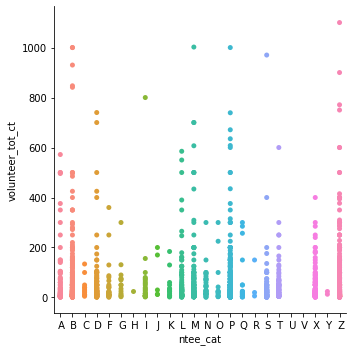

In [385]:
sns.catplot(x='ntee_cat', y='volunteer_tot_ct', jitter=False, data=kdf)

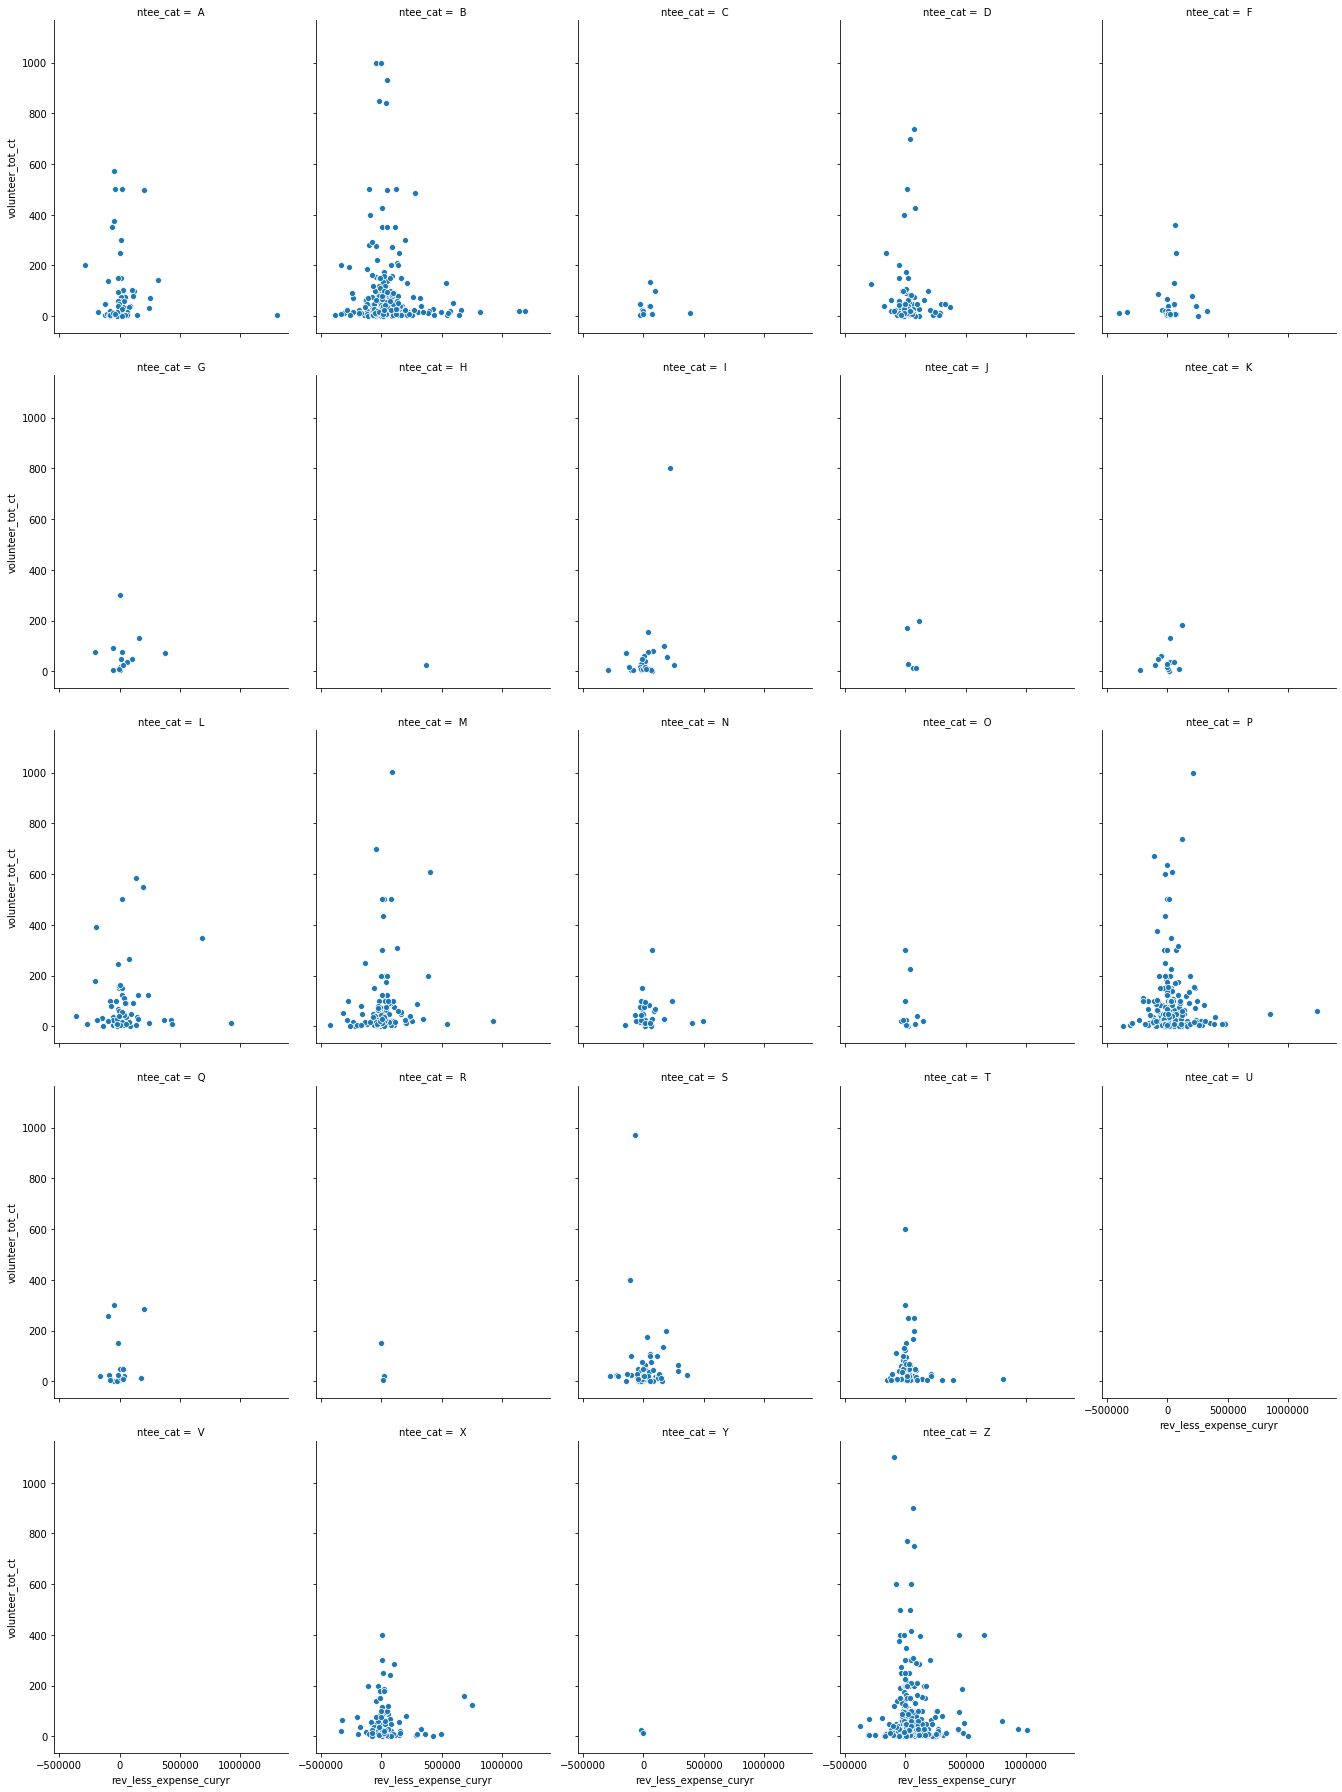

In [386]:
import seaborn as sns
sns.relplot(x='rev_less_expense_curyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=kdf)

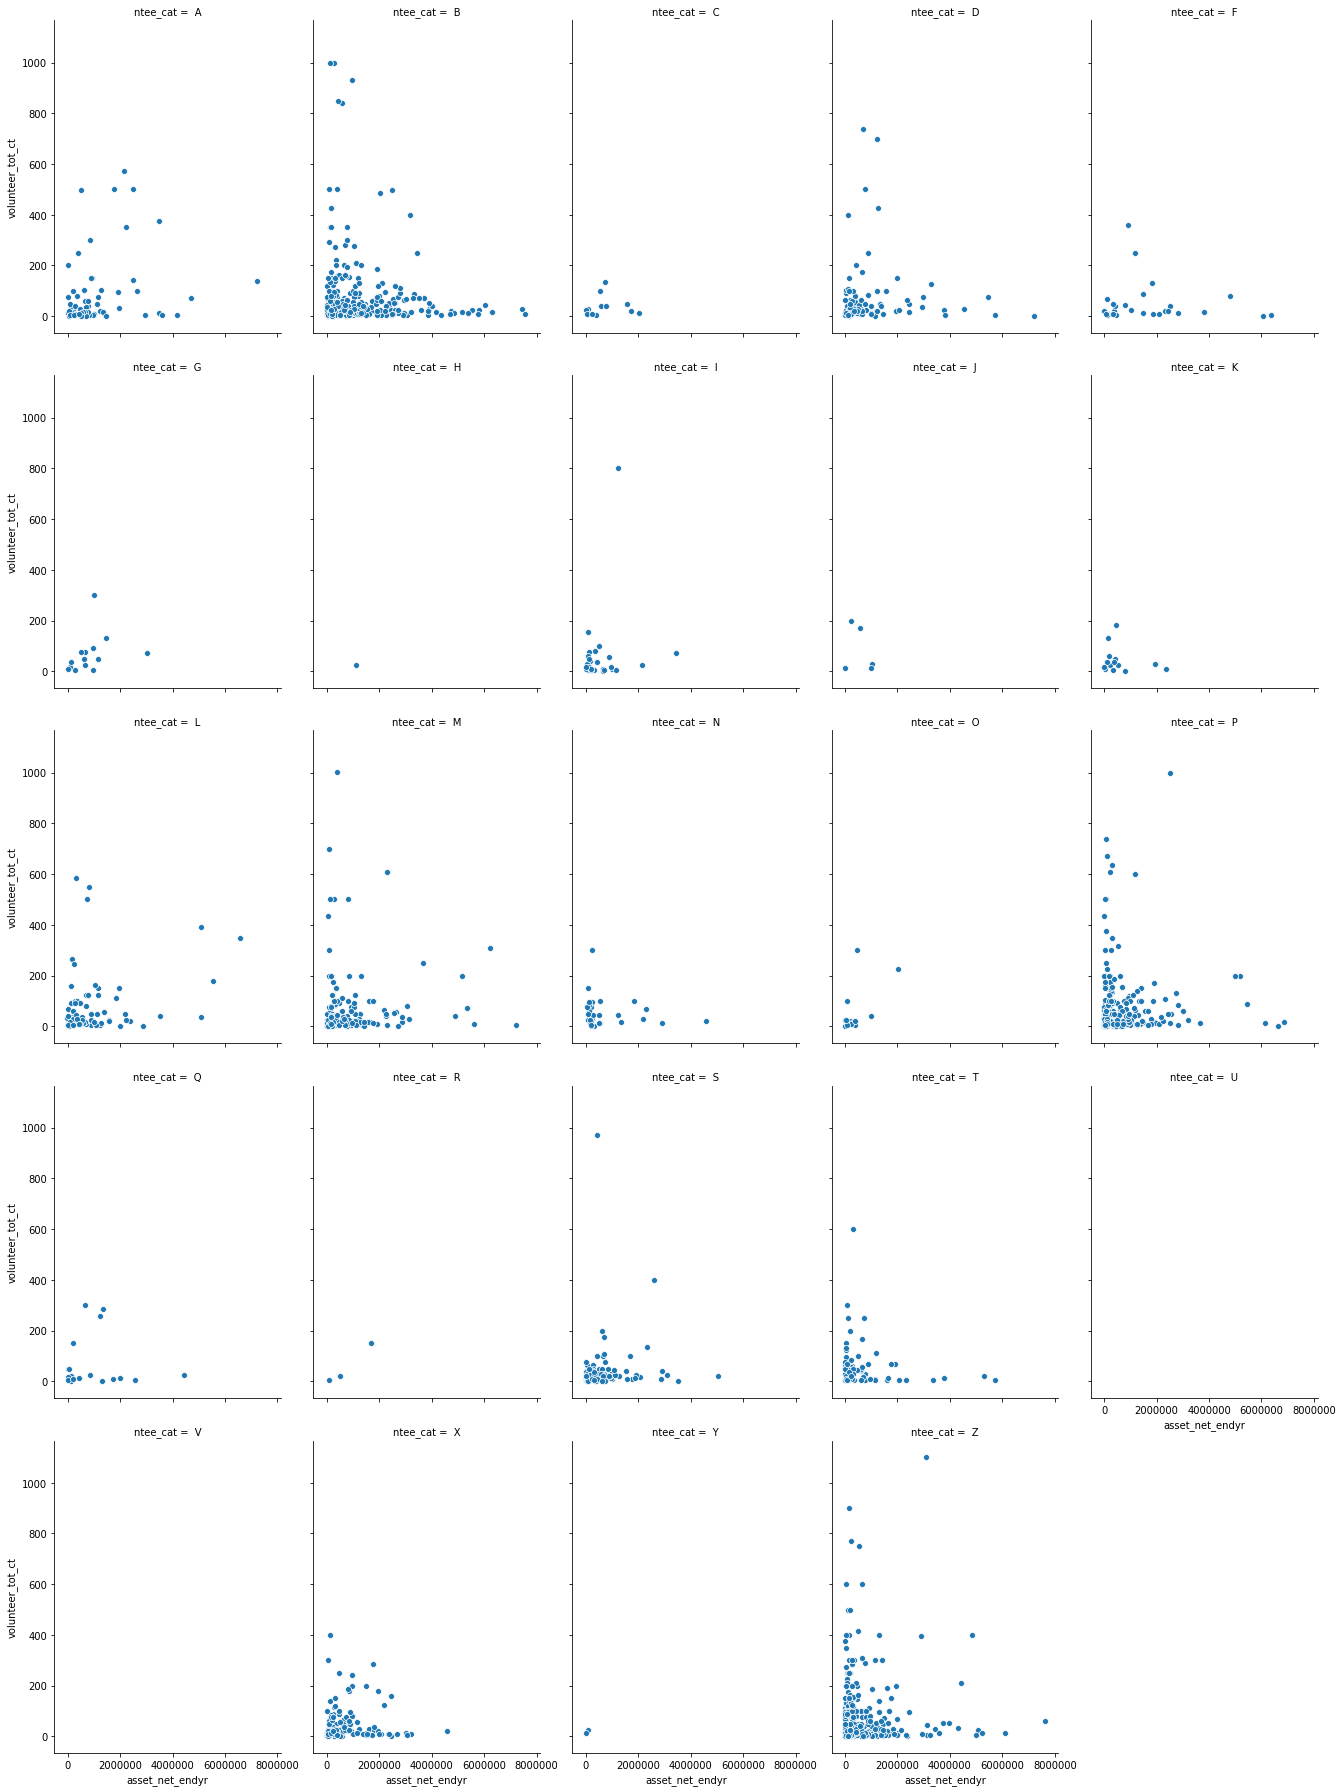

In [387]:
sns.relplot(x='asset_net_endyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=kdf)

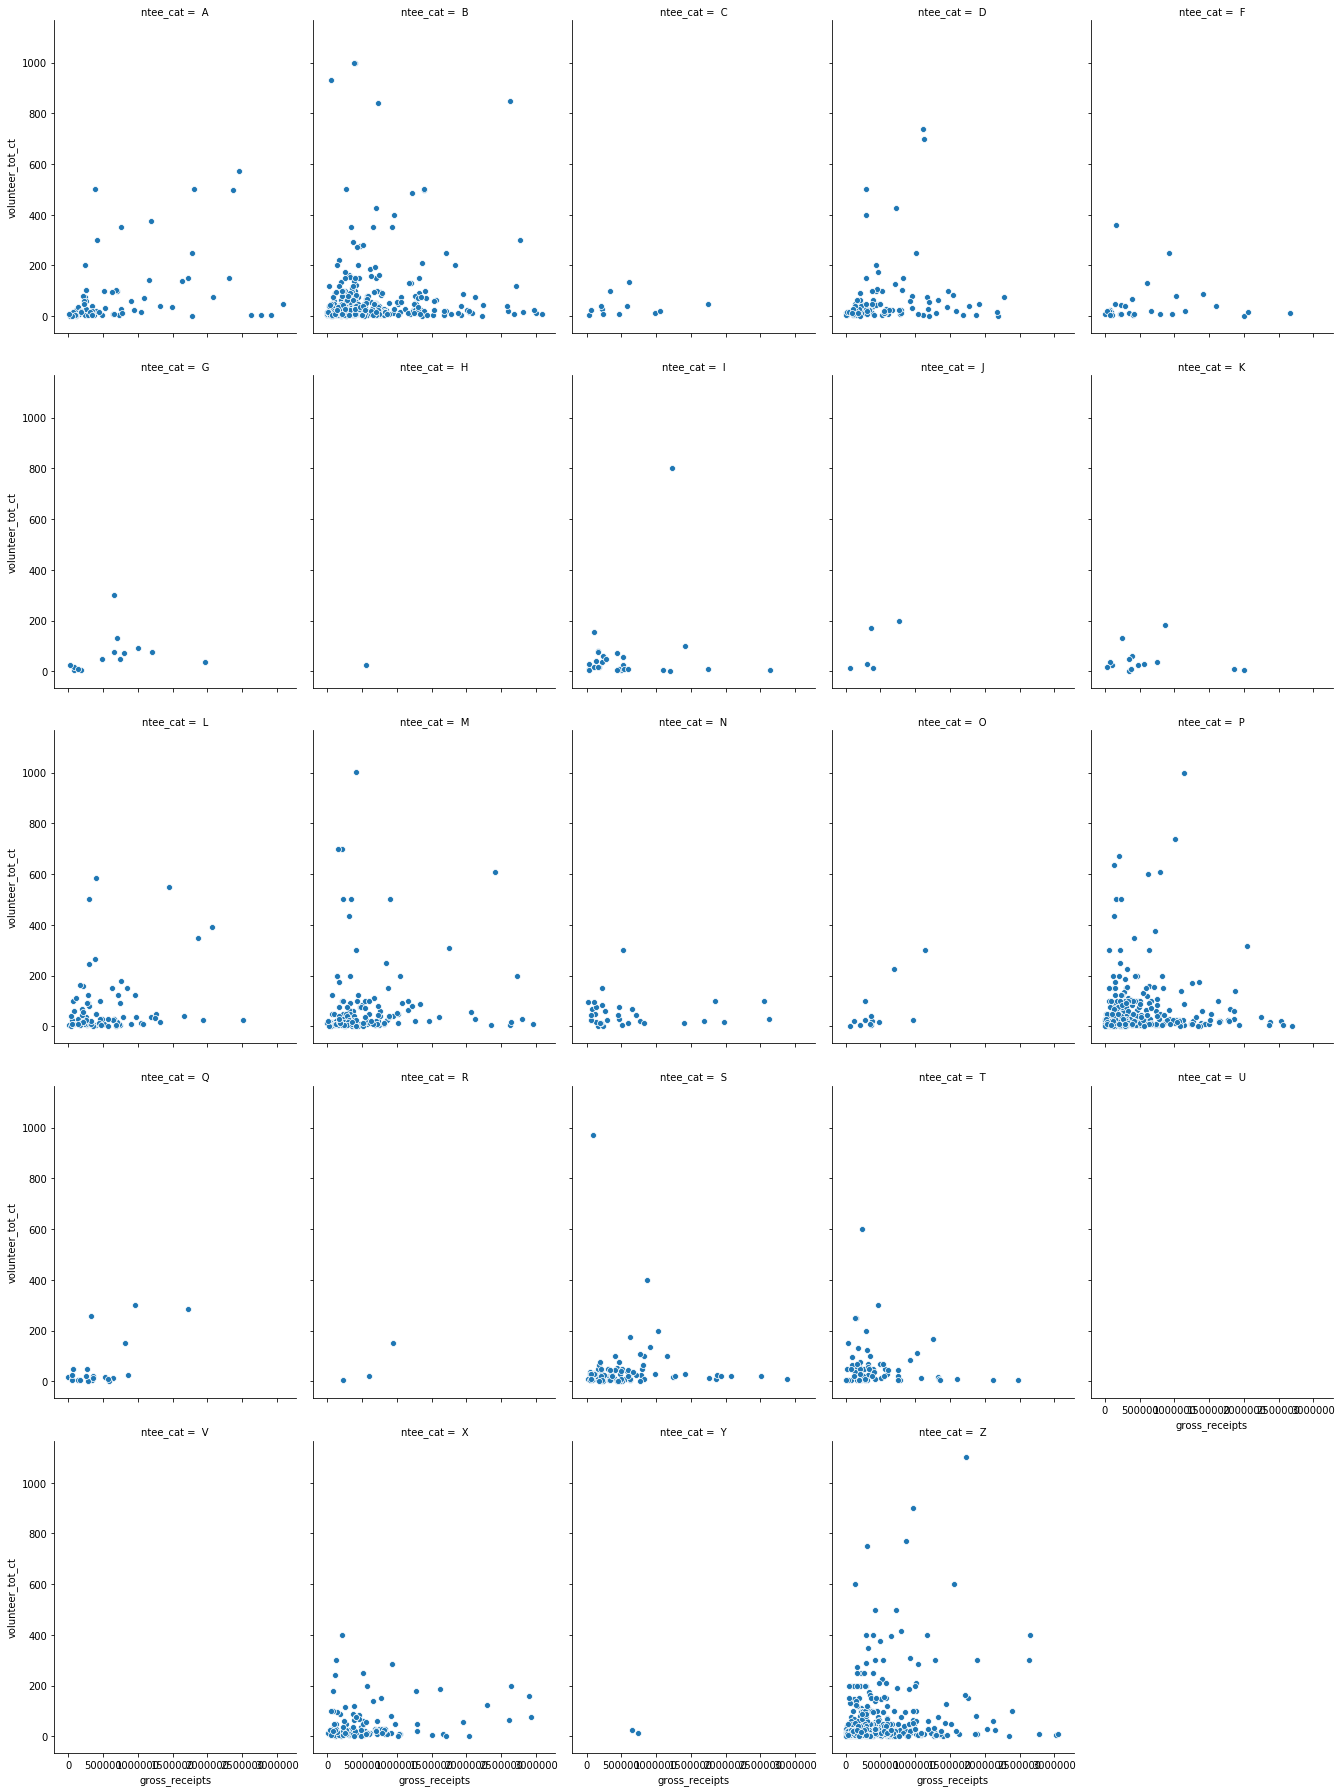

In [388]:
sns.relplot(x='gross_receipts', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=kdf)

In [389]:
kdf=kdf.drop(columns=['code_E'])

In [390]:
bool_var=['org_form.association', 'org_form.corp', 'org_form.other_form', 'org_form.trust',
          'local_chapt','code_A', 'code_B', 'code_C', 'code_D', 'code_F', 'code_G', 'code_H', 'code_I', 'code_J', 'code_K',
       'code_L', 'code_M', 'code_N', 'code_O', 'code_P', 'code_Q', 'code_R',
       'code_S', 'code_T', 'code_U', 'code_V', 'code_X', 'code_Y',
       'code_Z']
kdf=kdf.apply(lambda x: pd.to_numeric(x, errors='ignore'))
temp=df.copy()
kdf[bool_var]=kdf[bool_var].astype(bool)

kdf=kdf.apply(lambda x: x.astype(float) if (x.dtype=='int64') else x)
kdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20097 entries, 24 to 180782
Data columns (total 46 columns):
ein                       20097 non-null float64
name_org                  20097 non-null object
tax_yr                    20097 non-null float64
city                      20097 non-null object
state                     20097 non-null object
org_form.association      20097 non-null bool
org_form.corp             20097 non-null bool
org_form.other_form       20097 non-null bool
org_form.trust            20097 non-null bool
formation_yr              20097 non-null float64
gross_receipts            20097 non-null float64
voting_memb_ct            20097 non-null float64
employee_tot_ct           20097 non-null float64
volunteer_tot_ct          20097 non-null float64
rev_tot_curyr             20097 non-null float64
expense_tot_curyr         20097 non-null float64
rev_less_expense_curyr    20097 non-null float64
asset_tot_endyr           20097 non-null float64
asset_net_endyr       

In [391]:
df=kdf.copy()

# Model Selection
## Splitting test versus training sets

In [392]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide them into given bins to ensure that the number of ratings distribution represents the train and test sets
bins = [0, 10, 50, 100, 5000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
df['volunteer_tot_ct_cut'] = pd.cut(df['volunteer_tot_ct'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(df, df['volunteer_tot_ct_cut']):
    train_set, test_set = df.iloc[train_ind], df.iloc[test_ind]

test_label = test_set['volunteer_tot_ct'].copy()
test_identity = test_set[['name_org', 'ein']].copy()
test_set = test_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state','processed_name','ntee_cat'])

train_label = train_set['volunteer_tot_ct'].copy()
train_identity = train_set[['name_org', 'ein']].copy()
train_set_binned = train_set['volunteer_tot_ct_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state','processed_name','ntee_cat']) 
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 94346 to 165481
Data columns (total 38 columns):
org_form.association      4020 non-null bool
org_form.corp             4020 non-null bool
org_form.other_form       4020 non-null bool
org_form.trust            4020 non-null bool
formation_yr              4020 non-null float64
gross_receipts            4020 non-null float64
voting_memb_ct            4020 non-null float64
employee_tot_ct           4020 non-null float64
rev_tot_curyr             4020 non-null float64
expense_tot_curyr         4020 non-null float64
rev_less_expense_curyr    4020 non-null float64
asset_tot_endyr           4020 non-null float64
asset_net_endyr           4020 non-null float64
local_chapt               4020 non-null bool
code_A                    4020 non-null bool
code_B                    4020 non-null bool
code_C                    4020 non-null bool
code_D                    4020 non-null bool
code_F                    4020 non-null bool
code_

In [393]:
df.to_sql('Key_short_data', w, if_exists='replace', index=False)

query=''' SELECT *
FROM clean_Data
'''
df = pd.read_sql_query(query, w)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017568E3C5C8>,
      dtype=object)

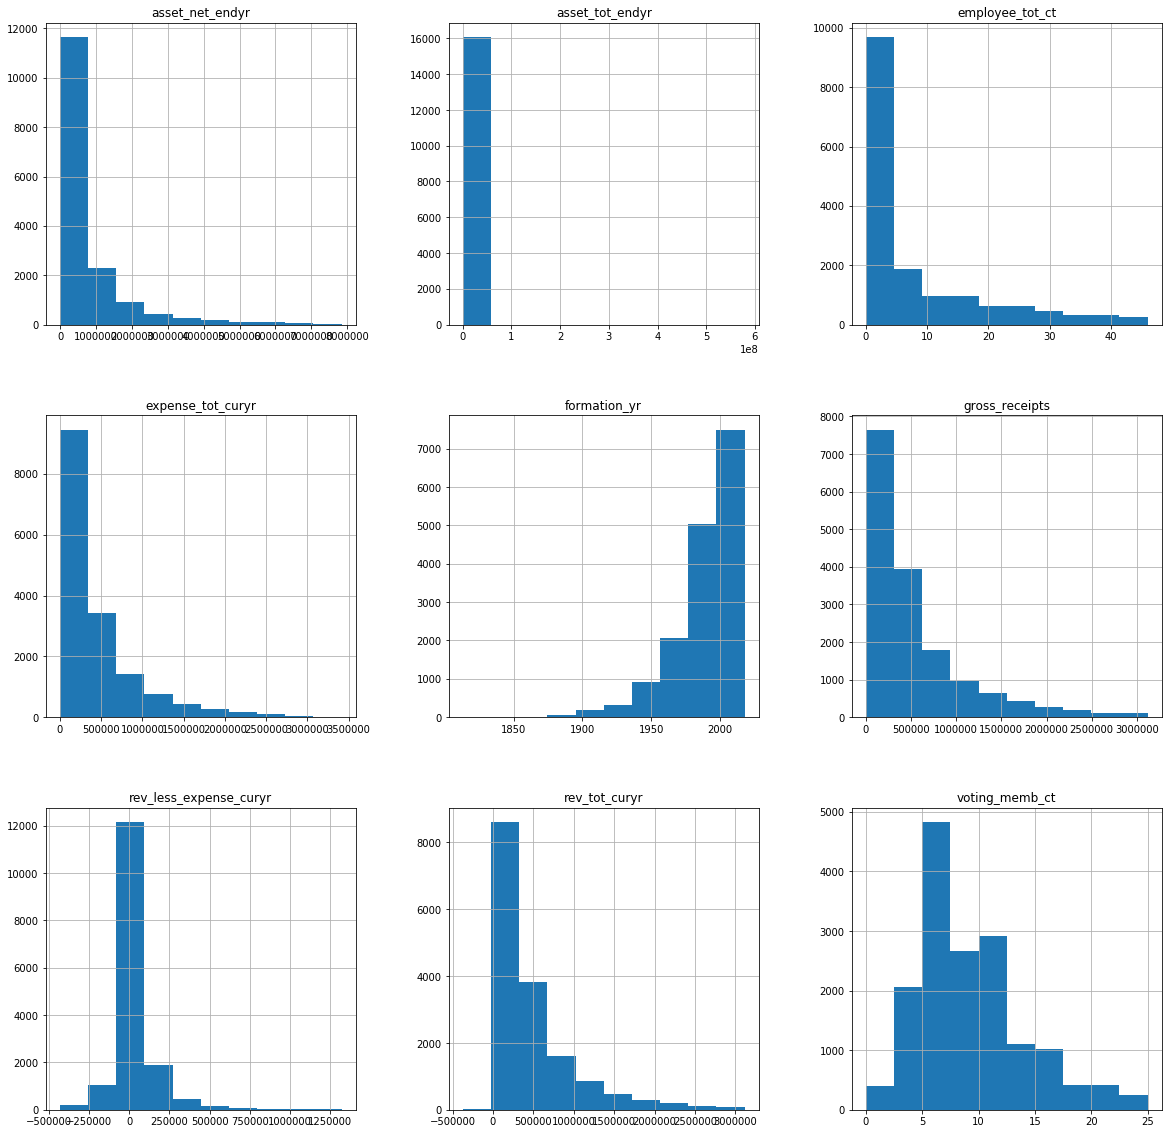

In [394]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox

class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        # ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]

        # # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans

        # # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr

        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])
train_set_processed = train_set.copy()
# Correct negative values by adding constants
for feat_idx, feat in enumerate(numeric_feat):
    if (train_set_processed[feat]<0).any()==True:
        train_set_processed[feat]= train_set_processed[feat]+ abs(min(train_set_processed[feat]))

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set_processed[numeric_feat])

train_set[numeric_feat].hist(bins=10, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017581B30048>,
      dtype=object)

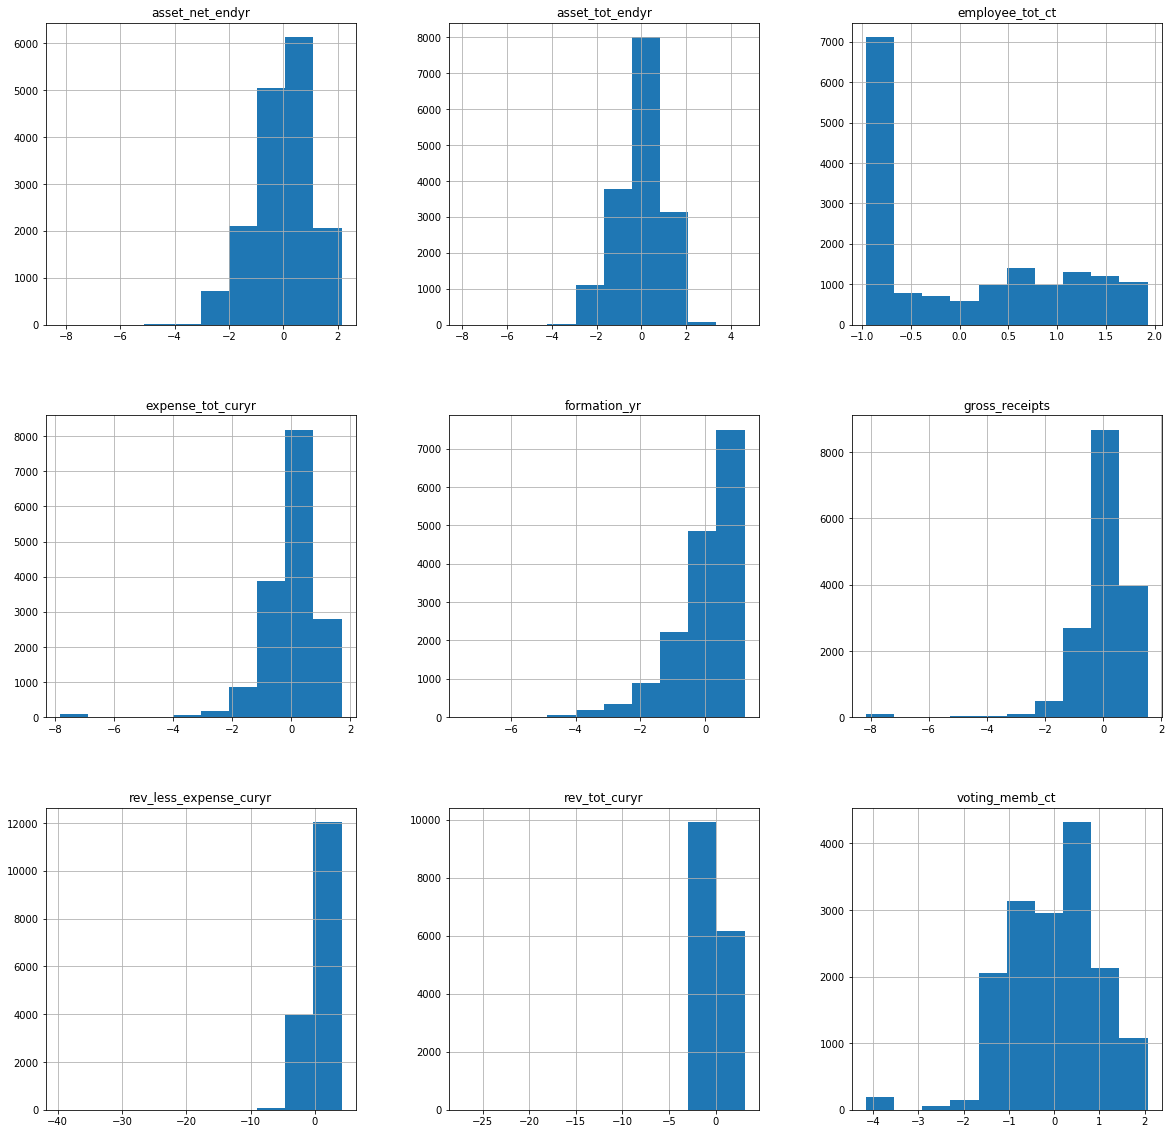

In [395]:
train_set_processed[numeric_feat].hist(bins=10, figsize=(20,20))

Not too bad, but note that some variables are skewed because the original data was heavily skewed. It is possible to delete more outliners.

In [360]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def init_cv_gen():
    '''Helper function that returns a generator for cross-validation'''
    skf = StratifiedKFold(5, shuffle=True, random_state=42).split(train_set_processed, train_set_binned)
    return skf

def cv_score(estimator):
    '''Generates cross validation scores; used to keep code clean when testing different models (estimator)'''
    cv = init_cv_gen()
    cv_score = cross_val_score(estimator=estimator, X=train_set_processed, y=train_label, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return cv_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [399]:
kdf['volunteer_tot_ct'].describe()

count    20097.000000
mean        69.836145
std        125.699051
min          1.000000
25%         10.000000
50%         25.000000
75%         70.000000
max       1168.000000
Name: volunteer_tot_ct, dtype: float64

In [396]:
#%% Linear Model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 68.75133611077524 ± 0.6579623172926835


In [400]:
from sklearn.linear_model import ElasticNet

ENreg = ElasticNet()
ENreg.fit(train_set_processed, train_label)

ENscores = cv_score(ENreg)
show_cv_result(-ENscores)

Cross validation mean score is : 69.19120240051744 ± 0.5835524247898538


The score is not as good as expected. Considering that the error is more than the 75% of data. Let's remove outliers further

In [401]:
from sklearn.linear_model import SGDRegressor

SGDreg = SGDRegressor(loss='huber',max_iter=5000, tol=1e-3)
SGDreg.fit(train_set_processed, train_label)

SGDscores = cv_score(SGDreg)
show_cv_result(-SGDscores)

Cross validation mean score is : 57.572749131177105 ± 0.567776850337509


In [402]:
from sklearn.svm import LinearSVR

SVRreg = LinearSVR()
SVRreg.fit(train_set_processed, train_label)

SVRscores = cv_score(SVRreg)
show_cv_result(-SVRscores)

Cross validation mean score is : 56.637682203192355 ± 0.5477185385639021


In [403]:
from sklearn.neighbors import KNeighborsRegressor

KNreg = KNeighborsRegressor()
KNreg.fit(train_set_processed, train_label)

KNscores = cv_score(KNreg)
show_cv_result(-KNscores)

Cross validation mean score is : 70.32151782688423 ± 0.8198079399211156


In [404]:
from sklearn.ensemble import RandomForestRegressor

RFRreg = RandomForestRegressor(n_estimators=100, random_state=42)
RFRreg.fit(train_set, train_label)

RFRscores = cv_score(RFRreg)
show_cv_result(-RFRscores)

Cross validation mean score is : 69.8655418338598 ± 0.7799538573325925


In [405]:
from sklearn.ensemble import GradientBoostingRegressor

GBRreg = GradientBoostingRegressor(loss='huber', random_state=42)
GBRreg.fit(train_set, train_label)

GBRscores = cv_score(GBRreg)
show_cv_result(-GBRscores)

Cross validation mean score is : 58.68822190170245 ± 0.4256148713282841


In [380]:
df['expense_tot_curyr'].describe()

count    1.422520e+05
mean     7.077173e+05
std      1.091700e+06
min     -2.665840e+05
25%      1.366830e+05
50%      2.978330e+05
75%      7.435330e+05
max      7.627666e+06
Name: expense_tot_curyr, dtype: float64

In [381]:
df['rev_less_expense_curyr'].describe()

count    1.422520e+05
mean     5.862960e+04
std      1.665264e+05
min     -1.673130e+05
25%     -1.178325e+04
50%      1.211600e+04
75%      6.886375e+04
max      1.372669e+06
Name: rev_less_expense_curyr, dtype: float64

In [382]:
df['gross_receipts'].describe()

count    1.422520e+05
mean     8.616358e+05
std      1.248071e+06
min      0.000000e+00
25%      2.024692e+05
50%      3.802005e+05
75%      9.432705e+05
max      1.118976e+07
Name: gross_receipts, dtype: float64

In [437]:
query=''' SELECT *
FROM clean_data
'''
df=pd.read_sql_query(query, w)

# Do not go past this

In [432]:
df=df.apply(lambda x: x.astype(float) if (x.dtype=='int32') else x)
df['formation_yr'].describe()

count    142252.000000
mean       1986.242099
std          27.478250
min        1057.000000
25%        1975.000000
50%        1993.000000
75%        2006.000000
max        2018.000000
Name: formation_yr, dtype: float64

In [438]:
df['formation_yr']=df[['formation_yr','tax_yr']].apply(lambda x: 2018-x['formation_yr'] if x['formation_yr']!=0 else 2018-x['tax_yr'], axis=1) 
df=df.rename(columns={'formation_yr': 'formation_dur'})
df['formation_dur'].describe()

count    142252.000000
mean         31.757901
std          27.478250
min           0.000000
25%          12.000000
50%          25.000000
75%          43.000000
max         961.000000
Name: formation_dur, dtype: float64

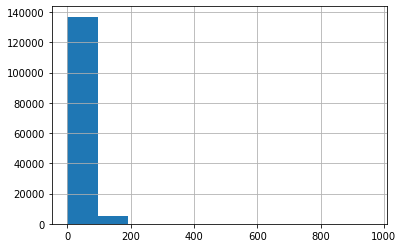

In [439]:
df['formation_dur'].hist(bins=10)

In [440]:
df['formation_dur']=df[['formation_dur','tax_yr']].apply(lambda x: 2020-x['tax_yr'] if x['formation_dur']>800 else x['formation_dur'], axis=1) 
df['formation_dur'].describe()

count    142252.000000
mean         31.734000
std          27.126208
min           0.000000
25%          12.000000
50%          25.000000
75%          43.000000
max         371.000000
Name: formation_dur, dtype: float64

In [441]:
df=df.loc[df['asset_net_endyr'].quantile(.05)< df['asset_net_endyr']]
df=df.loc[df['asset_net_endyr'].quantile(.95)> df['asset_net_endyr']]

df=df.loc[df['rev_tot_curyr'].quantile(.05)< df['rev_tot_curyr']]
df=df.loc[df['rev_tot_curyr'].quantile(.95)> df['rev_tot_curyr']]

df=df.loc[df['rev_less_expense_curyr'].quantile(.10)< df['rev_less_expense_curyr']]

df=df.loc[df['gross_receipts'].quantile(.95)> df['gross_receipts']]

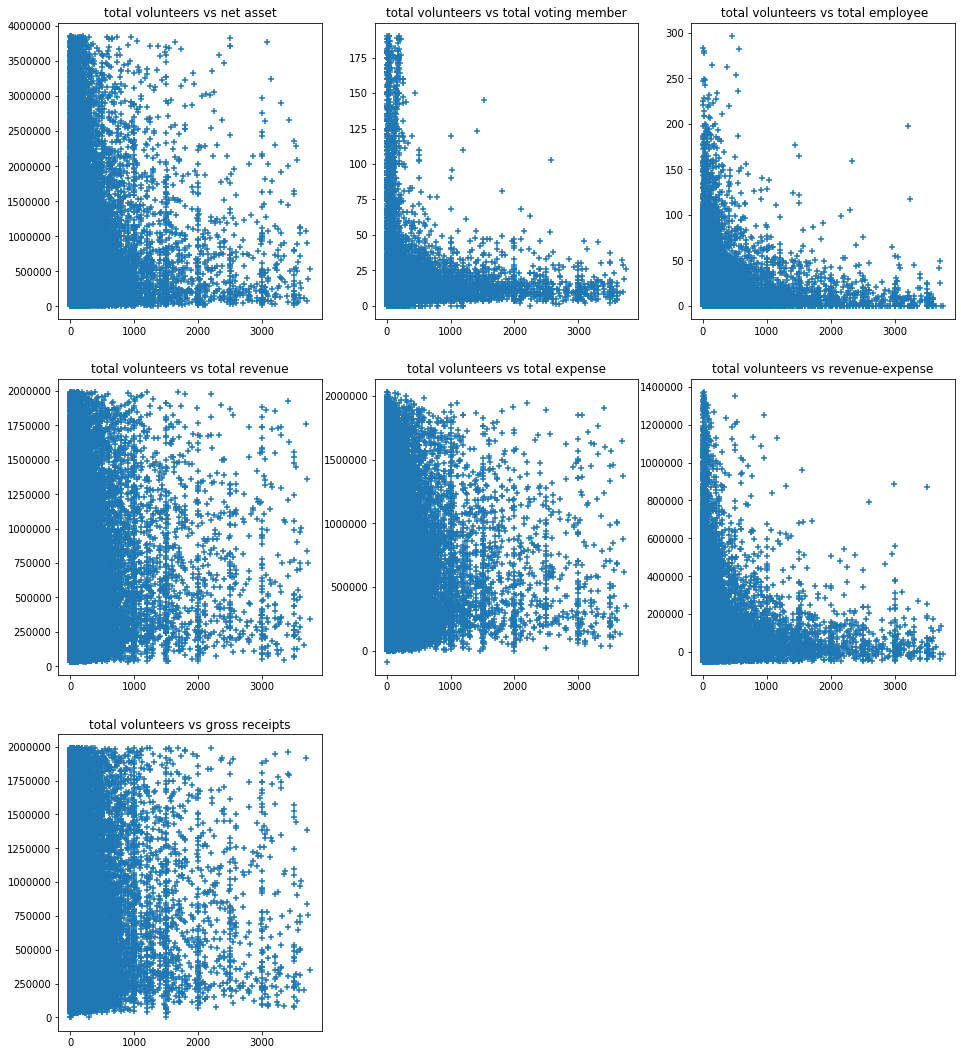

In [442]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2.2, top=5)
plt.show()

In [443]:
df['rev_less_expense_curyr'].describe()

count    9.906100e+04
mean     5.304779e+04
std      1.173807e+05
min     -5.110000e+04
25%     -3.537000e+03
50%      1.866100e+04
75%      6.494400e+04
max      1.372501e+06
Name: rev_less_expense_curyr, dtype: float64

## Relationships of ntee code and volunteer

In [450]:
v_ntee=df[[
              'code_A', 'code_B', 'code_C', 'code_D',
              'code_E', 'code_F', 'code_G', 'code_H', 
              'code_I', 'code_J', 'code_K','code_L', 
              'code_M', 'code_N', 'code_O', 'code_P', 
              'code_Q', 'code_R','code_S', 
              'code_T', 'code_U', 'code_V', 'code_W', 
              'code_X', 'code_Y', 'code_Z']]
v_ntee.columns = [col.replace('code_',' ') for col in v_ntee.columns]
v_ntee.columns.str.split('_', expand=True)
v_ntee=v_ntee[v_ntee==1].stack().reset_index().drop(0,1)
v_ntee=v_ntee.drop(columns=['level_0'])
v_ntee=v_ntee.rename(columns={'level_1': 'ntee_code'})
v_ntee['ntee_code']=v_ntee['ntee_code'].astype('category')
v_ntee.head()

ntee_code
0         W
1         Y
2         S
3         S
4         A

In [456]:
df['ntee_cat']=v_ntee['ntee_code']

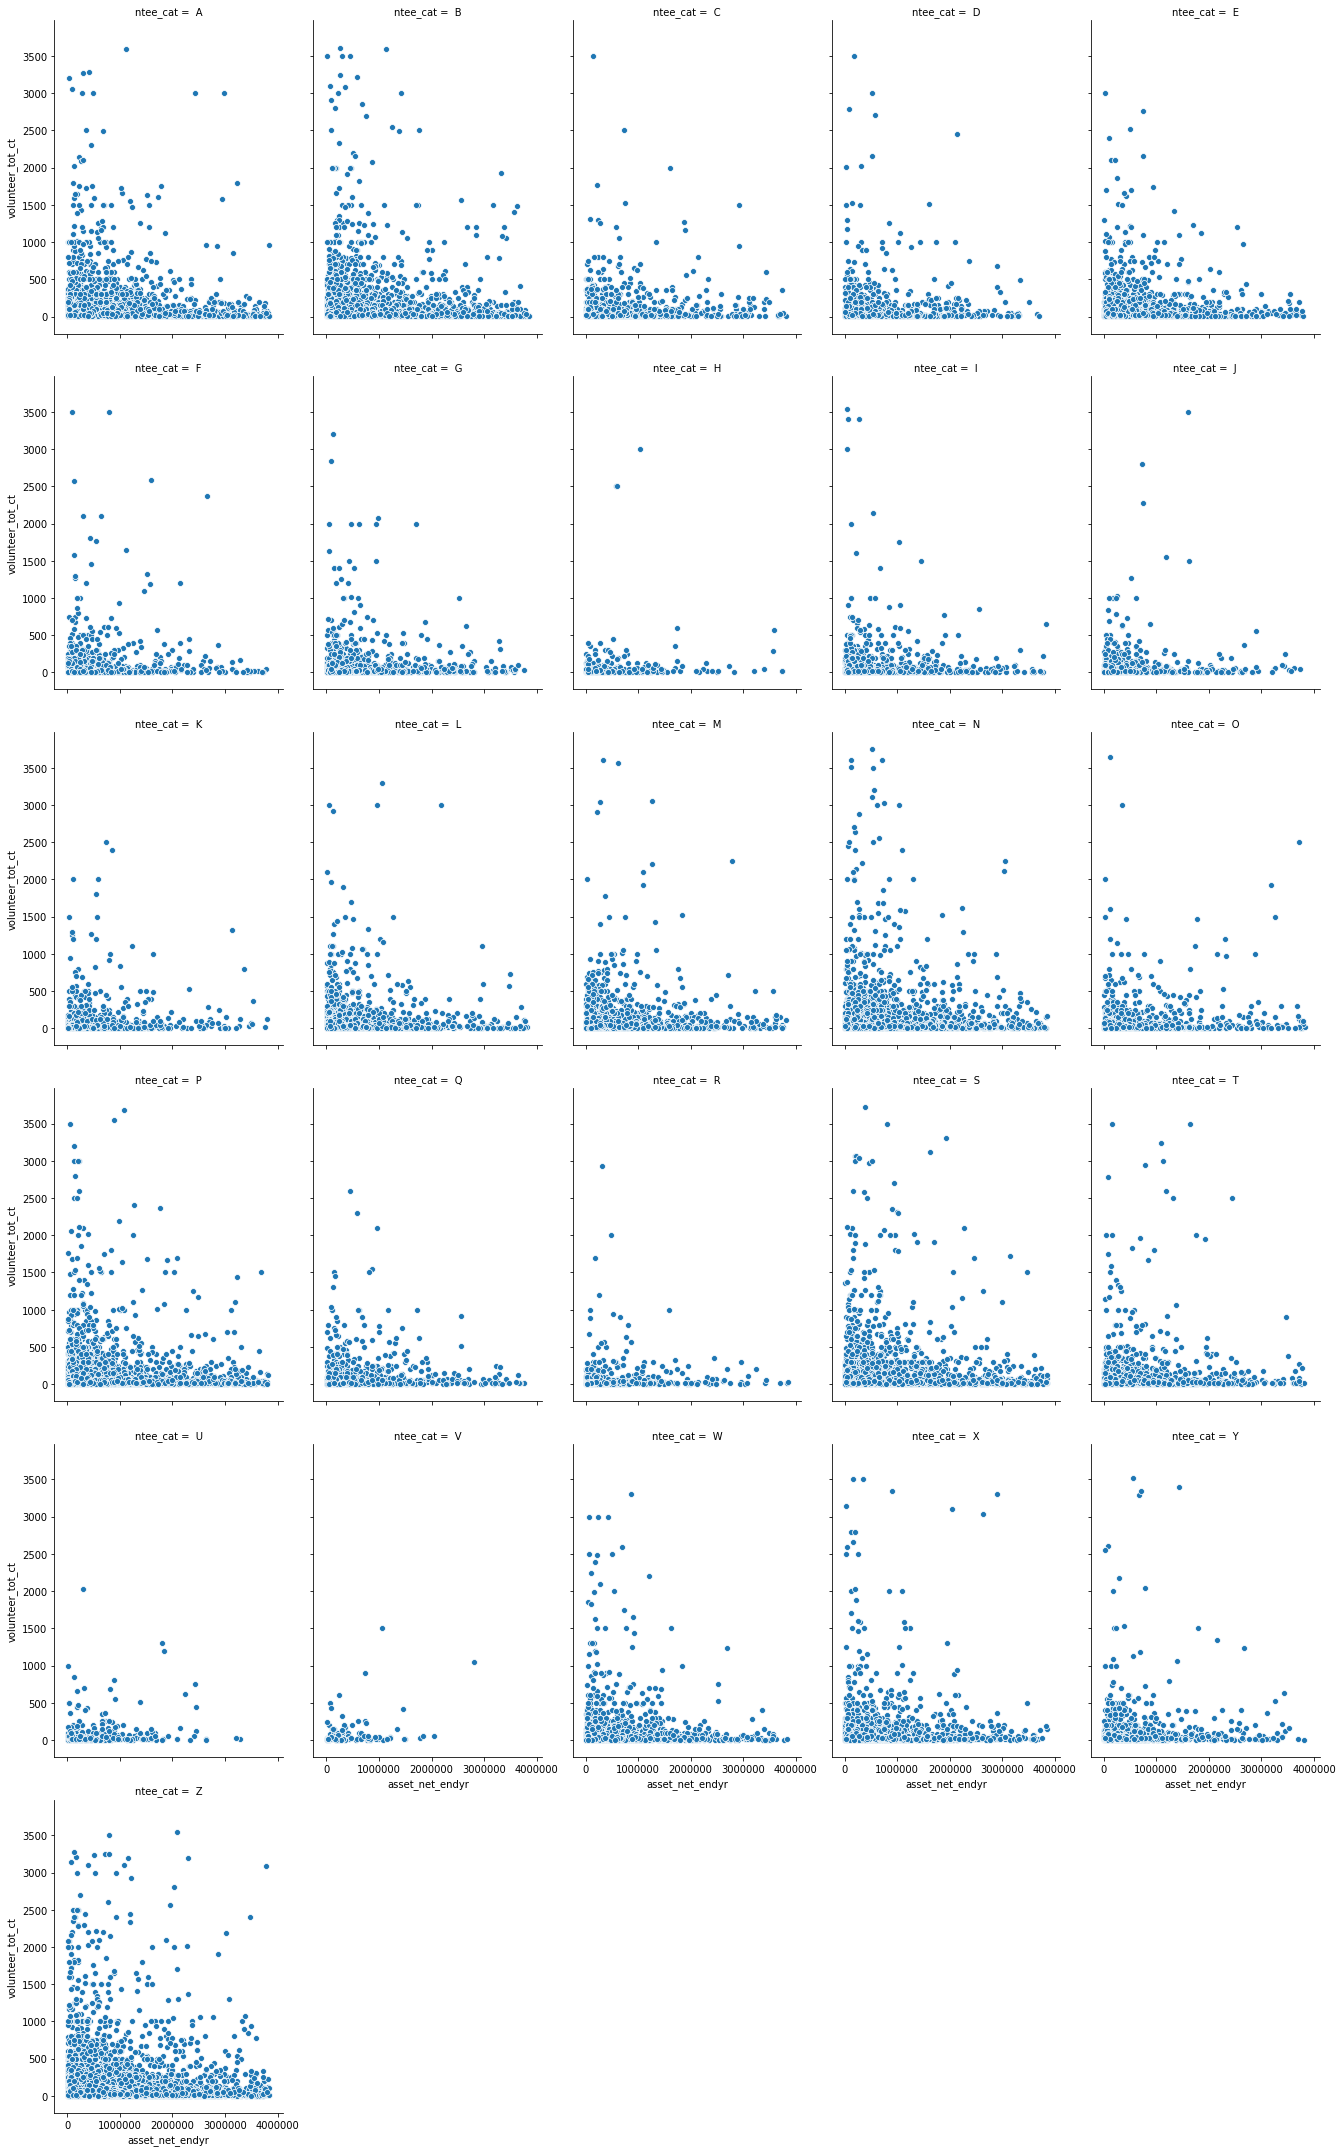

In [466]:
sns.relplot(x='asset_net_endyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

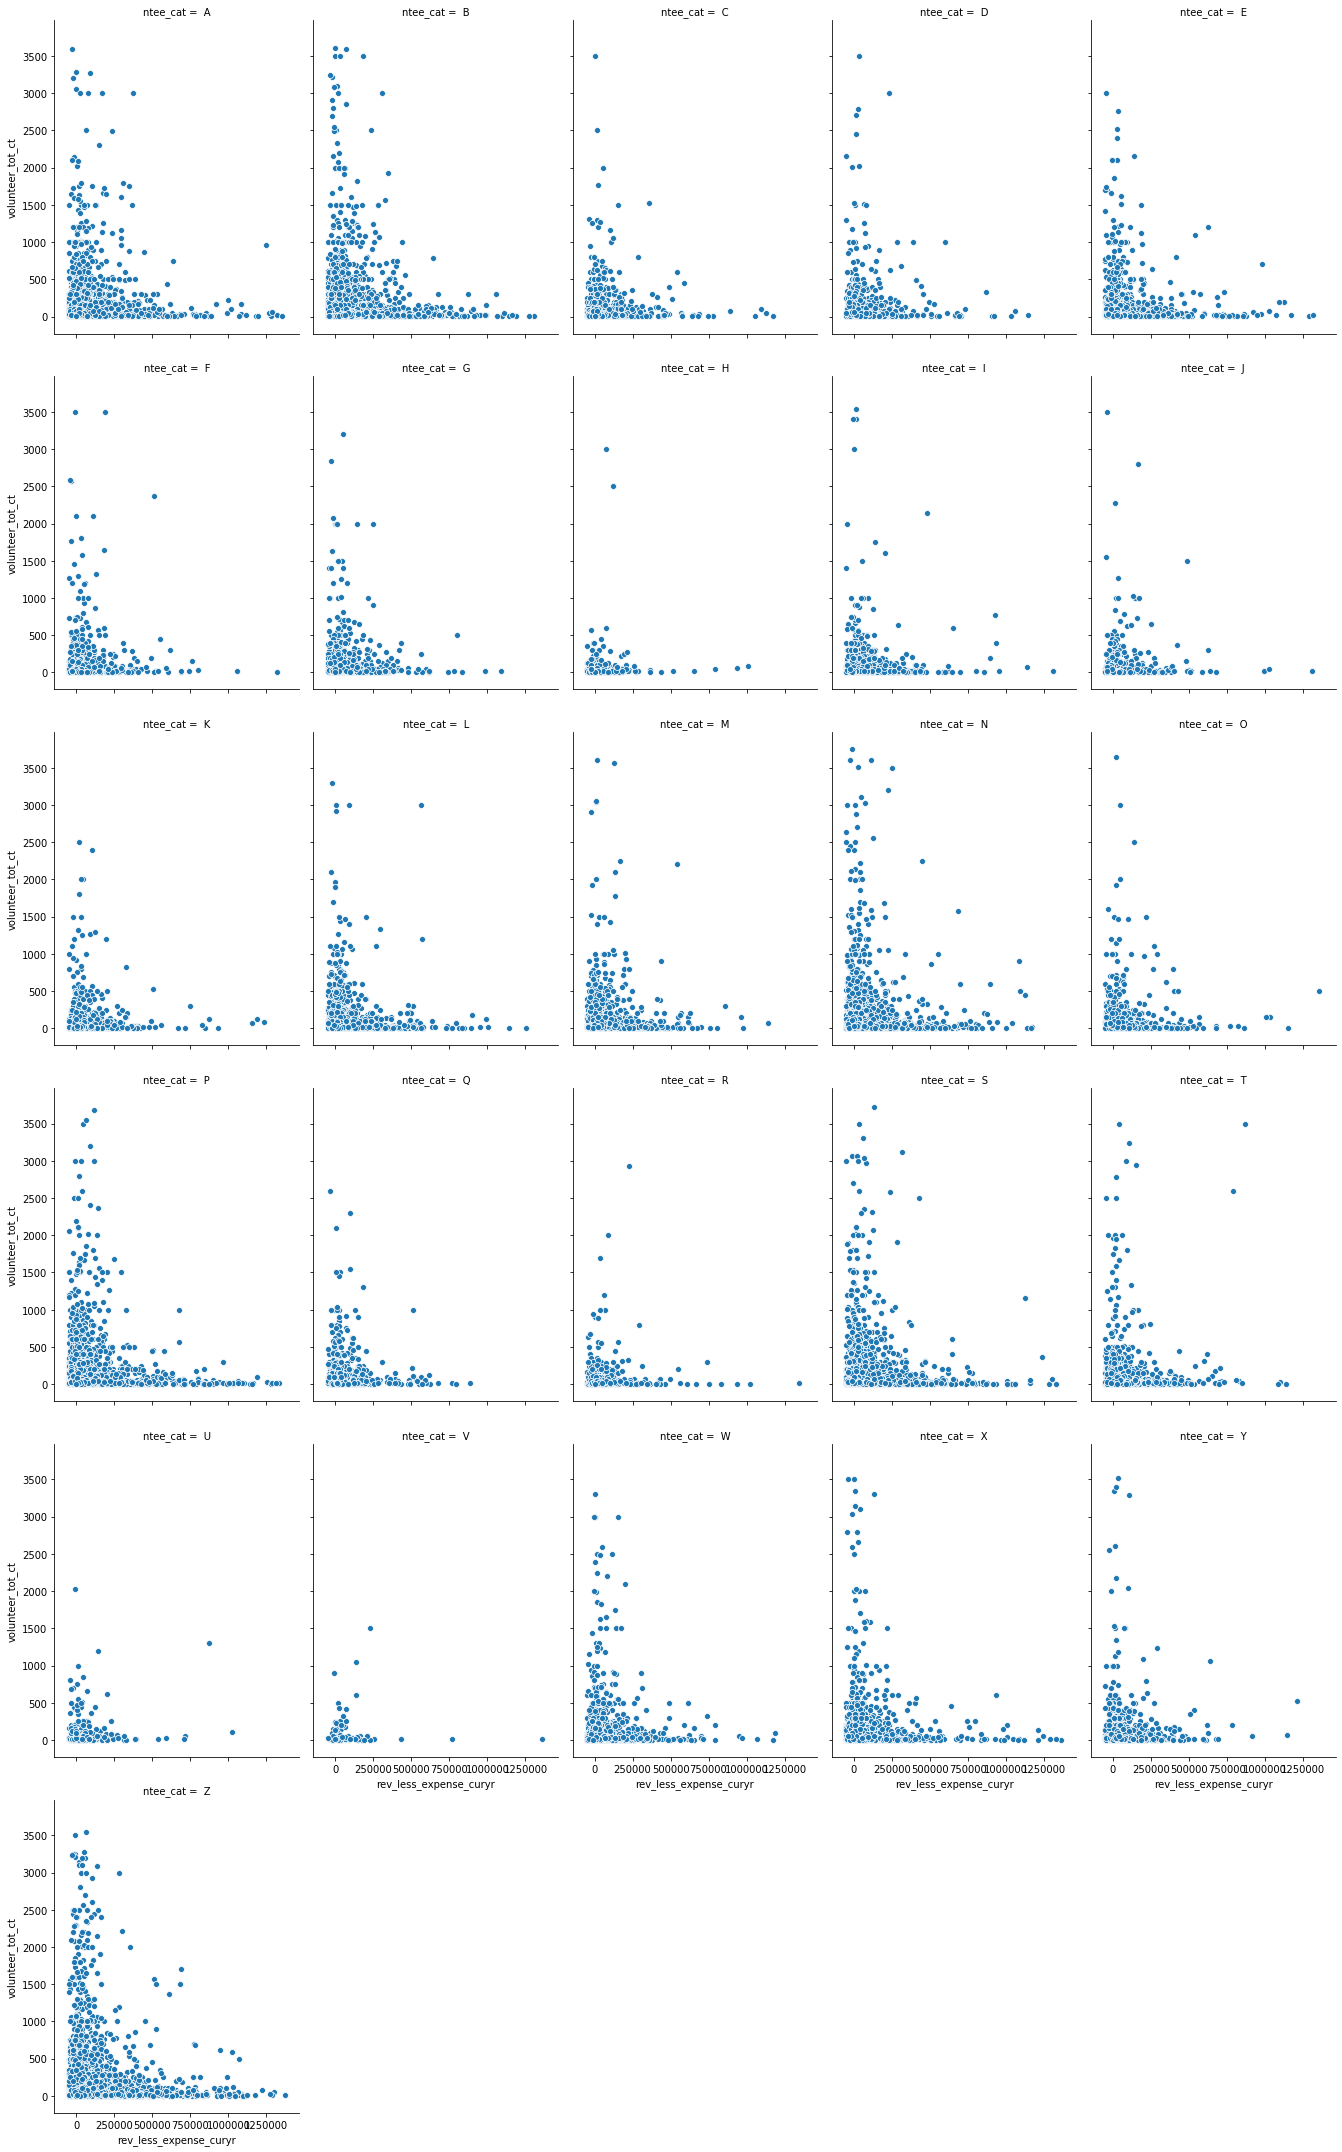

In [467]:
sns.relplot(x='rev_less_expense_curyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

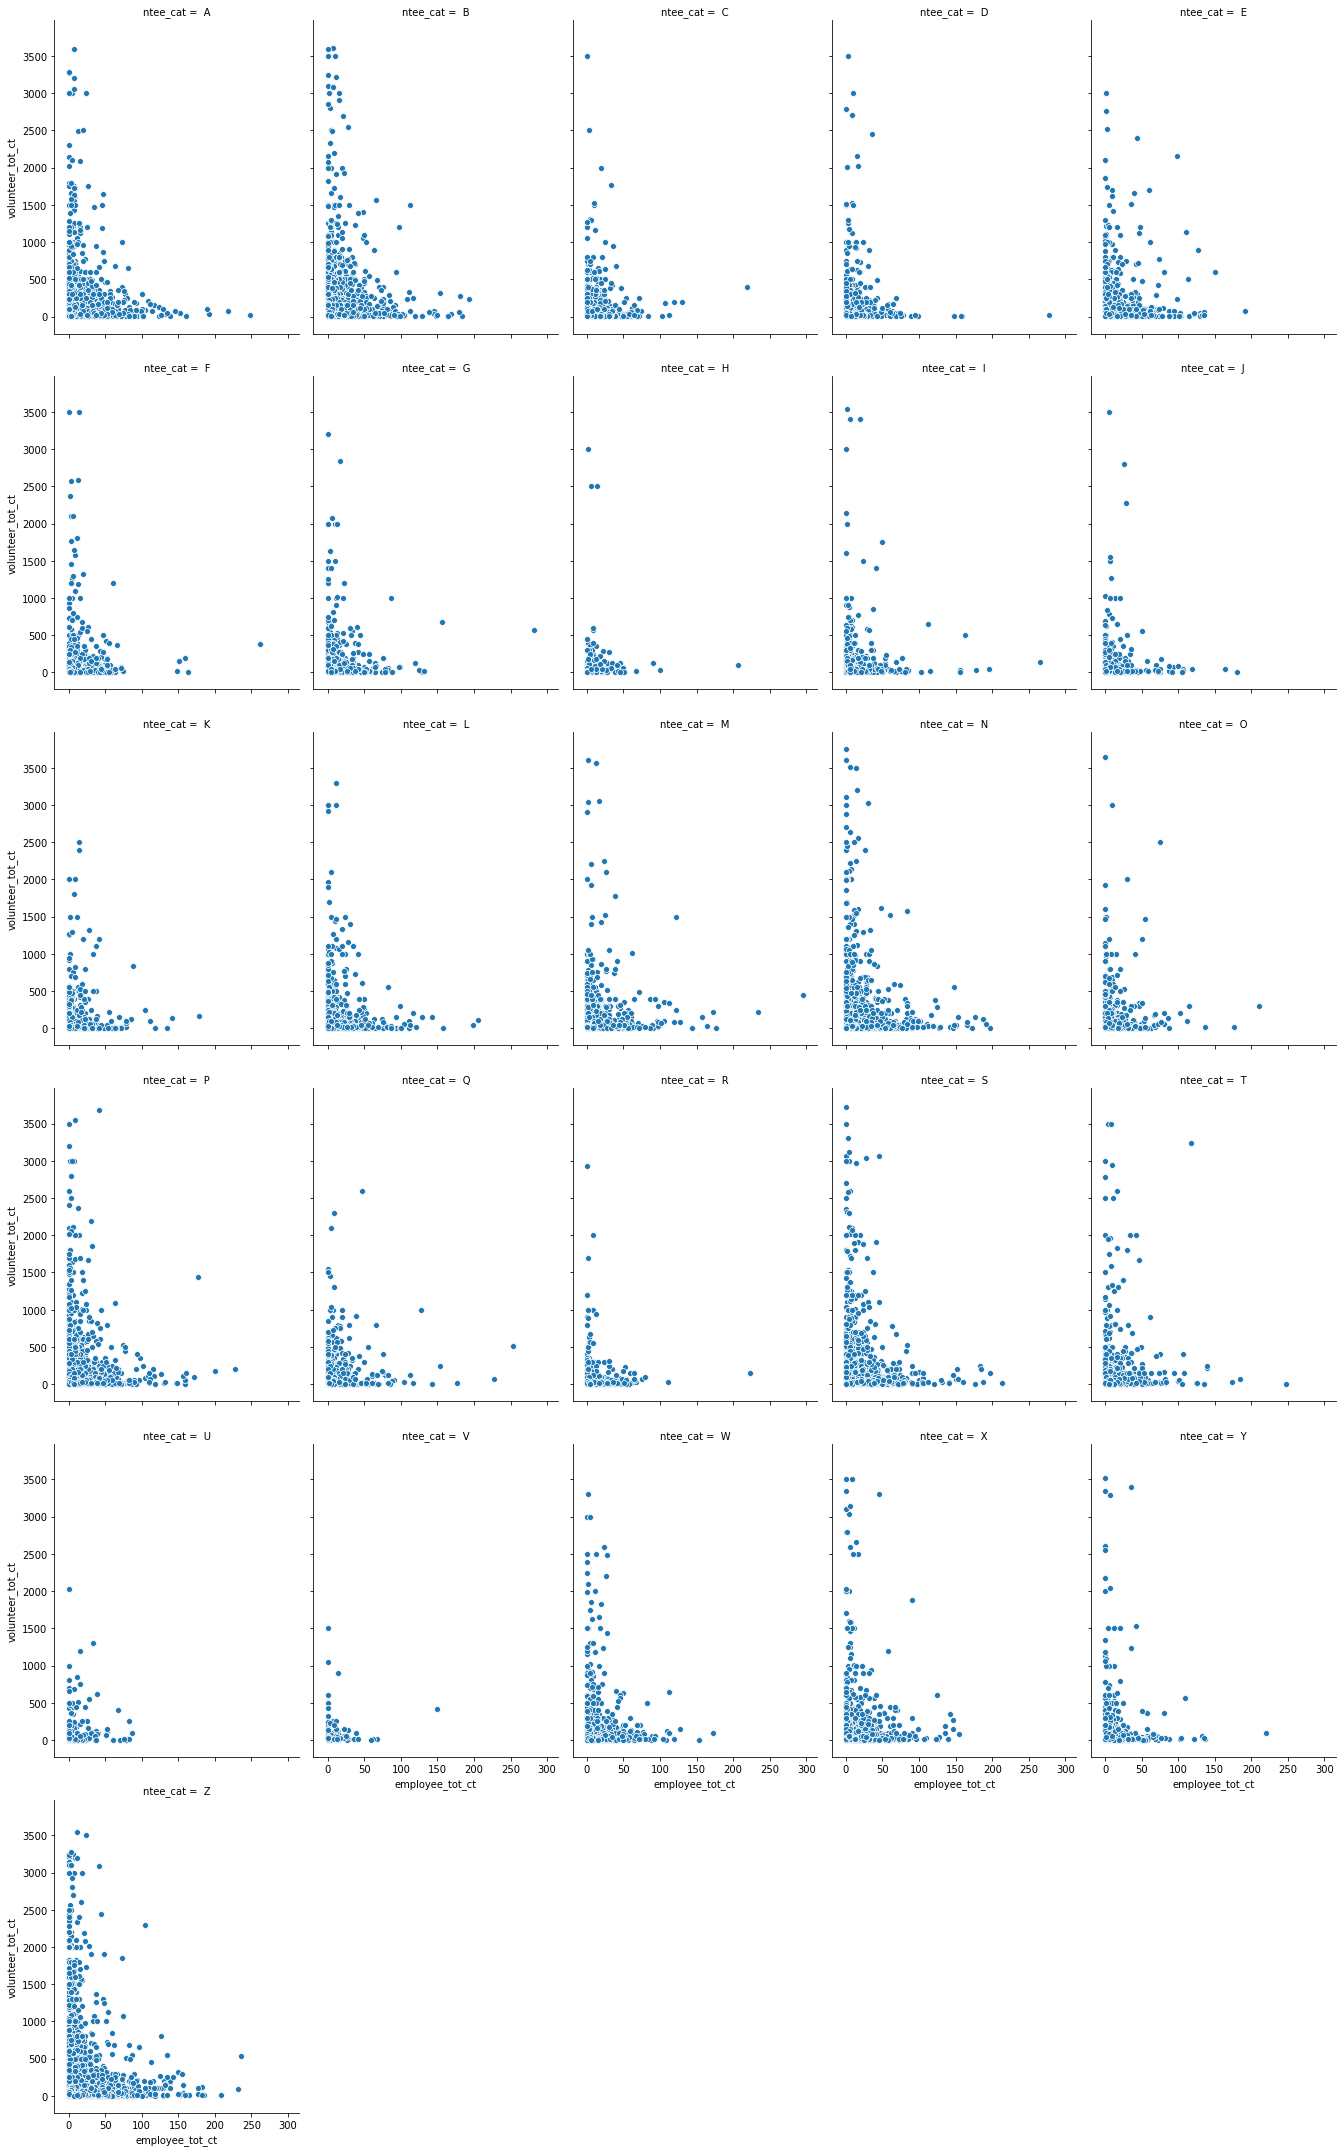

In [468]:
sns.relplot(x='employee_tot_ct', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

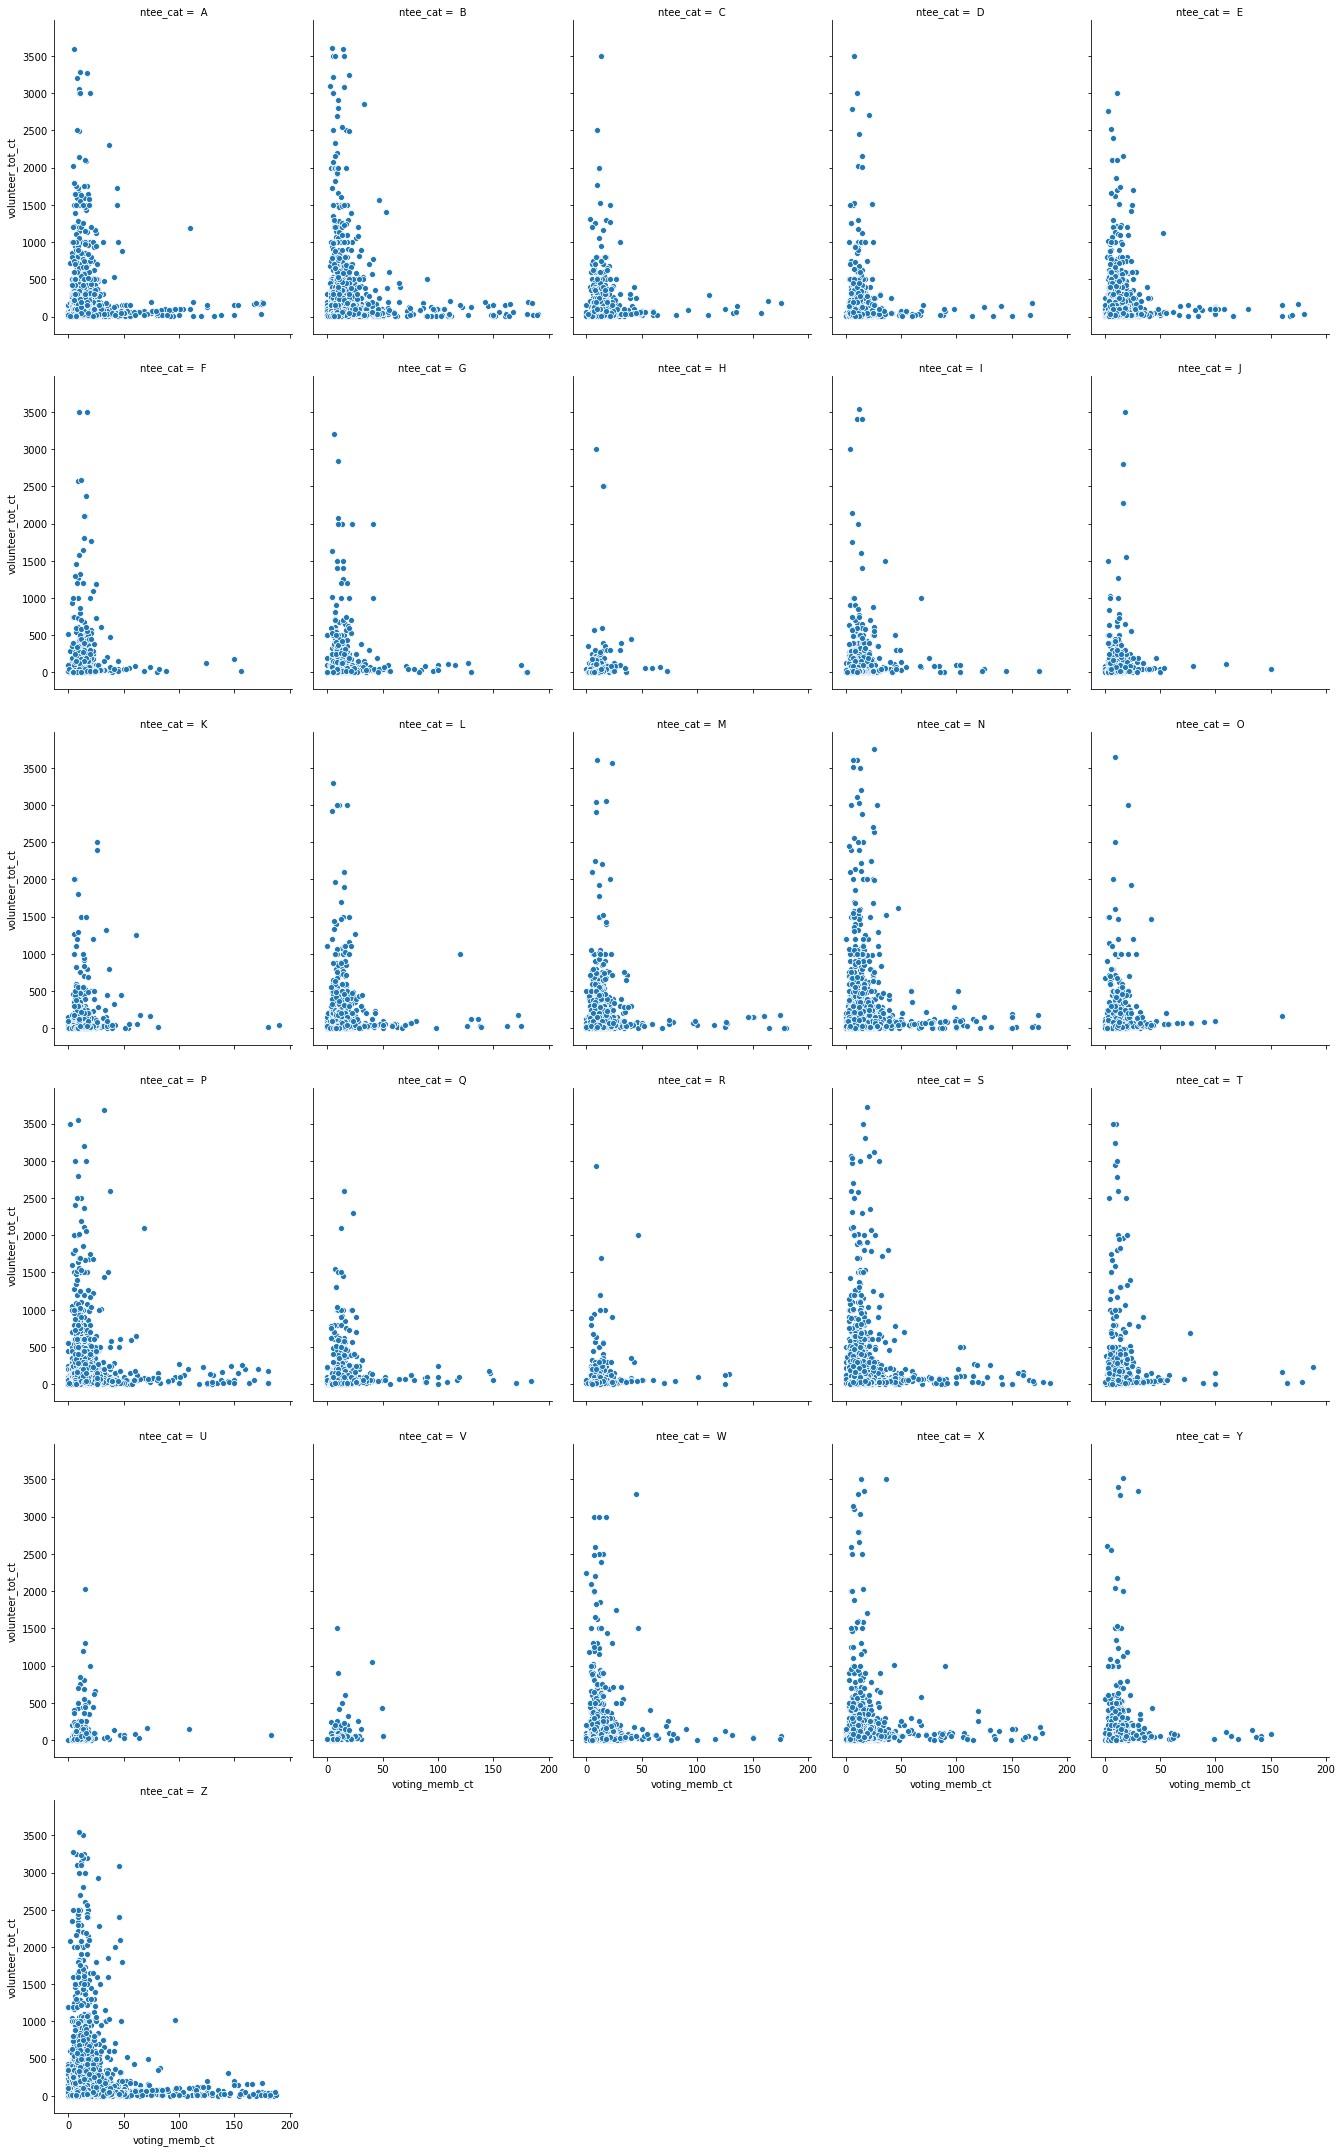

In [470]:
sns.relplot(x='voting_memb_ct', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

In [341]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide them into given bins to ensure that the number of ratings distribution represents the train and test sets
bins = [0, 10, 50, 100, 5000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
df['volunteer_tot_ct_cut'] = pd.cut(df['volunteer_tot_ct'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(df, df['volunteer_tot_ct_cut']):
    train_set, test_set = df.iloc[train_ind], df.iloc[test_ind]

test_label = test_set['volunteer_tot_ct'].copy()
test_identity = test_set[['name_org', 'ein']].copy()
test_set = test_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state','ntee_cat'])

train_label = train_set['volunteer_tot_ct'].copy()
train_identity = train_set[['name_org', 'ein']].copy()
train_set_binned = train_set['volunteer_tot_ct_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state', 'ntee_cat']) 
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4982 entries, 92714 to 14770
Data columns (total 40 columns):
org_form.association      4982 non-null int64
org_form.corp             4982 non-null int64
org_form.other_form       4982 non-null int64
org_form.trust            4982 non-null int64
formation_yr              4982 non-null int64
gross_receipts            4982 non-null float64
voting_memb_ct            4982 non-null float64
employee_tot_ct           4982 non-null float64
rev_tot_curyr             4982 non-null float64
expense_tot_curyr         4982 non-null float64
rev_less_expense_curyr    4982 non-null float64
asset_tot_endyr           4982 non-null float64
asset_net_endyr           4982 non-null float64
local_chapt               4982 non-null int64
code_A                    4982 non-null int64
code_B                    4982 non-null int64
code_C                    4982 non-null int64
code_D                    4982 non-null int64
code_E                    4982 non-null int6

In [342]:
train_set.to_sql('train_set', w, if_exists='replace', index=False)
train_label.to_sql('train_label', w, if_exists='replace', index=False)
test_set.to_sql('test_set', w, if_exists='replace', index=False)
test_label.to_sql('test_label', w, if_exists='replace', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017598C73A08>,
      dtype=object)

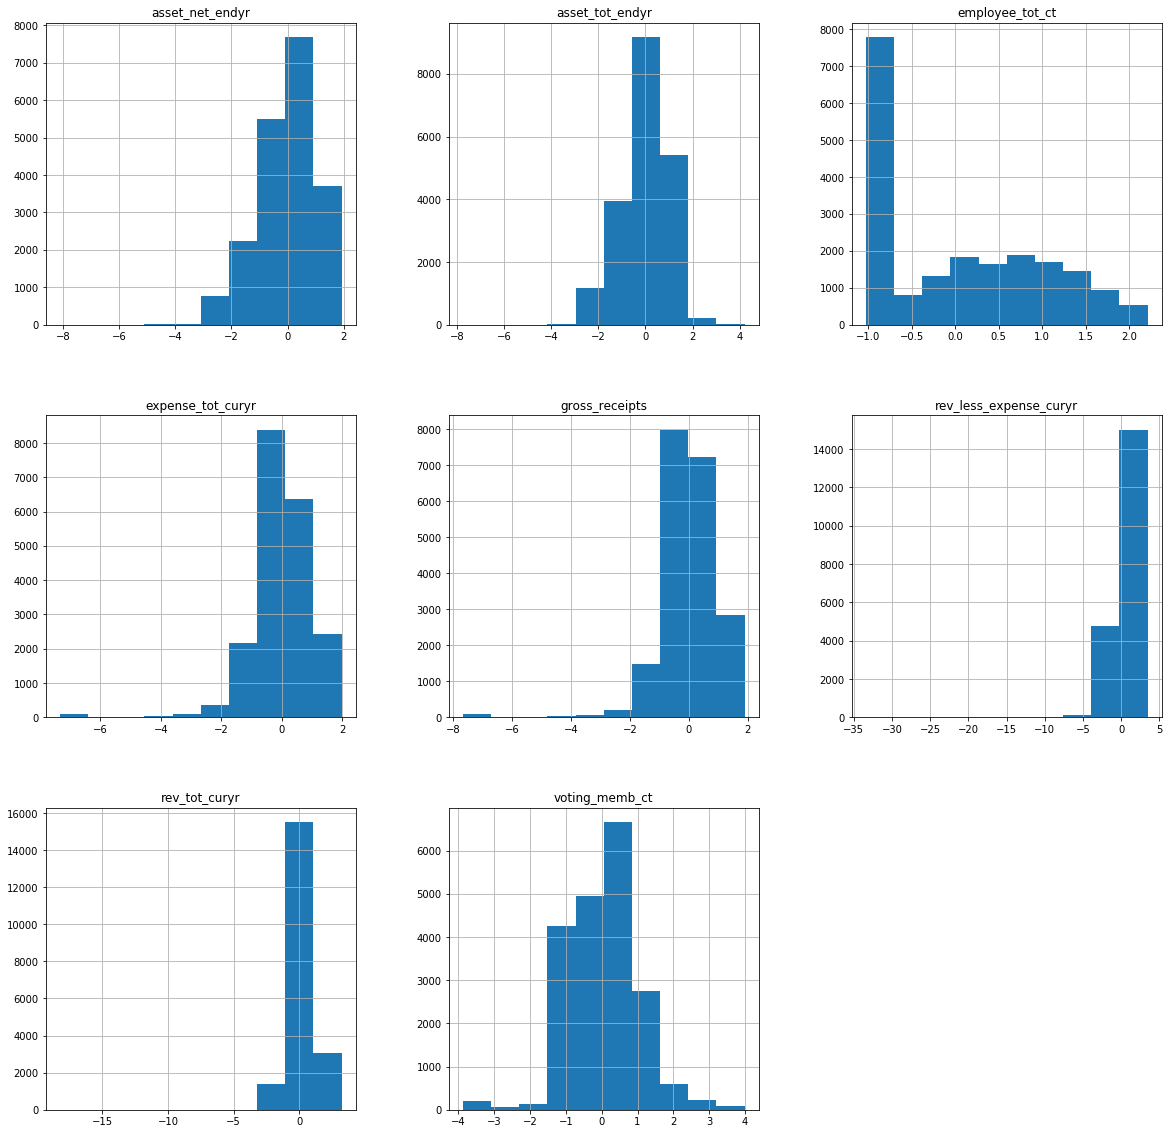

In [343]:
num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])
train_set_processed = train_set.copy()
# Correct negative values by adding constants
for feat_idx, feat in enumerate(numeric_feat):
    if (train_set_processed[feat]<0).any()==True:
        train_set_processed[feat]= train_set_processed[feat]+ abs(min(train_set_processed[feat]))

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set_processed[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(20,20))

In [475]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 107.57004794897364 ± 1.4697671676108608
